<a href="https://colab.research.google.com/github/jsblandon/ShapeClassification/blob/master/mainReliefFCKA_ETH80DB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bag of Contour Fragments Feature Selection using ReliefF and Centered Kernel Alignment - ETH-80 DB**

**Authors:** 


*   Juan Sebastian Blandon Luengas, Automatic Researh Group, Universidad Tecnologica de Pereira, jsblandon@utp.edu.co
*   Andres Marino Alvarez Meza, Control and Digital Signal Processing Group, Universidad Nacional de Colombia - Sede Manizales, amalvarezme@unal.edu.co

**Recommendation before starting**

Preventing Google Colab disconection:



1.   Press key combination $\texttt{Ctrl+Shift+i}$. Then, in the emerging window press $\texttt{Console}$

2.   Once the $\texttt{Console}$ has open, introduce the next code:


  ```
  function ClickConnect(){
  console.log("Working"); 
  document.querySelector("colab-toolbar-button#connect").click() 
  }
  setInterval(ClickConnect,60000)
  ```



3.   Then, press $\texttt{Enter}$. If the process is correct the message $\texttt{working}$ appears in console, but if it is incorrect introduce the next code:



  ```
  function ClickConnect(){
  console.log("Working"); 
  document.querySelector("colab-toolbar-button").click() 
  }setInterval(ClickConnect,60000)
  ```

**Loading auxiliary functions and database from a .zip file**



We load the needed complementary functions to run this code. Specially, we used a version of Centered Kernel Alignment algorithm implemented in python, which is based on the codes from:

*Alvarez-Meza AM, Orozco-Gutierrez A, Castellanos-Dominguez G. Kernel-based relevance analysis with enhanced interpretability for detection of brain activity patterns. Frontiers in neuroscience. 2017 Oct 6;11:550.*

In [ ]:
# # This code cell loads the Auxiliary Functions:
# FILEID = "10bDUcXkDixgtZziiYJQGXL1YX6JpjkoS"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
# !unzip codigos.zip
# !dir

he next cell load the database, which is get from the Bag of Contour Fragments approach proposed in:

*Wang X, Feng B, Bai X, Liu W, Latecki LJ. Bag of contour fragments for robust shape classification. Pattern Recognition. 2014 Jun 1;47(6):2116-25.*

In [ ]:
# # This code cell load the Database
# FILEID = "10cMlfBnqn440PqeXmSVOnQuH5q15_Q_N"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
# !unzip codigos.zip
# !dir

An additional package is installed

In [ ]:
!pip install --user skrebate

The needed packages and functions are imported

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import  BaseEstimator, TransformerMixin
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from skrebate import ReliefF
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression, SGDClassifier, LassoCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from tqdm import tqdm
from numpy import array

/home/jsblandon/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# from google.colab import files, drive

# drive.mount('/content/drive')
# %cd /content/drive/My\ Drive/

Avoiding unnecessary warning messages

In [ ]:
warnings.filterwarnings("ignore")

Setting the seed

In [ ]:
np.random.seed(42)

Inline plots

In [ ]:
%matplotlib inline

# **STEP 1: Database loading**

In [ ]:
import os
import sys
# Auxiliary function path
af_dir ='/home/jsblandon/Machine Learning/ML Codes/MLPython/PythonAuxiliaryFunctions'
sys.path.append(af_dir)

Calling the imported functions

In [ ]:
from DistanceRepresentation import *
from CKA import *
from ResultsReports import *

It is created a directory to store the results

In [ ]:
# !mkdir "/content/Databases/MPEG7_DB"
# !mkdir "/content/Databases/MPEG7_DB/FeatureSelection/"
# !mkdir "/content/Databases/MPEG7_DB/FeatureSelection/MPEG7DB_BoCF_E_Results/"
# !mkdir "/content/Databases/MPEG7_DB/NLDR/"
# !mkdir "/content/Databases/MPEG7_DB/NLDR/MPEG7_DB_CKA_Results/"

In [ ]:
# Results storing path
img_dir ='/home/jsblandon/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/ETH80_DB_Corrected'
# Database path
data_dir='/home/jsblandon/Machine Learning/ML Codes/MLPython/Databases/'
# Loading the DB
Xdata = pd.read_csv(data_dir + 'PreprocessingBoCFETH80DB(csv-version-extended).csv')
lobj  = Xdata[Xdata.columns[-2]].values
y     = Xdata[Xdata.columns[-1]].values
X     = Xdata[Xdata.columns[1:-2]].values

# **STEP 2: variable declaration and model description**

In [ ]:
# Variable declaration
n_partitions = 10
test_per     = 0.695
n_classes    = len(np.unique(y))
f_step       = 750
ftr_vec      = np.arange(0,int((X.shape[1]))+f_step,f_step).astype(int) 
ftr_vec      = ftr_vec[1:]
fold         = 0
train_idx    = []
test_idx     = []
alpha_L      = []
alpha_LogR   = []
alpha_lSVM   = []
sel_fts_L    = []
sel_fts_LogR = []
sel_fts_lSVM = []
thld_L       = []
thld_LogR    = []
thld_lSVM    = []
sel_fts_Lt   = []
sel_fts_LogRt= []
sel_fts_lSVMt= []
nfeats_L     = []
nfeats_LogR  = []
nfeats_lSVM  = []
accuracy_L   = np.zeros((n_partitions))
accuracy_LogR= np.zeros((n_partitions))
accuracy_lSVM= np.zeros((n_partitions))
cm_L         = np.zeros((n_partitions,n_classes,n_classes))
cm_LogR      = np.zeros((n_partitions,n_classes,n_classes))
cm_lSVM      = np.zeros((n_partitions,n_classes,n_classes))
cr_L         = []
cr_LogR      = []
cr_lSVM      = []
best_mod_L   = []
best_mod_LogR= []
best_mod_lSVM= []
best_pms_L   = []
best_pms_LogR= []
best_pms_lSVM= [] 

In [ ]:
# Setting the data partition scheme to work like HoldOut validation
sss = StratifiedShuffleSplit(n_splits = n_partitions, test_size = test_per, random_state=42)

In [ ]:
# Setting the data partition as Leave One Group Out according to Wang et. al. (2014) experimental setup
# Creating the groups vector to do the Leave One Group Out validation
groups = np.ones(y.shape[0])
for i in range(0,80):
    groups[41*i:41*(i+1)] = i+1
logo   = LeaveOneGroupOut()
tng    = logo.get_n_splits(X, y, groups = groups)

In [ ]:
# FEATURE SELECTION: ReliefF method

# Feature weigths storage
scores_rlff_L    = []
scores_rlff_LogR = []
scores_rlff_lSVM = []

# Steps to be include into the Pipeline
steps = [
        [('Preprocessing', StandardScaler()),
          ('FeatureSelectnRel',ReliefF()),
          ('Classification',SGDClassifier())],      # Linear Classifier
        [('Preprocessing', StandardScaler()),
          ('FeatureSelectnRel',ReliefF()),
          ('Classification',LogisticRegression())], # Logistic Regression
        [('Preprocessing', StandardScaler()),
          ('FeatureSelectnRel',ReliefF()),
          ('Classification',LinearSVC())],          # SVM
        ]

# Parameter grid declaration
parameters = [
              {'FeatureSelectnRel__n_features_to_select': ftr_vec,
              'FeatureSelectnRel__n_neighbors':[1],
              'Classification__penalty': ['elasticnet'] },
              {'FeatureSelectnRel__n_features_to_select': ftr_vec,
              'FeatureSelectnRel__n_neighbors':[1],
              'Classification__C': [0.01,0.1,1,10]},
              {'FeatureSelectnRel__n_features_to_select': ftr_vec,
              'FeatureSelectnRel__n_neighbors':[1],
              'Classification__C': [10]}
              ]

# Model labels
label_models = ['Linear','LogisticRegression','LinearSVC']

In [ ]:
# Directory to save results and plots

# rslt_dir     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/Animals_DB_Corrected/RegionSelection/ReliefF_RS_BoCF/Results_ReliefF_RS_BoCF_Py'
# img_path     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/Animals_DB_Corrected/RegionSelection/ReliefF_RS_BoCF/'

# rslt_dir     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/Kimia99Shape_DB_Corrected/RegionSelection/ReliefF_RS_BoCF/Results_ReliefF_RS_BoCF'
# img_path     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/Kimia99Shape_DB_Corrected/RegionSelection/ReliefF_RS_BoCF/'

rslt_dir     = '/home/jsblandon/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/ETH80_DB_Corrected/FeatureSelection/ETH80DB_BoCF_E_Results/Results_BoCF_E_Py'
img_path     = '/home/jsblandon/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/ETH80_DB_Corrected/FeatureSelection/ETH80DB_BoCF_E_Results'

# **Step 3: Training/Testing Feature Selection loop**

0it [00:00, ?it/s]

Iteration =  1/10
Linear Model
Logistic Regression Model
Linear SVM Model
Guardando... Linear_Fold1


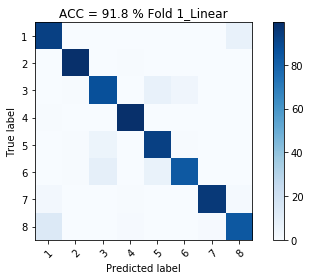

              precision    recall  f1-score   support

           1       0.85      0.93      0.89       285
           2       0.98      0.99      0.98       285
           3       0.86      0.87      0.86       285
           4       0.97      0.99      0.98       285
           5       0.87      0.93      0.90       285
           6       0.94      0.84      0.89       285
           7       0.98      0.95      0.97       285
           8       0.91      0.84      0.87       285

    accuracy                           0.92      2280
   macro avg       0.92      0.92      0.92      2280
weighted avg       0.92      0.92      0.92      2280

Guardando... LogisticRegression_Fold1


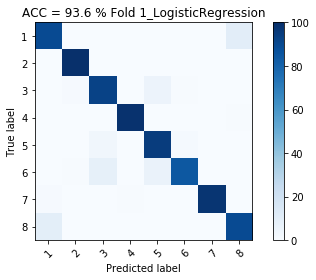

              precision    recall  f1-score   support

           1       0.89      0.90      0.89       285
           2       0.98      1.00      0.99       285
           3       0.89      0.93      0.91       285
           4       0.99      0.99      0.99       285
           5       0.89      0.95      0.92       285
           6       0.98      0.85      0.91       285
           7       1.00      0.98      0.99       285
           8       0.89      0.89      0.89       285

    accuracy                           0.94      2280
   macro avg       0.94      0.94      0.94      2280
weighted avg       0.94      0.94      0.94      2280

Guardando... LinearSVC_Fold1


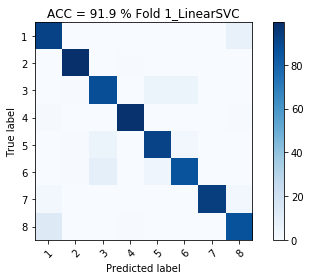

1it [3:28:05, 12485.91s/it]

              precision    recall  f1-score   support

           1       0.85      0.92      0.88       285
           2       0.98      0.99      0.99       285
           3       0.86      0.88      0.87       285
           4       0.98      0.98      0.98       285
           5       0.91      0.92      0.91       285
           6       0.91      0.86      0.88       285
           7       1.00      0.94      0.97       285
           8       0.88      0.86      0.87       285

    accuracy                           0.92      2280
   macro avg       0.92      0.92      0.92      2280
weighted avg       0.92      0.92      0.92      2280

Iteration =  2/10
Linear Model
Logistic Regression Model
Linear SVM Model
Guardando... Linear_Fold2


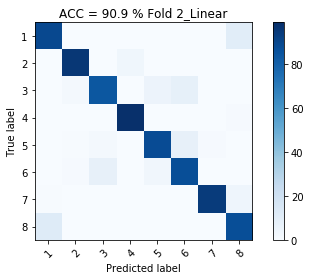

              precision    recall  f1-score   support

           1       0.87      0.89      0.88       285
           2       0.96      0.96      0.96       285
           3       0.90      0.84      0.87       285
           4       0.96      0.99      0.97       285
           5       0.91      0.88      0.90       285
           6       0.84      0.88      0.86       285
           7       0.99      0.94      0.97       285
           8       0.84      0.88      0.86       285

    accuracy                           0.91      2280
   macro avg       0.91      0.91      0.91      2280
weighted avg       0.91      0.91      0.91      2280

Guardando... LogisticRegression_Fold2


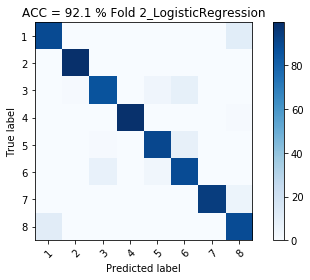

              precision    recall  f1-score   support

           1       0.89      0.89      0.89       285
           2       0.98      1.00      0.99       285
           3       0.91      0.86      0.88       285
           4       0.99      0.99      0.99       285
           5       0.92      0.91      0.91       285
           6       0.84      0.89      0.86       285
           7       1.00      0.94      0.97       285
           8       0.84      0.89      0.86       285

    accuracy                           0.92      2280
   macro avg       0.92      0.92      0.92      2280
weighted avg       0.92      0.92      0.92      2280

Guardando... LinearSVC_Fold2


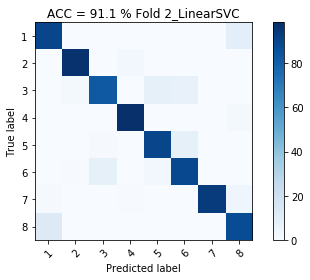

2it [6:55:36, 12475.28s/it]

              precision    recall  f1-score   support

           1       0.87      0.90      0.88       285
           2       0.97      0.97      0.97       285
           3       0.90      0.83      0.86       285
           4       0.97      0.98      0.97       285
           5       0.89      0.90      0.90       285
           6       0.85      0.89      0.87       285
           7       1.00      0.94      0.97       285
           8       0.84      0.87      0.86       285

    accuracy                           0.91      2280
   macro avg       0.91      0.91      0.91      2280
weighted avg       0.91      0.91      0.91      2280

Iteration =  3/10
Linear Model
Logistic Regression Model
Linear SVM Model
Guardando... Linear_Fold3


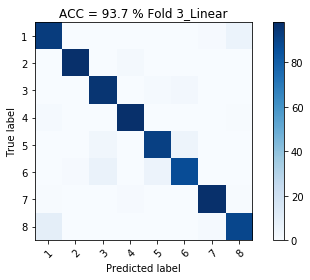

              precision    recall  f1-score   support

           1       0.89      0.93      0.91       285
           2       0.99      0.98      0.98       285
           3       0.91      0.96      0.93       285
           4       0.97      0.98      0.98       285
           5       0.93      0.92      0.92       285
           6       0.92      0.87      0.90       285
           7       0.97      0.98      0.97       285
           8       0.92      0.89      0.91       285

    accuracy                           0.94      2280
   macro avg       0.94      0.94      0.94      2280
weighted avg       0.94      0.94      0.94      2280

Guardando... LogisticRegression_Fold3


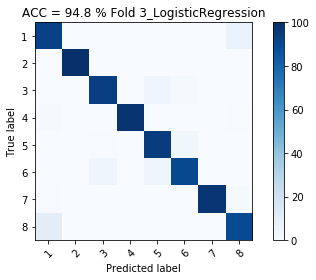

              precision    recall  f1-score   support

           1       0.89      0.93      0.91       285
           2       0.99      1.00      0.99       285
           3       0.95      0.94      0.94       285
           4       1.00      0.98      0.99       285
           5       0.92      0.95      0.93       285
           6       0.95      0.91      0.92       285
           7       1.00      0.98      0.99       285
           8       0.91      0.90      0.90       285

    accuracy                           0.95      2280
   macro avg       0.95      0.95      0.95      2280
weighted avg       0.95      0.95      0.95      2280

Guardando... LinearSVC_Fold3


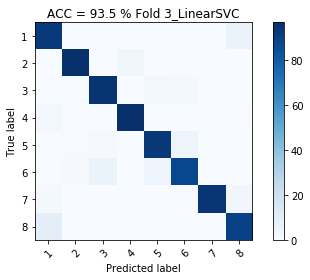

3it [10:55:19, 13047.57s/it]

              precision    recall  f1-score   support

           1       0.87      0.93      0.90       285
           2       0.98      0.97      0.98       285
           3       0.93      0.95      0.94       285
           4       0.96      0.96      0.96       285
           5       0.93      0.94      0.93       285
           6       0.93      0.88      0.90       285
           7       0.99      0.94      0.97       285
           8       0.90      0.90      0.90       285

    accuracy                           0.94      2280
   macro avg       0.94      0.94      0.94      2280
weighted avg       0.94      0.94      0.94      2280

Iteration =  4/10
Linear Model
Logistic Regression Model
Linear SVM Model
Guardando... Linear_Fold4


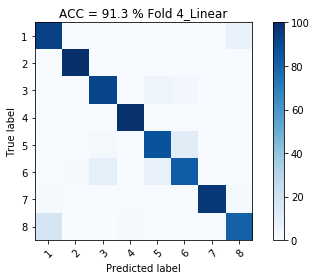

              precision    recall  f1-score   support

           1       0.83      0.93      0.88       285
           2       0.98      1.00      0.99       285
           3       0.89      0.92      0.90       285
           4       0.98      0.99      0.98       285
           5       0.88      0.87      0.87       285
           6       0.86      0.82      0.84       285
           7       1.00      0.96      0.98       285
           8       0.90      0.81      0.85       285

    accuracy                           0.91      2280
   macro avg       0.91      0.91      0.91      2280
weighted avg       0.91      0.91      0.91      2280

Guardando... LogisticRegression_Fold4


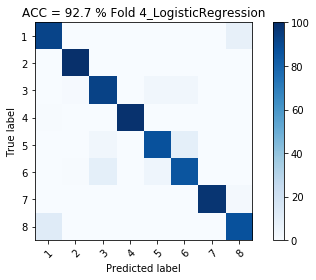

              precision    recall  f1-score   support

           1       0.88      0.92      0.90       285
           2       0.98      1.00      0.99       285
           3       0.88      0.93      0.90       285
           4       0.99      0.99      0.99       285
           5       0.92      0.87      0.90       285
           6       0.87      0.86      0.87       285
           7       1.00      0.98      0.99       285
           8       0.90      0.87      0.88       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LinearSVC_Fold4


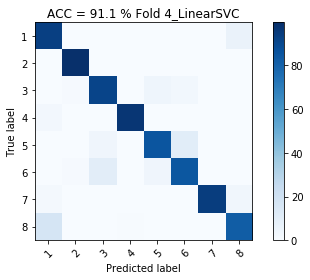

4it [14:22:59, 12871.33s/it]

              precision    recall  f1-score   support

           1       0.81      0.94      0.87       285
           2       0.98      1.00      0.99       285
           3       0.86      0.92      0.89       285
           4       0.99      0.97      0.98       285
           5       0.91      0.85      0.88       285
           6       0.86      0.85      0.85       285
           7       1.00      0.94      0.97       285
           8       0.89      0.82      0.86       285

    accuracy                           0.91      2280
   macro avg       0.91      0.91      0.91      2280
weighted avg       0.91      0.91      0.91      2280

Iteration =  5/10
Linear Model
Logistic Regression Model
Linear SVM Model
Guardando... Linear_Fold5


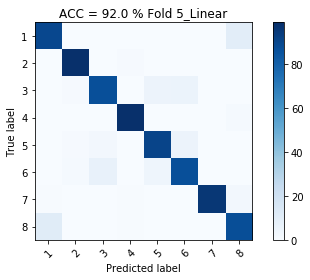

              precision    recall  f1-score   support

           1       0.88      0.90      0.89       285
           2       0.97      0.99      0.98       285
           3       0.90      0.87      0.89       285
           4       0.98      0.99      0.98       285
           5       0.90      0.91      0.90       285
           6       0.88      0.87      0.88       285
           7       1.00      0.96      0.98       285
           8       0.86      0.88      0.87       285

    accuracy                           0.92      2280
   macro avg       0.92      0.92      0.92      2280
weighted avg       0.92      0.92      0.92      2280

Guardando... LogisticRegression_Fold5


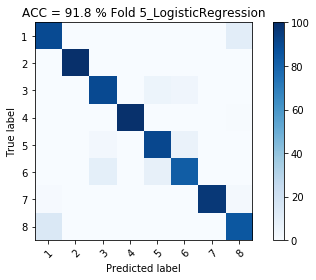

              precision    recall  f1-score   support

           1       0.85      0.90      0.87       285
           2       0.99      1.00      1.00       285
           3       0.89      0.90      0.89       285
           4       0.99      0.99      0.99       285
           5       0.87      0.91      0.89       285
           6       0.89      0.83      0.86       285
           7       1.00      0.97      0.98       285
           8       0.87      0.85      0.86       285

    accuracy                           0.92      2280
   macro avg       0.92      0.92      0.92      2280
weighted avg       0.92      0.92      0.92      2280

Guardando... LinearSVC_Fold5


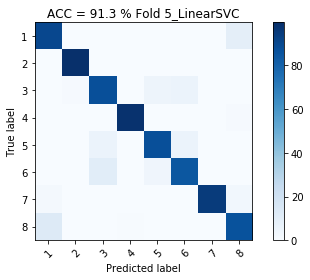

5it [17:57:02, 12862.86s/it]

              precision    recall  f1-score   support

           1       0.86      0.91      0.88       285
           2       0.98      1.00      0.99       285
           3       0.84      0.88      0.86       285
           4       0.99      0.99      0.99       285
           5       0.91      0.88      0.89       285
           6       0.88      0.85      0.86       285
           7       1.00      0.95      0.97       285
           8       0.87      0.87      0.87       285

    accuracy                           0.91      2280
   macro avg       0.91      0.91      0.91      2280
weighted avg       0.91      0.91      0.91      2280

Iteration =  6/10
Linear Model
Logistic Regression Model
Linear SVM Model
Guardando... Linear_Fold6


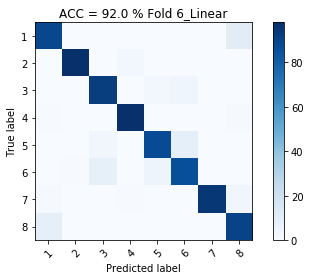

              precision    recall  f1-score   support

           1       0.89      0.89      0.89       285
           2       0.99      0.98      0.98       285
           3       0.89      0.93      0.91       285
           4       0.96      0.98      0.97       285
           5       0.92      0.87      0.89       285
           6       0.87      0.86      0.87       285
           7       0.99      0.95      0.97       285
           8       0.86      0.91      0.88       285

    accuracy                           0.92      2280
   macro avg       0.92      0.92      0.92      2280
weighted avg       0.92      0.92      0.92      2280

Guardando... LogisticRegression_Fold6


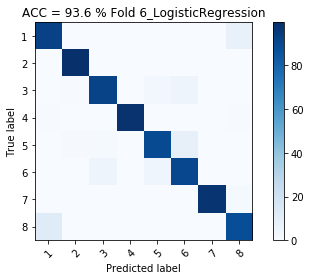

              precision    recall  f1-score   support

           1       0.88      0.93      0.90       285
           2       0.98      1.00      0.99       285
           3       0.94      0.92      0.93       285
           4       0.99      0.98      0.99       285
           5       0.92      0.89      0.91       285
           6       0.87      0.91      0.89       285
           7       1.00      0.98      0.99       285
           8       0.91      0.88      0.89       285

    accuracy                           0.94      2280
   macro avg       0.94      0.94      0.94      2280
weighted avg       0.94      0.94      0.94      2280

Guardando... LinearSVC_Fold6


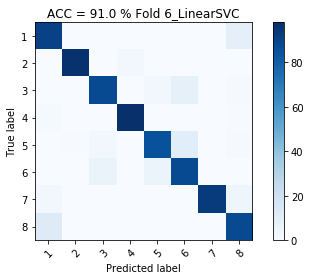

6it [21:24:50, 12744.37s/it]

              precision    recall  f1-score   support

           1       0.85      0.91      0.88       285
           2       0.99      0.97      0.98       285
           3       0.91      0.88      0.89       285
           4       0.97      0.98      0.97       285
           5       0.91      0.85      0.88       285
           6       0.83      0.88      0.85       285
           7       1.00      0.94      0.97       285
           8       0.85      0.88      0.86       285

    accuracy                           0.91      2280
   macro avg       0.91      0.91      0.91      2280
weighted avg       0.91      0.91      0.91      2280

Iteration =  7/10
Linear Model
Logistic Regression Model
Linear SVM Model
Guardando... Linear_Fold7


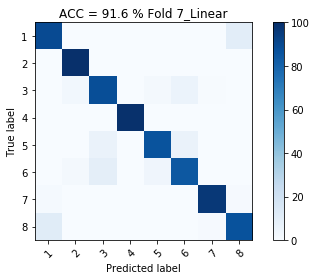

              precision    recall  f1-score   support

           1       0.87      0.90      0.88       285
           2       0.95      1.00      0.97       285
           3       0.85      0.88      0.87       285
           4       0.99      0.99      0.99       285
           5       0.93      0.87      0.90       285
           6       0.87      0.85      0.86       285
           7       0.98      0.97      0.97       285
           8       0.88      0.87      0.88       285

    accuracy                           0.92      2280
   macro avg       0.92      0.92      0.92      2280
weighted avg       0.92      0.92      0.92      2280

Guardando... LogisticRegression_Fold7


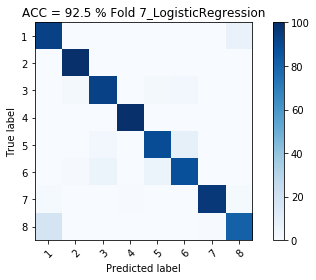

              precision    recall  f1-score   support

           1       0.83      0.93      0.88       285
           2       0.97      1.00      0.98       285
           3       0.92      0.93      0.92       285
           4       0.99      1.00      0.99       285
           5       0.92      0.89      0.91       285
           6       0.88      0.88      0.88       285
           7       0.99      0.96      0.98       285
           8       0.90      0.81      0.85       285

    accuracy                           0.92      2280
   macro avg       0.93      0.92      0.92      2280
weighted avg       0.93      0.92      0.92      2280

Guardando... LinearSVC_Fold7


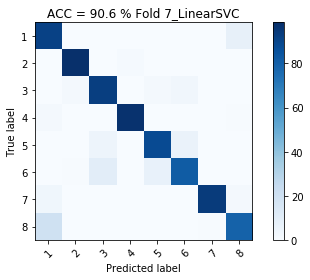

7it [24:52:11, 12653.43s/it]

              precision    recall  f1-score   support

           1       0.79      0.92      0.85       285
           2       0.97      0.99      0.98       285
           3       0.86      0.93      0.89       285
           4       0.98      0.98      0.98       285
           5       0.91      0.88      0.90       285
           6       0.90      0.82      0.86       285
           7       0.99      0.94      0.96       285
           8       0.88      0.80      0.84       285

    accuracy                           0.91      2280
   macro avg       0.91      0.91      0.91      2280
weighted avg       0.91      0.91      0.91      2280

Iteration =  8/10
Linear Model
Logistic Regression Model
Linear SVM Model
Guardando... Linear_Fold8


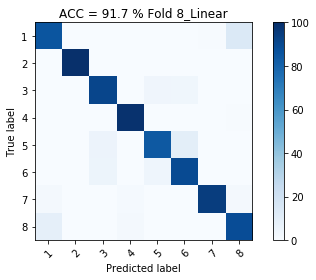

              precision    recall  f1-score   support

           1       0.88      0.86      0.87       285
           2       0.99      1.00      1.00       285
           3       0.89      0.92      0.90       285
           4       0.97      0.99      0.98       285
           5       0.91      0.84      0.87       285
           6       0.87      0.90      0.88       285
           7       0.99      0.95      0.97       285
           8       0.84      0.89      0.86       285

    accuracy                           0.92      2280
   macro avg       0.92      0.92      0.92      2280
weighted avg       0.92      0.92      0.92      2280

Guardando... LogisticRegression_Fold8


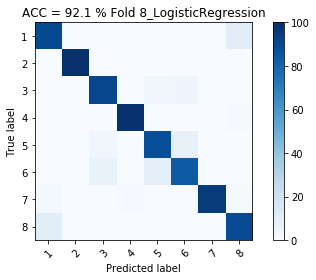

              precision    recall  f1-score   support

           1       0.87      0.90      0.89       285
           2       1.00      1.00      1.00       285
           3       0.89      0.91      0.90       285
           4       0.99      0.99      0.99       285
           5       0.87      0.88      0.88       285
           6       0.87      0.84      0.85       285
           7       1.00      0.95      0.98       285
           8       0.88      0.89      0.88       285

    accuracy                           0.92      2280
   macro avg       0.92      0.92      0.92      2280
weighted avg       0.92      0.92      0.92      2280

Guardando... LinearSVC_Fold8


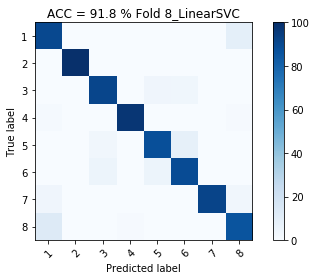

8it [28:21:45, 12629.68s/it]

              precision    recall  f1-score   support

           1       0.83      0.91      0.87       285
           2       0.99      1.00      1.00       285
           3       0.91      0.92      0.91       285
           4       0.99      0.98      0.98       285
           5       0.90      0.88      0.89       285
           6       0.88      0.89      0.89       285
           7       1.00      0.92      0.96       285
           8       0.86      0.86      0.86       285

    accuracy                           0.92      2280
   macro avg       0.92      0.92      0.92      2280
weighted avg       0.92      0.92      0.92      2280

Iteration =  9/10
Linear Model
Logistic Regression Model
Linear SVM Model
Guardando... Linear_Fold9


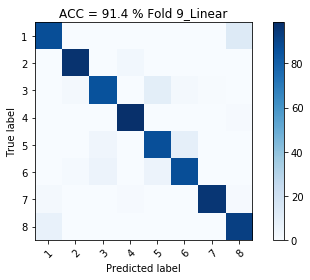

              precision    recall  f1-score   support

           1       0.90      0.87      0.89       285
           2       0.96      0.97      0.97       285
           3       0.90      0.86      0.88       285
           4       0.96      0.99      0.97       285
           5       0.85      0.87      0.86       285
           6       0.89      0.87      0.88       285
           7       0.99      0.96      0.98       285
           8       0.86      0.93      0.89       285

    accuracy                           0.91      2280
   macro avg       0.91      0.91      0.91      2280
weighted avg       0.91      0.91      0.91      2280

Guardando... LogisticRegression_Fold9


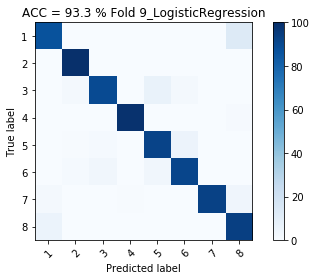

              precision    recall  f1-score   support

           1       0.92      0.87      0.89       285
           2       0.96      1.00      0.98       285
           3       0.95      0.89      0.92       285
           4       0.99      0.99      0.99       285
           5       0.90      0.92      0.91       285
           6       0.93      0.92      0.92       285
           7       1.00      0.93      0.97       285
           8       0.84      0.94      0.89       285

    accuracy                           0.93      2280
   macro avg       0.94      0.93      0.93      2280
weighted avg       0.94      0.93      0.93      2280

Guardando... LinearSVC_Fold9


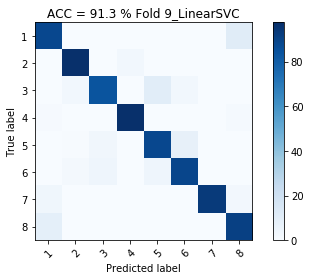

9it [31:46:46, 12531.10s/it]

              precision    recall  f1-score   support

           1       0.87      0.89      0.88       285
           2       0.95      0.97      0.96       285
           3       0.92      0.84      0.88       285
           4       0.97      0.98      0.97       285
           5       0.85      0.88      0.87       285
           6       0.89      0.89      0.89       285
           7       1.00      0.94      0.97       285
           8       0.86      0.91      0.88       285

    accuracy                           0.91      2280
   macro avg       0.91      0.91      0.91      2280
weighted avg       0.91      0.91      0.91      2280

Iteration =  10/10
Linear Model
Logistic Regression Model
Linear SVM Model
Guardando... Linear_Fold10


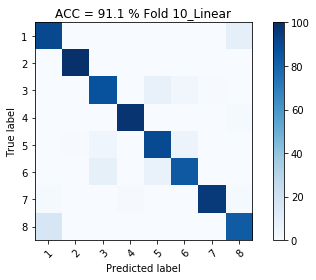

              precision    recall  f1-score   support

           1       0.84      0.91      0.87       285
           2       0.98      1.00      0.99       285
           3       0.87      0.87      0.87       285
           4       0.98      0.98      0.98       285
           5       0.86      0.89      0.88       285
           6       0.90      0.84      0.87       285
           7       0.99      0.96      0.97       285
           8       0.88      0.83      0.85       285

    accuracy                           0.91      2280
   macro avg       0.91      0.91      0.91      2280
weighted avg       0.91      0.91      0.91      2280

Guardando... LogisticRegression_Fold10


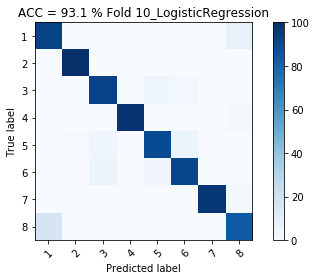

              precision    recall  f1-score   support

           1       0.85      0.93      0.88       285
           2       0.99      1.00      0.99       285
           3       0.90      0.93      0.92       285
           4       1.00      0.98      0.99       285
           5       0.92      0.89      0.91       285
           6       0.92      0.91      0.92       285
           7       1.00      0.97      0.99       285
           8       0.88      0.84      0.86       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LinearSVC_Fold10


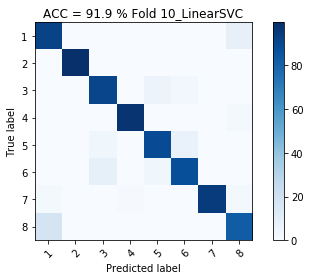

10it [35:14:27, 12686.79s/it]

              precision    recall  f1-score   support

           1       0.83      0.92      0.87       285
           2       0.99      1.00      0.99       285
           3       0.88      0.91      0.90       285
           4       0.99      0.98      0.98       285
           5       0.90      0.89      0.90       285
           6       0.91      0.88      0.89       285
           7       1.00      0.95      0.97       285
           8       0.87      0.82      0.85       285

    accuracy                           0.92      2280
   macro avg       0.92      0.92      0.92      2280
weighted avg       0.92      0.92      0.92      2280



In [ ]:
# Traininig/Testing loop

for train_index, test_index in tqdm(sss.split(X,y)):
# for train_index, test_index in tqdm(logo.split(X, y, groups)):
    # Training/testing index storage
    train_idx += [train_index]
    test_idx  += [test_index]
    
    # Number of partitions flag
    fold = fold + 1
    print("Iteration = ", str(fold) +'/'+ str(n_partitions))
#     print("Iteration = ", str(fold) +'/'+ str(logo.get_n_splits(X, y, groups = groups)))
    
    # Iteration file name 
    filename = img_path + "/Fold" + str(fold)
    
    # Train/Test 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # ---------------------------------------------------------------------------------------------------------------------------
    # Training
    
    
    # Linear
    print('Linear Model')
    # Using GridSearchCV 
#     hs_Lineal = GridSearchCV(Pipeline(steps[0]), parameters[0], n_jobs = 20, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_Lineal = RandomizedSearchCV(Pipeline(steps[0]), param_distributions=parameters[0],n_iter=10, cv=3, iid=False, n_jobs=25)
    hs_Lineal.fit(X_train,y_train)
    nfeats_L     += [hs_Lineal.best_estimator_.named_steps['FeatureSelectnRel'].n_features_to_select]
    sel_fts_L    += [hs_Lineal.best_estimator_.named_steps['FeatureSelectnRel'].top_features_]
    scores_rlff_L+= [hs_Lineal.best_estimator_.named_steps['FeatureSelectnRel'].feature_importances_]


    # Logistic Regression
    print('Logistic Regression Model')
    # Usaing GridSearchCV 
#     hs_LogR = GridSearchCV(Pipeline(steps[1]), parameters[1], n_jobs = 20, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_LogR = RandomizedSearchCV(Pipeline(steps[1]), param_distributions=parameters[1],n_iter=10, cv=3, iid=False,n_jobs=25)
    hs_LogR.fit(X_train,y_train)
    # Features selected by ReliefF method
    nfeats_LogR     += [hs_LogR.best_estimator_.named_steps['FeatureSelectnRel'].n_features_to_select]
    sel_fts_LogR    += [hs_LogR.best_estimator_.named_steps['FeatureSelectnRel'].top_features_]
    scores_rlff_LogR+= [hs_LogR.best_estimator_.named_steps['FeatureSelectnRel'].feature_importances_]
  

    # Linear SVM
    print('Linear SVM Model')
    # Using GridSearchCV 
#     hs_lSVM = GridSearchCV(Pipeline(steps[2]), parameters[2], n_jobs = 20, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_lSVM = RandomizedSearchCV(Pipeline(steps[2]), param_distributions=parameters[2],n_iter=10, cv=3, iid=False, n_jobs=25)  
#     hs_lSVM.fit(X_train,y_train,cv_groups)
    hs_lSVM.fit(X_train,y_train)
    # Features selected by ReliefF method
    nfeats_lSVM     += [hs_lSVM.best_estimator_.named_steps['FeatureSelectnRel'].n_features_to_select]
    sel_fts_lSVM    += [hs_lSVM.best_estimator_.named_steps['FeatureSelectnRel'].top_features_]
    scores_rlff_lSVM+= [hs_lSVM.best_estimator_.named_steps['FeatureSelectnRel'].feature_importances_]

    # ---------------------------------------------------------------------------------------------------------------------------
    # Validation
    
    # Linear
    y_pred_L           = hs_Lineal.best_estimator_.predict(X_test)
    accuracy_L[fold-1] = accuracy_score(y_test,y_pred_L)
    cm_temp            = confusion_matrix(y_test,y_pred_L)
    cm_L[fold-1,:,:]   = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_L, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_L[fold-1],fold) + '_'+ label_models[0])
    plt.autoscale()
    save_fig(img_path,label_models[0]+'_Fold'+str(fold))                      
    plt.show()
    cr_L += [classification_report(y_test,y_pred_L)]
    print(cr_L[-1])
    # Best model storage
    # best_mod_L += [hs_Lineal.best_estimator_, accuracy_L,cm_L,cr_L, sel_fts_L]
    # best_mod_L += [hs_Lineal.best_estimator_]
    best_pms_L += [hs_Lineal.best_params_]


    # Logistic Regression
    y_pred_LogR          = hs_LogR.best_estimator_.predict(X_test)
    accuracy_LogR[fold-1]= accuracy_score(y_test,y_pred_LogR)
    cm_temp              = confusion_matrix(y_test,y_pred_LogR)
    cm_LogR[fold-1,:,:]  = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_LogR, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_LogR[fold-1],fold) + '_'+ label_models[1])
    plt.autoscale()
    save_fig(img_path,label_models[1]+'_Fold'+str(fold))                      
    plt.show()
    cr_LogR += [classification_report(y_test,y_pred_LogR)]
    print(cr_LogR[-1])
    # Best model storage
    # best_mod_LogR += [hs_LogR.best_estimator_, accuracy_LogR,cm_LogR,cr_LogR, sel_fts_LogR]
    # best_mod_LogR += [hs_LogR.best_estimator_]
    best_pms_LogR += [hs_LogR.best_params_]

    # Linear SVM
    y_pred_lSVM          = hs_lSVM.best_estimator_.predict(X_test)
    accuracy_lSVM[fold-1]= accuracy_score(y_test,y_pred_lSVM)
    cm_temp              = confusion_matrix(y_test,y_pred_lSVM)
    cm_lSVM[fold-1,:,:]  = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_lSVM, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_lSVM[fold-1],fold) + '_'+ label_models[2])
    plt.autoscale()
    save_fig(img_path,label_models[2]+'_Fold'+str(fold))                      
    plt.show()
    cr_lSVM += [classification_report(y_test,y_pred_lSVM)]
    print(cr_lSVM[-1])
    # Best model storage
    # best_mod_lSVM += [hs_lSVM.best_estimator_, accuracy_lSVM,cm_lSVM,cr_lSVM, sel_fts_lSVM]
    # best_mod_lSVM += [hs_lSVM.best_estimator_]
    best_pms_lSVM += [hs_lSVM.best_params_]

    # Results dictionary creation
    L_dict = {'accuracy_L': accuracy_L,
              'cm_L': cm_L,
              'cr_L': cr_L,
              'sel_fts_L':sel_fts_L,
              'scores_rlff_L':scores_rlff_L,
              'nfeats_L': nfeats_L,
              'best_pms_L': best_pms_L }

    LogR_dict = {'accuracy_LogR': accuracy_LogR,
                'cm_LogR': cm_LogR,
                'cr_LogR': cr_LogR,
                'sel_fts_LogR':sel_fts_LogR,
                'scores_rlff_LogR':scores_rlff_LogR,
                'nfeats_LogR': nfeats_LogR,
                'best_pms_LogR': best_pms_LogR}

    lSVM_dict = {'accuracy_lSVM': accuracy_lSVM,
                'cm_lSVM': cm_lSVM,
                'cr_lSVM': cr_lSVM,
                'sel_fts_lSVM':sel_fts_lSVM,
                'scores_rlff_lSVM':scores_rlff_lSVM,
                'nfeats_lSVM': nfeats_lSVM,
                'best_pms_lSVM': best_pms_lSVM}

    Results = [L_dict, LogR_dict, lSVM_dict]

    joblib.dump(Results, rslt_dir + "Fold" + str(fold) + ".pkl")

The number of features is reported according to the best feature selection result

In [ ]:
n_folds     = 10
hist_ftr_vec= np.zeros((len(Results),len(list(Results[0].values())[3][0])))
mean_ftr_vec= np.zeros((10,1))

# Loop to run over results lists:
for i in range(0,len(Results)):
    # Matrix creation to count feature appearances
    temp_matrix = np.zeros((n_folds,len(list(Results[i].values())[3][0])))
    # Loop to iterate over dictionary entries:
    for l in Results[i]:
        # Loop to run over list of selected features:
        for j in range(0,n_folds):
            if l == 'sel_fts_L' or l == 'sel_fts_LogR' or l == 'sel_fts_lSVM':
                temp_vec    = Results[i][l][j][0:list(Results[i].values())[5][j]]
                temp_matrix[j][temp_vec] = 1
                # Vector of feature appearances
                hist_ftr_vec[i][:] = np.sum(temp_matrix,axis = 0)
                mean_ftr_vec[i]    = np.mean(Results[i][l])
    
# Printing results:
print('Linear Classifier')
print(str(np.mean(np.array(Results[0]['accuracy_L']))*100) + '+/-' + str(np.std(np.array(Results[0]['accuracy_L']))*100))
print('Number of features = ' + str(mean_ftr_vec[0]))

print('Logistic Regression Classifier')
print(str(np.mean(np.array(Results[1]['accuracy_LogR']))*100) + '+/-' + str(np.std(np.array(Results[1]['accuracy_LogR']))*100))
print('Number of features = ' + str(mean_ftr_vec[1]))

print('Linear SVM Classifier')
print(str(np.mean(np.array(Results[2]['accuracy_lSVM']))*100) + '+/-' + str(np.std(np.array(Results[2]['accuracy_lSVM']))*100))
print('Number of features = ' + str(mean_ftr_vec[2]))

Linear Classifier
91.75877192982455+/-0.7415913155410686
Number of features = [15749.5]
Logistic Regression Classifier
92.96052631578947+/-0.8657699210362579
Number of features = [15749.5]
Linear SVM Classifier
91.55263157894737+/-0.77028333177049
Number of features = [15749.5]


In [ ]:
from scipy.spatial.distance import cdist
# Ideal Result
Target       = np.array((100,0,0))
# Computing the minimum distance between the ideal result and our results
dist         = cdist(Target.reshape(1,-1),np.array(([np.mean(np.array(Results[0]['accuracy_L']))*100,np.std(np.array(Results[0]['accuracy_L']))*100,9675/31500],[np.mean(np.array(Results[1]['accuracy_LogR']))*100,np.std(np.array(Results[1]['accuracy_LogR']))*100,9225/31500],[np.mean(np.array(Results[2]['accuracy_lSVM']))*100,np.std(np.array(Results[2]['accuracy_lSVM']))*100,9375/31500])), 'euclidean')
print(dist)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Region-based histogram building

In [ ]:
n_regions    = 21
G            = 1500           # Number of cetroid from BoCF dictionary learning
expected_feat= G*n_partitions # Expected number of features per region and fold
size         = len(list(Results[0].values())[3][0])
features     = np.arange(1,size+1,1)
region_vec   = np.arange(0,n_regions+1)*G
hist_region  = np.zeros((n_regions,10))
hist_region_s= np.zeros((n_regions,10))
region_vec_p = np.arange(1,n_regions+1)
hist_ftr_mat = np.concatenate((hist_ftr_vec,features.reshape(size,1).T),axis = 0).T
# Histogram with prunning
idx                 = hist_ftr_vec >= 6 
hist_ftr_vec_sampled= np.where(idx,hist_ftr_vec,hist_ftr_vec*0)
hist_ftr_mat_sampled= np.concatenate((hist_ftr_vec_sampled,features.reshape(size,1).T),axis = 0).T
# Now, histograms per region are obtained
for i in range(0,len(region_vec)-1):
  for j in range(0,hist_ftr_mat.shape[1]-1):          
      hist_region[i,j]  = np.sum(hist_ftr_mat[region_vec[i]:region_vec[i+1],j])/expected_feat
      hist_region_s[i,j]= np.sum(hist_ftr_mat_sampled[region_vec[i]:region_vec[i+1],j])/expected_feat

In [ ]:
# Storing data to plot histograms in Latex
    
# According to the values, are extracted the non-zero values
idx_nz     = np.argsort(-1*hist_ftr_vec[2,:])
hist_vec_nz= hist_ftr_vec[2,idx_nz]
# features_nz= features[idx_nz]
hist_mat_nz= np.concatenate((hist_vec_nz.reshape(features.shape[0],1).T,features.reshape(features.shape[0],1).T),axis = 0).T
np.savetxt(img_path + '/HistMatrix.dat', hist_mat_nz)

# For sampled histogram
idx_nz_s     = np.argsort(-1*hist_ftr_vec_sampled[2,:])
hist_vec_nz_s= hist_ftr_vec_sampled[2,idx_nz_s]
# features_nz_s= features[idx_nz_s]
hist_mat_nz_s= np.concatenate((hist_vec_nz_s.reshape(features.shape[0],1).T,features.reshape(features.shape[0],1).T),axis = 0).T
np.savetxt(img_path + '/HistMatrixSampled.dat', hist_mat_nz_s) 

Text(0.5, 0, 'Regions')

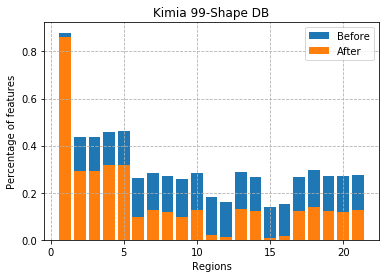

In [ ]:
# Plotting the histograms before and after apperance criteria is applied
plt.figure()
plt.title('Kimia 99-Shape DB')
plt.bar(region_vec_p,hist_region[:,1], label = 'Before')
plt.bar(region_vec_p,hist_region_s[:,1], label = 'After')
plt.legend()
plt.grid(linestyle='--')
plt.ylabel('Percentage of features')
plt.xlabel('Regions')

Feature selection indexing over the input matrix

In [ ]:
# Input matrix indexing
Xr = X
# Reduced matrix from feature selection indices
Xr = Xr[:,idx[1,:]]
Results = [hist_ftr_vec,hist_ftr_vec_sampled,Xr]
joblib.dump(Results, img_path + "ReductionSetResults"+ ".pkl")

['/home/jsblandon/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/ETH80_DB_Corrected/FeatureSelection/ETH80DB_BoCF_E_ResultsReductionSetResults.pkl']

# **Step 4: Centered Kernel Alignment projection**

Model description

In [ ]:
# Matrix declaration to store train/test matrices and their labels, and projection matrices from CKA
X_train_cka = []
X_test_cka  = []
y_train_cka = []
y_test_cka  = []
W_cka_L     = []
W_cka_LogR  = []
W_cka_lSVM  = []
    
# Step declaration
steps = [
        [('Preprocessing', StandardScaler()),
          ('Projection', MiniBatchCKA(Q = 0.95,batch = 80)),
          ('Preprocessing2',StandardScaler()),
          ('Classification',SGDClassifier())],      # Clasificador Lineal
        [('Preprocessing', StandardScaler()),
          ('Projection', MiniBatchCKA(Q = 0.95,batch = 80)),
          ('Preprocessing2',StandardScaler()),
          ('Classification',LogisticRegression())], # Regresion Logistica
        [('Preprocessing', StandardScaler()),
          ('Projection', MiniBatchCKA(Q = 0.95,batch = 80)),
          ('Preprocessing2',StandardScaler()),
          ('Classification',LinearSVC())],          # Maquina de Vectores de Soporte
        ]
    
# Grid declaration
parameters = [
            {'Classification__penalty': ['l1', 'l2', 'elasticnet'] },
            {'Classification__C': [0.01,0.1,1,10]},
            {'Classification__C': [0.1,1,10,100,1000]}
            ]

# Model labels
label_models = ['LinearCKA','LogisticRegressionCKA','LinearSVCKA']

In [ ]:
# Directory to save results and plots

rslt_dir     = img_dir + '/NLDR/ETH80_DB_CKA_Results/Results_CKA_NLDR_Py'
sys.path.append(rslt_dir)
img_path     = img_dir + '/NLDR/ETH80_DB_CKA_Results/'
sys.path.append(img_path)

Loop to optimize CKA projection



0it [00:00, ?it/s]

Iteration =  1/10
Linear Model
it:1/50---cost:-2.16e+00--- elapsed:6.22 [s]



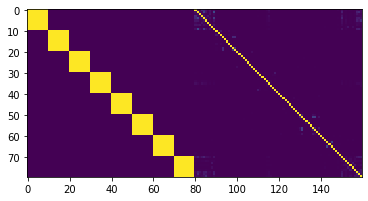

Logistic Regression Model
it:1/50---cost:-2.11e+00--- elapsed:6.27 [s]



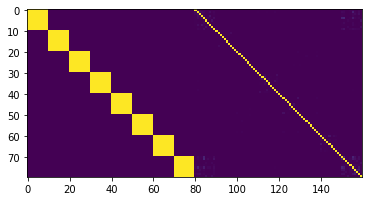

Linear SVM Model
it:1/50---cost:-2.11e+00--- elapsed:6.10 [s]



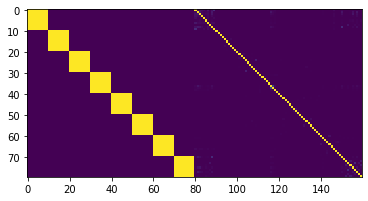

Guardando... LinearCKA_Fold1


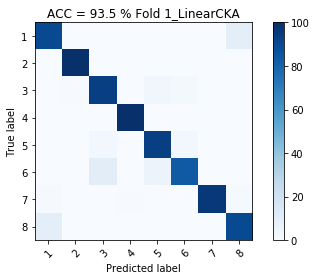

              precision    recall  f1-score   support

           1       0.89      0.90      0.90       285
           2       0.99      1.00      0.99       285
           3       0.88      0.94      0.91       285
           4       0.99      1.00      0.99       285
           5       0.91      0.94      0.93       285
           6       0.94      0.84      0.89       285
           7       1.00      0.97      0.98       285
           8       0.89      0.89      0.89       285

    accuracy                           0.94      2280
   macro avg       0.94      0.94      0.93      2280
weighted avg       0.94      0.94      0.93      2280

Guardando... LogisticRegressionCKA_Fold1


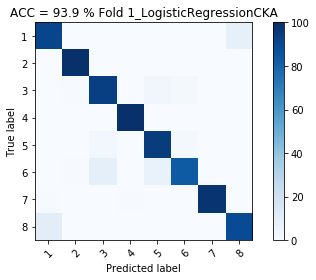

              precision    recall  f1-score   support

           1       0.89      0.92      0.90       285
           2       0.98      1.00      0.99       285
           3       0.89      0.94      0.91       285
           4       0.99      1.00      0.99       285
           5       0.91      0.95      0.93       285
           6       0.96      0.84      0.89       285
           7       1.00      0.98      0.99       285
           8       0.91      0.89      0.90       285

    accuracy                           0.94      2280
   macro avg       0.94      0.94      0.94      2280
weighted avg       0.94      0.94      0.94      2280

Guardando... LinearSVCKA_Fold1


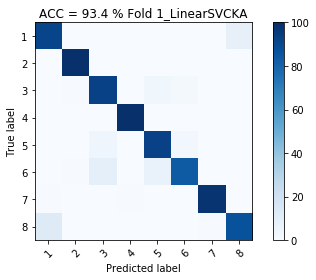

              precision    recall  f1-score   support

           1       0.88      0.92      0.90       285
           2       0.99      1.00      0.99       285
           3       0.88      0.93      0.90       285
           4       0.99      1.00      1.00       285
           5       0.90      0.93      0.92       285
           6       0.95      0.84      0.89       285
           7       0.99      0.98      0.99       285
           8       0.91      0.87      0.89       285

    accuracy                           0.93      2280
   macro avg       0.94      0.93      0.93      2280
weighted avg       0.94      0.93      0.93      2280





1it [03:09, 189.12s/it]

Iteration =  2/10
Linear Model
it:1/50---cost:-2.10e+00--- elapsed:6.41 [s]



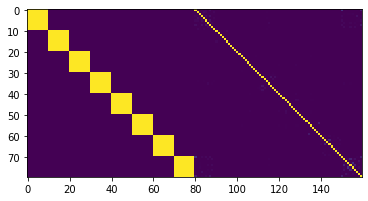

Logistic Regression Model
it:1/50---cost:-2.12e+00--- elapsed:6.36 [s]



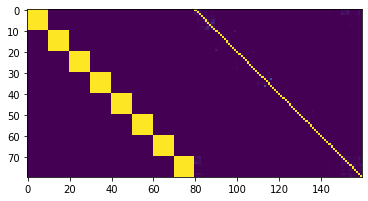

Linear SVM Model
it:1/50---cost:-2.12e+00--- elapsed:5.78 [s]



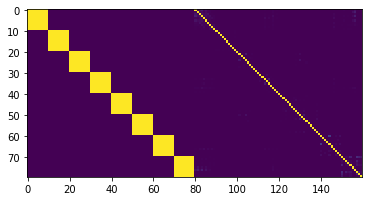

Guardando... LinearCKA_Fold2


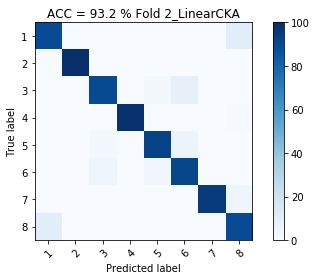

              precision    recall  f1-score   support

           1       0.89      0.89      0.89       285
           2       1.00      1.00      1.00       285
           3       0.93      0.89      0.91       285
           4       1.00      0.99      0.99       285
           5       0.94      0.93      0.93       285
           6       0.87      0.91      0.89       285
           7       1.00      0.95      0.98       285
           8       0.84      0.89      0.87       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LogisticRegressionCKA_Fold2


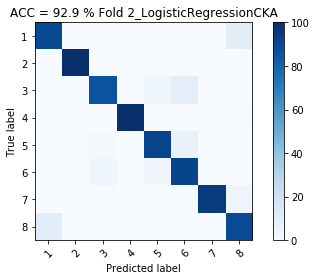

              precision    recall  f1-score   support

           1       0.89      0.89      0.89       285
           2       0.99      1.00      1.00       285
           3       0.93      0.86      0.90       285
           4       1.00      0.99      1.00       285
           5       0.93      0.92      0.92       285
           6       0.85      0.92      0.88       285
           7       1.00      0.95      0.98       285
           8       0.85      0.89      0.87       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LinearSVCKA_Fold2


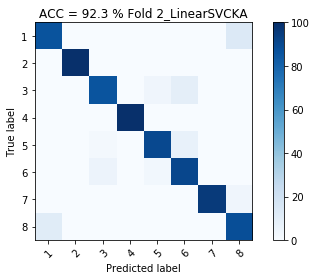

              precision    recall  f1-score   support

           1       0.88      0.87      0.87       285
           2       0.99      1.00      1.00       285
           3       0.92      0.86      0.89       285
           4       1.00      1.00      1.00       285
           5       0.93      0.91      0.92       285
           6       0.84      0.91      0.88       285
           7       1.00      0.96      0.98       285
           8       0.83      0.88      0.86       285

    accuracy                           0.92      2280
   macro avg       0.92      0.92      0.92      2280
weighted avg       0.92      0.92      0.92      2280





2it [06:28, 192.09s/it]

Iteration =  3/10
Linear Model
it:1/50---cost:-2.14e+00--- elapsed:6.15 [s]



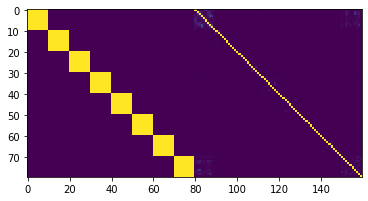

Logistic Regression Model
it:1/50---cost:-2.11e+00--- elapsed:5.71 [s]



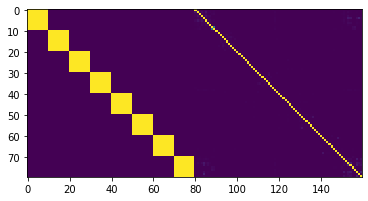

Linear SVM Model
it:1/50---cost:-2.10e+00--- elapsed:6.31 [s]



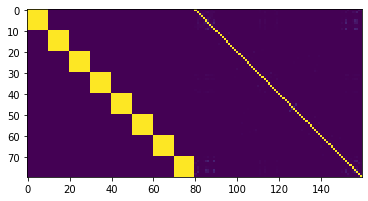

Guardando... LinearCKA_Fold3


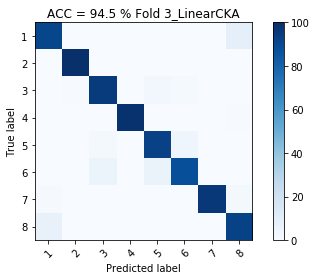

              precision    recall  f1-score   support

           1       0.91      0.91      0.91       285
           2       0.99      1.00      0.99       285
           3       0.93      0.95      0.94       285
           4       1.00      0.99      0.99       285
           5       0.91      0.93      0.92       285
           6       0.94      0.88      0.91       285
           7       1.00      0.97      0.98       285
           8       0.89      0.93      0.91       285

    accuracy                           0.95      2280
   macro avg       0.95      0.95      0.95      2280
weighted avg       0.95      0.95      0.95      2280

Guardando... LogisticRegressionCKA_Fold3


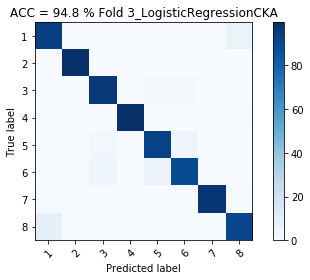

              precision    recall  f1-score   support

           1       0.91      0.94      0.92       285
           2       0.99      1.00      0.99       285
           3       0.93      0.96      0.94       285
           4       0.99      0.99      0.99       285
           5       0.92      0.92      0.92       285
           6       0.93      0.89      0.91       285
           7       1.00      0.97      0.99       285
           8       0.92      0.91      0.91       285

    accuracy                           0.95      2280
   macro avg       0.95      0.95      0.95      2280
weighted avg       0.95      0.95      0.95      2280

Guardando... LinearSVCKA_Fold3


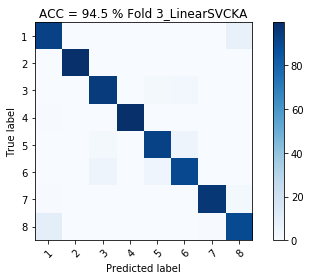

              precision    recall  f1-score   support

           1       0.89      0.93      0.91       285
           2       0.99      1.00      0.99       285
           3       0.93      0.95      0.94       285
           4       0.99      0.99      0.99       285
           5       0.93      0.93      0.93       285
           6       0.92      0.90      0.91       285
           7       0.99      0.97      0.98       285
           8       0.90      0.89      0.90       285

    accuracy                           0.94      2280
   macro avg       0.95      0.94      0.94      2280
weighted avg       0.95      0.94      0.94      2280





3it [10:01, 198.48s/it]

Iteration =  4/10
Linear Model
it:1/50---cost:-2.13e+00--- elapsed:6.79 [s]



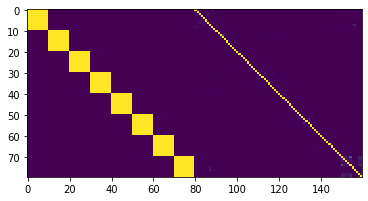

Logistic Regression Model
it:1/50---cost:-2.11e+00--- elapsed:6.37 [s]



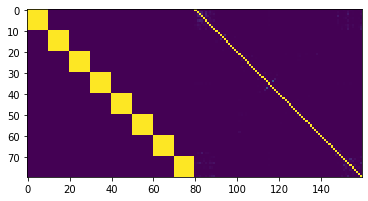

Linear SVM Model
it:1/50---cost:-2.10e+00--- elapsed:6.29 [s]



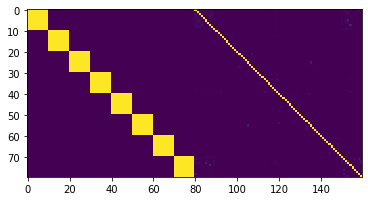

Guardando... LinearCKA_Fold4


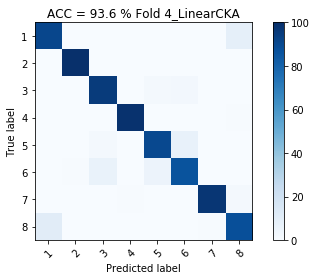

              precision    recall  f1-score   support

           1       0.89      0.91      0.90       285
           2       0.99      1.00      0.99       285
           3       0.92      0.95      0.93       285
           4       0.99      0.99      0.99       285
           5       0.92      0.91      0.91       285
           6       0.89      0.87      0.88       285
           7       0.99      0.98      0.98       285
           8       0.89      0.88      0.88       285

    accuracy                           0.94      2280
   macro avg       0.94      0.94      0.94      2280
weighted avg       0.94      0.94      0.94      2280

Guardando... LogisticRegressionCKA_Fold4


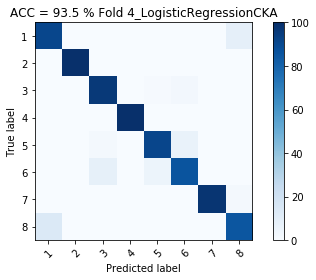

              precision    recall  f1-score   support

           1       0.87      0.91      0.89       285
           2       0.99      1.00      1.00       285
           3       0.90      0.96      0.93       285
           4       0.99      1.00      0.99       285
           5       0.94      0.92      0.93       285
           6       0.90      0.86      0.88       285
           7       1.00      0.98      0.99       285
           8       0.89      0.85      0.87       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LinearSVCKA_Fold4


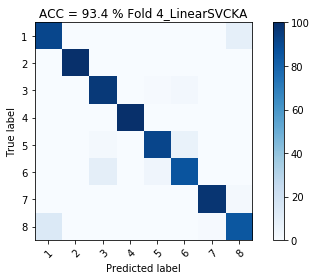

              precision    recall  f1-score   support

           1       0.87      0.91      0.89       285
           2       0.99      1.00      1.00       285
           3       0.90      0.96      0.93       285
           4       0.99      1.00      0.99       285
           5       0.95      0.92      0.93       285
           6       0.90      0.86      0.88       285
           7       0.99      0.98      0.98       285
           8       0.89      0.85      0.87       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280





4it [13:20, 198.57s/it]

Iteration =  5/10
Linear Model
it:1/50---cost:-2.11e+00--- elapsed:6.73 [s]



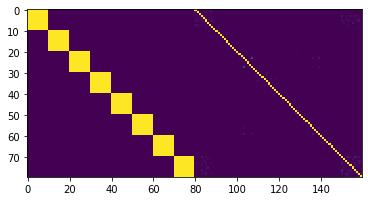

Logistic Regression Model
it:1/50---cost:-2.12e+00--- elapsed:6.73 [s]



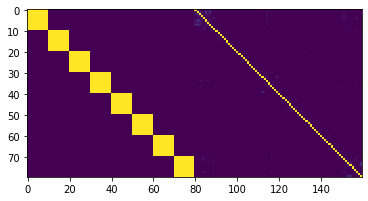

Linear SVM Model
it:1/50---cost:-2.12e+00--- elapsed:6.09 [s]



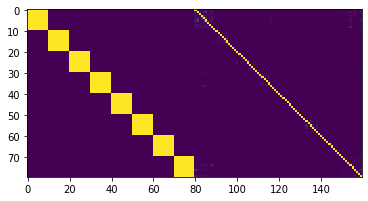

Guardando... LinearCKA_Fold5


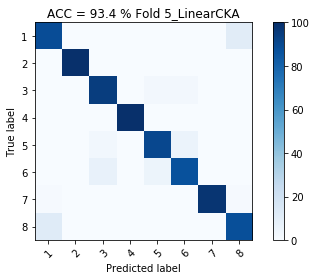

              precision    recall  f1-score   support

           1       0.87      0.89      0.88       285
           2       0.99      1.00      1.00       285
           3       0.90      0.95      0.92       285
           4       1.00      1.00      1.00       285
           5       0.92      0.91      0.92       285
           6       0.91      0.87      0.89       285
           7       1.00      0.98      0.99       285
           8       0.87      0.88      0.88       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LogisticRegressionCKA_Fold5


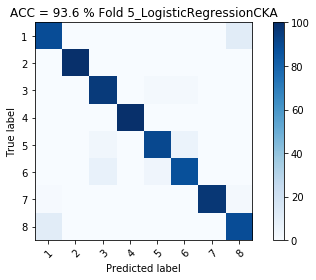

              precision    recall  f1-score   support

           1       0.88      0.89      0.88       285
           2       0.99      1.00      0.99       285
           3       0.90      0.96      0.93       285
           4       1.00      1.00      1.00       285
           5       0.94      0.91      0.92       285
           6       0.92      0.88      0.90       285
           7       1.00      0.97      0.99       285
           8       0.87      0.89      0.88       285

    accuracy                           0.94      2280
   macro avg       0.94      0.94      0.94      2280
weighted avg       0.94      0.94      0.94      2280

Guardando... LinearSVCKA_Fold5


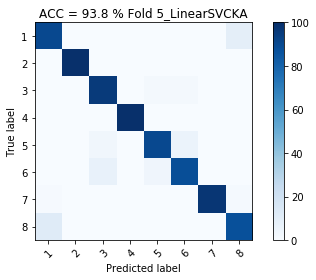

              precision    recall  f1-score   support

           1       0.87      0.91      0.89       285
           2       0.99      1.00      1.00       285
           3       0.90      0.96      0.93       285
           4       1.00      1.00      1.00       285
           5       0.94      0.91      0.92       285
           6       0.92      0.88      0.90       285
           7       1.00      0.98      0.99       285
           8       0.89      0.88      0.88       285

    accuracy                           0.94      2280
   macro avg       0.94      0.94      0.94      2280
weighted avg       0.94      0.94      0.94      2280





5it [16:45, 200.66s/it]

Iteration =  6/10
Linear Model
it:1/50---cost:-2.12e+00--- elapsed:6.72 [s]



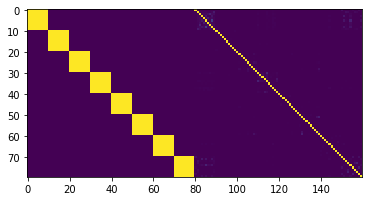

Logistic Regression Model
it:1/50---cost:-2.10e+00--- elapsed:6.18 [s]



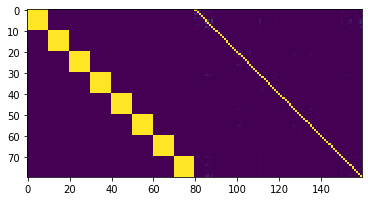

Linear SVM Model
it:1/50---cost:-2.10e+00--- elapsed:6.76 [s]



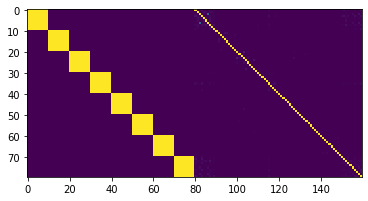

Guardando... LinearCKA_Fold6


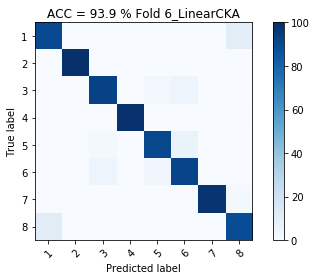

              precision    recall  f1-score   support

           1       0.88      0.90      0.89       285
           2       0.99      1.00      1.00       285
           3       0.93      0.93      0.93       285
           4       1.00      0.99      0.99       285
           5       0.94      0.91      0.92       285
           6       0.89      0.92      0.91       285
           7       1.00      0.98      0.99       285
           8       0.88      0.89      0.88       285

    accuracy                           0.94      2280
   macro avg       0.94      0.94      0.94      2280
weighted avg       0.94      0.94      0.94      2280

Guardando... LogisticRegressionCKA_Fold6


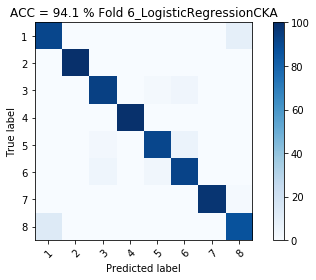

              precision    recall  f1-score   support

           1       0.87      0.91      0.89       285
           2       1.00      1.00      1.00       285
           3       0.93      0.94      0.93       285
           4       1.00      0.99      0.99       285
           5       0.95      0.91      0.93       285
           6       0.90      0.92      0.91       285
           7       1.00      0.98      0.99       285
           8       0.89      0.87      0.88       285

    accuracy                           0.94      2280
   macro avg       0.94      0.94      0.94      2280
weighted avg       0.94      0.94      0.94      2280

Guardando... LinearSVCKA_Fold6


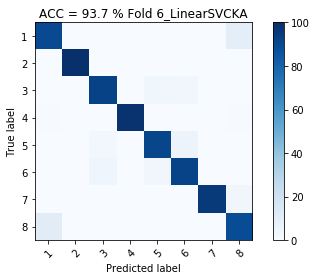

              precision    recall  f1-score   support

           1       0.88      0.90      0.89       285
           2       1.00      1.00      1.00       285
           3       0.93      0.93      0.93       285
           4       1.00      0.99      0.99       285
           5       0.93      0.91      0.92       285
           6       0.91      0.92      0.92       285
           7       1.00      0.96      0.98       285
           8       0.87      0.89      0.88       285

    accuracy                           0.94      2280
   macro avg       0.94      0.94      0.94      2280
weighted avg       0.94      0.94      0.94      2280





6it [20:12, 202.34s/it]

Iteration =  7/10
Linear Model
it:1/50---cost:-2.12e+00--- elapsed:6.69 [s]



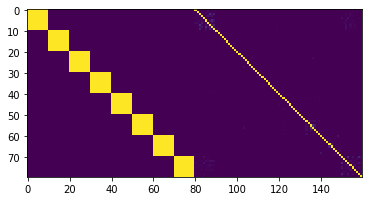

Logistic Regression Model
it:1/50---cost:-2.11e+00--- elapsed:6.59 [s]



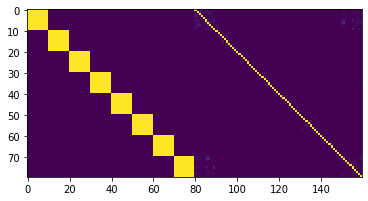

Linear SVM Model
it:1/50---cost:-2.12e+00--- elapsed:6.59 [s]



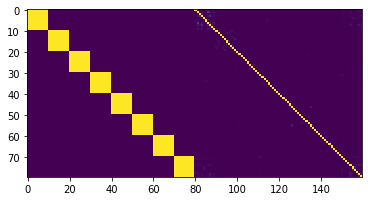

Guardando... LinearCKA_Fold7


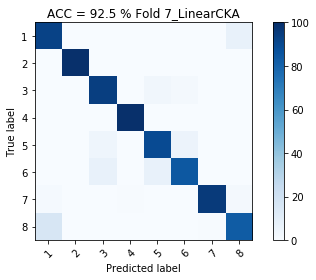

              precision    recall  f1-score   support

           1       0.84      0.93      0.88       285
           2       0.99      1.00      1.00       285
           3       0.89      0.94      0.91       285
           4       0.99      1.00      0.99       285
           5       0.89      0.90      0.89       285
           6       0.92      0.85      0.88       285
           7       0.99      0.96      0.98       285
           8       0.89      0.83      0.86       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.92      2280
weighted avg       0.93      0.93      0.92      2280

Guardando... LogisticRegressionCKA_Fold7


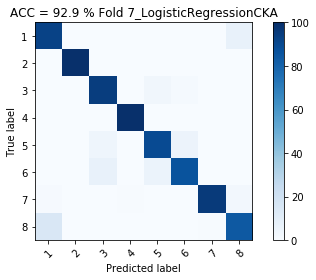

              precision    recall  f1-score   support

           1       0.85      0.93      0.89       285
           2       1.00      1.00      1.00       285
           3       0.89      0.95      0.92       285
           4       0.99      1.00      0.99       285
           5       0.91      0.90      0.90       285
           6       0.93      0.87      0.89       285
           7       0.99      0.96      0.98       285
           8       0.89      0.84      0.87       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LinearSVCKA_Fold7


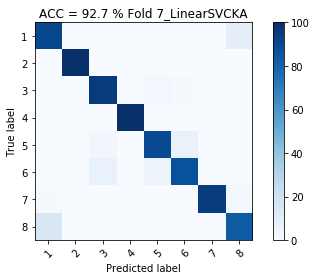

              precision    recall  f1-score   support

           1       0.85      0.91      0.88       285
           2       0.99      1.00      0.99       285
           3       0.91      0.95      0.93       285
           4       0.98      1.00      0.99       285
           5       0.92      0.90      0.91       285
           6       0.92      0.87      0.89       285
           7       0.99      0.95      0.97       285
           8       0.87      0.84      0.85       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280





7it [23:34, 202.40s/it]

Iteration =  8/10
Linear Model
it:1/50---cost:-2.11e+00--- elapsed:6.76 [s]



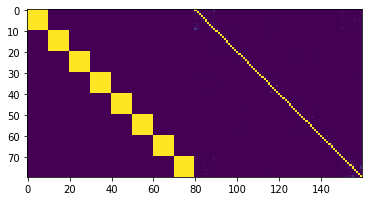

Logistic Regression Model
it:1/50---cost:-2.12e+00--- elapsed:6.19 [s]



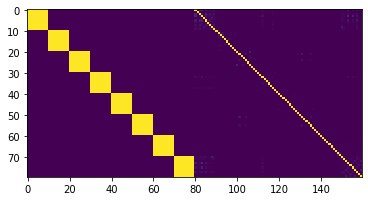

Linear SVM Model
it:1/50---cost:-2.10e+00--- elapsed:5.87 [s]



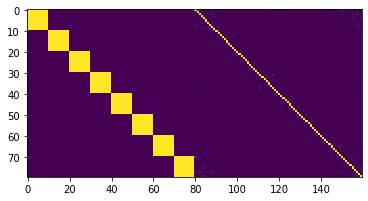

Guardando... LinearCKA_Fold8


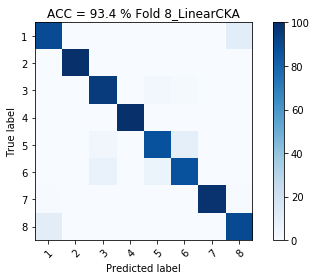

              precision    recall  f1-score   support

           1       0.89      0.89      0.89       285
           2       1.00      1.00      1.00       285
           3       0.90      0.95      0.93       285
           4       1.00      1.00      1.00       285
           5       0.92      0.87      0.89       285
           6       0.89      0.87      0.88       285
           7       1.00      0.99      0.99       285
           8       0.88      0.89      0.89       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LogisticRegressionCKA_Fold8


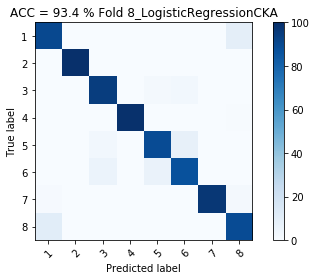

              precision    recall  f1-score   support

           1       0.88      0.91      0.89       285
           2       0.99      1.00      1.00       285
           3       0.92      0.95      0.93       285
           4       1.00      0.99      1.00       285
           5       0.91      0.89      0.90       285
           6       0.89      0.87      0.88       285
           7       1.00      0.97      0.99       285
           8       0.88      0.89      0.89       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LinearSVCKA_Fold8


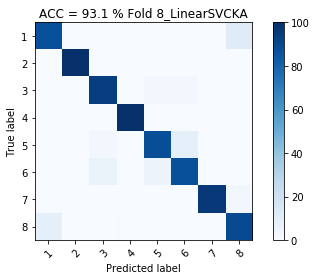

              precision    recall  f1-score   support

           1       0.90      0.88      0.89       285
           2       1.00      1.00      1.00       285
           3       0.91      0.94      0.93       285
           4       0.99      1.00      0.99       285
           5       0.91      0.88      0.90       285
           6       0.89      0.88      0.88       285
           7       1.00      0.96      0.98       285
           8       0.86      0.90      0.88       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280





8it [26:41, 197.65s/it]

Iteration =  9/10
Linear Model
it:1/50---cost:-2.11e+00--- elapsed:5.80 [s]



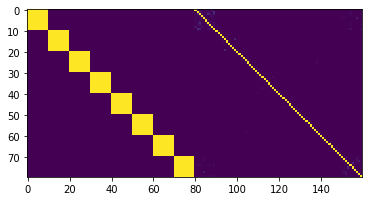

Logistic Regression Model
it:1/50---cost:-2.10e+00--- elapsed:5.85 [s]



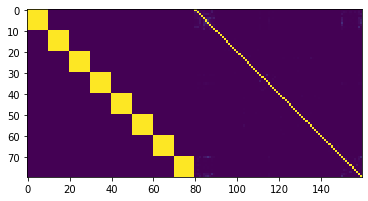

Linear SVM Model
it:1/50---cost:-2.10e+00--- elapsed:6.54 [s]



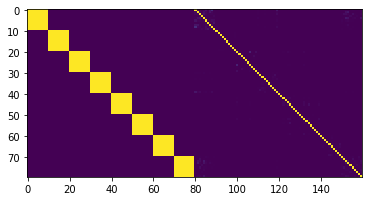

Guardando... LinearCKA_Fold9


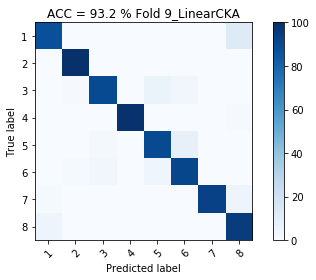

              precision    recall  f1-score   support

           1       0.93      0.88      0.90       285
           2       0.97      1.00      0.99       285
           3       0.95      0.89      0.92       285
           4       1.00      0.99      0.99       285
           5       0.90      0.90      0.90       285
           6       0.89      0.91      0.90       285
           7       1.00      0.93      0.97       285
           8       0.84      0.95      0.89       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LogisticRegressionCKA_Fold9


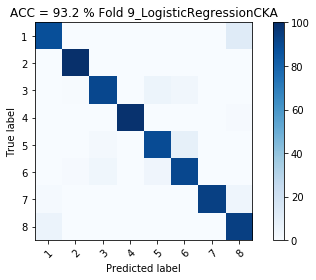

              precision    recall  f1-score   support

           1       0.92      0.88      0.90       285
           2       0.98      1.00      0.99       285
           3       0.94      0.91      0.92       285
           4       1.00      0.99      0.99       285
           5       0.90      0.89      0.90       285
           6       0.89      0.91      0.90       285
           7       1.00      0.94      0.97       285
           8       0.84      0.94      0.89       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LinearSVCKA_Fold9


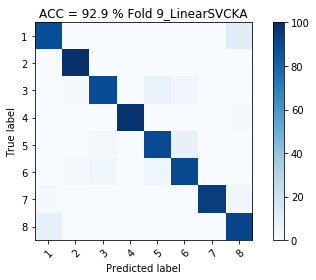

              precision    recall  f1-score   support

           1       0.91      0.88      0.89       285
           2       0.98      1.00      0.99       285
           3       0.94      0.89      0.91       285
           4       0.99      0.99      0.99       285
           5       0.89      0.90      0.89       285
           6       0.90      0.91      0.90       285
           7       1.00      0.95      0.97       285
           8       0.85      0.92      0.88       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280





9it [29:48, 194.65s/it]

Iteration =  10/10
Linear Model
it:1/50---cost:-2.12e+00--- elapsed:6.75 [s]



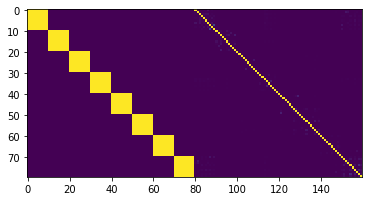

Logistic Regression Model
it:1/50---cost:-2.11e+00--- elapsed:6.75 [s]



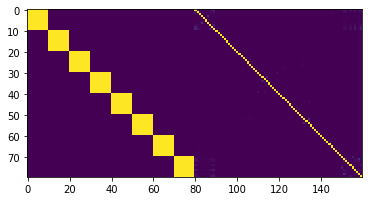

Linear SVM Model
it:1/50---cost:-2.13e+00--- elapsed:6.28 [s]



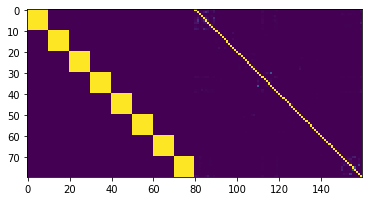

Guardando... LinearCKA_Fold10


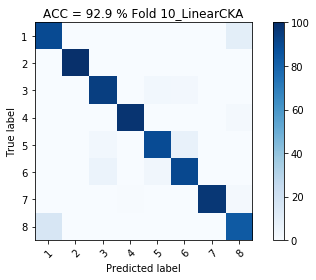

              precision    recall  f1-score   support

           1       0.85      0.90      0.87       285
           2       0.99      1.00      1.00       285
           3       0.91      0.94      0.93       285
           4       0.99      0.98      0.99       285
           5       0.93      0.89      0.91       285
           6       0.90      0.91      0.90       285
           7       0.99      0.97      0.98       285
           8       0.86      0.84      0.85       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LogisticRegressionCKA_Fold10


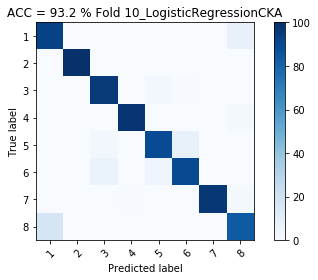

              precision    recall  f1-score   support

           1       0.85      0.93      0.88       285
           2       0.99      1.00      1.00       285
           3       0.91      0.96      0.93       285
           4       0.99      0.98      0.99       285
           5       0.93      0.89      0.91       285
           6       0.91      0.89      0.90       285
           7       1.00      0.97      0.98       285
           8       0.88      0.84      0.86       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280

Guardando... LinearSVCKA_Fold10


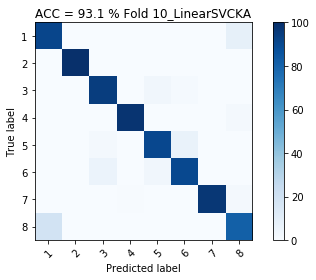

              precision    recall  f1-score   support

           1       0.83      0.92      0.87       285
           2       0.99      1.00      1.00       285
           3       0.92      0.95      0.94       285
           4       0.99      0.98      0.99       285
           5       0.93      0.91      0.92       285
           6       0.91      0.91      0.91       285
           7       1.00      0.97      0.98       285
           8       0.87      0.81      0.84       285

    accuracy                           0.93      2280
   macro avg       0.93      0.93      0.93      2280
weighted avg       0.93      0.93      0.93      2280





10it [32:54, 197.41s/it]


In [ ]:
# Traininig/Testing loop
fold = 0

for train_index, test_index in tqdm(sss.split(X,y)):
    # Training/testing index storage
    train_idx += [train_index]
    test_idx  += [test_index]
    
    # Number of partitions flag
    fold = fold + 1
    print("Iteration = ", str(fold) +'/'+ str(n_partitions))
    
    # Iteration file name 
    filename = img_path + "/Fold" + str(fold)

    # Train/Test partition and matrix storing to apply CKA over them for 
    # visualization
    X_train, X_test = Xr[train_index,:], Xr[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    X_train_cka += [X_train]
    X_test_cka  += [X_test]
    y_train_cka += [y_train]
    y_test_cka  += [y_test]

    # ---------------------------------------------------------------------------------------------------------------------------
    # Training
    
    # Linear
    print('Linear Model')
    # Using GridSearchCV 
    # hs_Lineal = GridSearchCV(Pipeline(steps[0]), parameters[0], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_Lineal = RandomizedSearchCV(Pipeline(steps[0]), param_distributions=parameters[0],n_iter=10, cv=5, iid=False, n_jobs=25)
    hs_Lineal.fit(X_train,y_train)
    # Projection matrix from CKA
    W_cka_L += [hs_Lineal.best_estimator_.named_steps['Projection'].Wcka]


    # Logistic Regression
    print('Logistic Regression Model')
    # Usaing GridSearchCV 
    # hs_LogR = GridSearchCV(Pipeline(steps[1]), parameters[1], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_LogR = RandomizedSearchCV(Pipeline(steps[1]), param_distributions=parameters[1],n_iter=10, cv=5, iid=False,n_jobs=25)
    hs_LogR.fit(X_train,y_train)
    # Projection matrix from CKA
    W_cka_LogR += [hs_LogR.best_estimator_.named_steps['Projection'].Wcka]
  

    # Linear SVM
    print('Linear SVM Model')
    # Using GridSearchCV 
    #hs_lSVM = GridSearchCV(Pipeline(steps[2]), parameters[2], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_lSVM = RandomizedSearchCV(Pipeline(steps[2]), param_distributions=parameters[2],n_iter=10, cv=5, iid=False, n_jobs=25)  
    hs_lSVM.fit(X_train,y_train)
    # Projection matrix from CKA
    W_cka_lSVM += [hs_lSVM.best_estimator_.named_steps['Projection'].Wcka]

    # ---------------------------------------------------------------------------------------------------------------------------
    # Validation
    
    # Linear
    y_pred_L           = hs_Lineal.best_estimator_.predict(X_test)
    accuracy_L[fold-1] = accuracy_score(y_test,y_pred_L)
    cm_temp            = confusion_matrix(y_test,y_pred_L)
    cm_L[fold-1,:,:]   = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_L, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_L[fold-1],fold) + '_'+ label_models[0])
    plt.autoscale()
    save_fig(img_path,label_models[0]+'_Fold'+str(fold))                      
    plt.show()
    cr_L += [classification_report(y_test,y_pred_L)]
    print(cr_L[-1])
    # Best model storage
    # best_mod_L += [hs_Lineal.best_estimator_, accuracy_L,cm_L,cr_L, sel_fts_L]
    # best_mod_L += [hs_Lineal.best_estimator_]
    best_pms_L += [hs_Lineal.best_params_]
    joblib.dump(best_pms_L, filename + "LinealCKA" + ".pkl")


    # Logistic Regression
    y_pred_LogR          = hs_LogR.best_estimator_.predict(X_test)
    accuracy_LogR[fold-1]= accuracy_score(y_test,y_pred_LogR)
    cm_temp              = confusion_matrix(y_test,y_pred_LogR)
    cm_LogR[fold-1,:,:]  = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_LogR, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_LogR[fold-1],fold) + '_'+ label_models[1])
    plt.autoscale()
    save_fig(img_path,label_models[1]+'_Fold'+str(fold))                      
    plt.show()
    cr_LogR += [classification_report(y_test,y_pred_LogR)]
    print(cr_LogR[-1])
    # Best model storage
    # best_mod_LogR += [hs_LogR.best_estimator_, accuracy_LogR,cm_LogR,cr_LogR, sel_fts_LogR]
    # best_mod_LogR += [hs_LogR.best_estimator_]
    best_pms_LogR += [hs_LogR.best_params_]
    joblib.dump(best_pms_LogR, filename + "LogRCKA" + ".pkl")


    # Linear SVM
    y_pred_lSVM          = hs_lSVM.best_estimator_.predict(X_test)
    accuracy_lSVM[fold-1]= accuracy_score(y_test,y_pred_lSVM)
    cm_temp              = confusion_matrix(y_test,y_pred_lSVM)
    cm_LogR[fold-1,:,:]  = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_lSVM, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_lSVM[fold-1],fold) + '_'+ label_models[2])
    plt.autoscale()
    save_fig(img_path,label_models[2]+'_Fold'+str(fold))                      
    plt.show()
    cr_lSVM += [classification_report(y_test,y_pred_lSVM)]
    print(cr_lSVM[-1])
    # Best model storage
    # best_mod_lSVM += [hs_lSVM.best_estimator_, accuracy_lSVM,cm_lSVM,cr_lSVM, sel_fts_lSVM]
    # best_mod_lSVM += [hs_lSVM.best_estimator_]
    best_pms_lSVM += [hs_lSVM.best_params_]
    joblib.dump(best_pms_lSVM, filename + "lSVMCKA" + ".pkl")
    
    # Results dictionary creation
    L_dict = {'accuracy_L': accuracy_L,
              'cm_L': cm_L,
              'cr_L': cr_L,
              'W_cka_L': W_cka_L,
              'X_train_cka': X_train_cka,
              'X_test_cka': X_test_cka,
              'y_train_cka':y_train_cka,
              'y_test_cka':y_test_cka}

    LogR_dict = {'accuracy_LogR': accuracy_LogR,
                'cm_LogR': cm_LogR,
                'cr_LogR': cr_LogR,
                'W_cka_LogR': W_cka_LogR,
                'X_train_cka': X_train_cka,
                'X_test_cka': X_test_cka,
                'y_train_cka':y_train_cka,
                'y_test_cka':y_test_cka}

    lSVM_dict = {'accuracy_lSVM': accuracy_lSVM,
                'cm_lSVM': cm_lSVM,
                'cr_lSVM': cr_lSVM,
                'W_cka_lSVM': W_cka_lSVM,
                'X_train_cka': X_train_cka,
                'X_test_cka': X_test_cka,
                'y_train_cka':y_train_cka,
                'y_test_cka':y_test_cka}

    Results = [L_dict, LogR_dict, lSVM_dict]

    joblib.dump(Results, rslt_dir + "Fold" + str(fold) + ".pkl")

Average result printing

In [ ]:
print('Linear Classifier')
print(str(np.mean(np.array(Results[0]['accuracy_L']))*100) + '+/-' + str(np.std(np.array(Results[0]['accuracy_L']))*100))

print('Logistic Regression Classifier')
print(str(np.mean(np.array(Results[1]['accuracy_LogR']))*100) + '+/-' + str(np.std(np.array(Results[1]['accuracy_LogR']))*100))

print('Linear SVM Classifier')
print(str(np.mean(np.array(Results[2]['accuracy_lSVM']))*100) + '+/-' + str(np.std(np.array(Results[2]['accuracy_lSVM']))*100))

Linear Classifier
93.41228070175438+/-0.5162785603355133
Logistic Regression Classifier
93.55701754385966+/-0.5570175438596489
Linear SVM Classifier
93.28508771929825+/-0.587932011781185


Projection matrix plotting

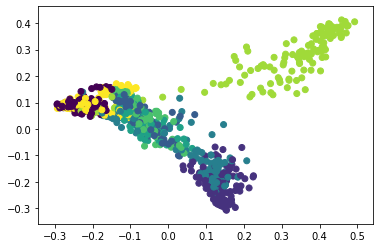

In [ ]:
W    = Results[1]['W_cka_LogR'][0]
Xp   = X_train_cka[0].dot(W)
# Plotting the projection matrix
plt.scatter(Xp[:,1],Xp[:,2],c = y_train_cka[0])

# **Step 5: Region Selection**

The algorithm now runs over the regions to know whose are more informative than others

In [ ]:
# Declaracion de variables
n_partitions = 10
test_per     = 0.695
n_classes    = len(np.unique(y))
f_step       = 1500
ftr_vec      = np.arange(f_step,int((X.shape[1]))+f_step,f_step).astype(int)
fold         = 0
# Arrays and lists to store at each fold
train_idx    = []
test_idx     = []
accuracy_L   = np.zeros((n_partitions,len(ftr_vec)))
accuracy_LogR= np.zeros((n_partitions,len(ftr_vec)))
accuracy_lSVM= np.zeros((n_partitions,len(ftr_vec)))
cm_L         = np.zeros((n_partitions,n_classes,n_classes))
cm_LogR      = np.zeros((n_partitions,n_classes,n_classes))
cm_lSVM      = np.zeros((n_partitions,n_classes,n_classes))
cr_L         = []
cr_LogR      = []
cr_lSVM      = []
best_mod_L   = []
best_mod_LogR= []
best_mod_lSVM= []
best_pms_L   = []
best_pms_LogR= []
best_pms_lSVM= []

NameError: name 'y' is not defined

In [ ]:
# Setting the data partition scheme to work like HoldOut validation
sss = StratifiedShuffleSplit(n_splits = n_partitions, test_size = test_per, random_state=42)

In [ ]:
# Step declaration
steps = [
        [('Preprocessing', StandardScaler()),
          ('Classification',SGDClassifier())],      # Clasificador Lineal
        ]
    
# Grid declaration
parameters = [
            {'Classification__penalty': ['l1', 'l2', 'elasticnet'] },
            ]

# Model labels
label_models = ['Linear']

In [ ]:
# Directory to save results and plots

rslt_dir     = img_dir + '/RegionSelection/RS_BoCF/Results_RS_BoCF_Py'
sys.path.append(rslt_dir)
img_path     = img_dir + '/RegionSelection/RS_BoCF/'
sys.path.append(img_path)



0it [00:00, ?it/s]

Region =  1/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.4s remaining:    9.4s
[Parallel(n_jobs=25)]: Done   3 out of  15 | elapsed:    1.8s remaining:    7.3s
[Parallel(n_jobs=25)]: Done   4 out of  15 | elapsed:    1.8s remaining:    5.0s
[Parallel(n_jobs=25)]: Done   5 out of  15 | elapsed:    1.8s remaining:    3.6s
[Parallel(n_jobs=25)]: Done   6 out of  15 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=25)]: Done   7 out of  15 | elapsed:    2.2s remaining:    2.6s
[Parallel(n_jobs=25)]: Done   8 out of  15 | elapsed:    2.4s remaining:    2.1s
[Parallel(n_jobs=25)]: Done   9 out of  15 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=25)]: Done  10 out of  15 | elapsed:    2.4s remaining:    1.2s
[Parallel(n_jobs=25)]: Don

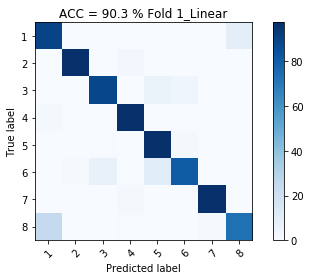



1it [00:04,  4.56s/it]

              precision    recall  f1-score   support

           1       0.77      0.90      0.83       275
           2       0.98      0.97      0.98       274
           3       0.92      0.89      0.90       275
           4       0.95      0.97      0.96       275
           5       0.85      0.97      0.91       275
           6       0.93      0.81      0.87       274
           7       0.98      0.97      0.98       275
           8       0.87      0.73      0.80       275

    accuracy                           0.90      2198
   macro avg       0.91      0.90      0.90      2198
weighted avg       0.91      0.90      0.90      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.9s remaining:   12.2s
[Parallel(n_jobs=25)]: Done   3 out of

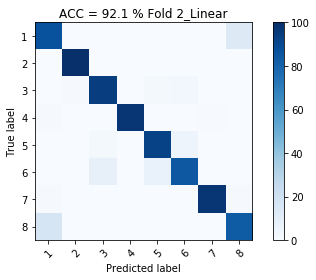



2it [00:08,  4.33s/it]

              precision    recall  f1-score   support

           1       0.82      0.87      0.85       275
           2       0.98      1.00      0.99       275
           3       0.90      0.94      0.92       274
           4       0.99      0.97      0.98       275
           5       0.91      0.93      0.92       275
           6       0.92      0.85      0.88       275
           7       0.99      0.97      0.98       274
           8       0.85      0.83      0.84       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.1s remaining:    7.1s
[Parallel(n_jobs=25)]: Done   3 out of

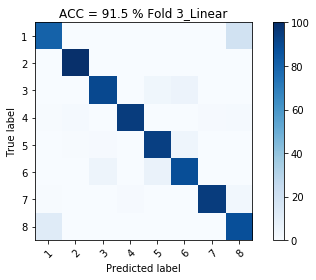



3it [00:11,  3.94s/it]

              precision    recall  f1-score   support

           1       0.86      0.81      0.83       275
           2       0.98      1.00      0.99       274
           3       0.94      0.91      0.92       275
           4       0.99      0.95      0.97       275
           5       0.90      0.94      0.92       274
           6       0.90      0.88      0.89       275
           7       0.99      0.95      0.97       275
           8       0.79      0.88      0.83       275

    accuracy                           0.91      2198
   macro avg       0.92      0.91      0.92      2198
weighted avg       0.92      0.91      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.3s remaining:    8.4s
[Parallel(n_jobs=25)]: Done   3 out of

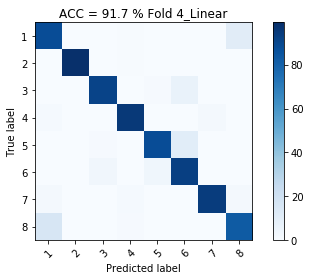



4it [00:14,  3.67s/it]

              precision    recall  f1-score   support

           1       0.82      0.88      0.85       275
           2       1.00      0.99      0.99       274
           3       0.95      0.92      0.93       274
           4       0.96      0.96      0.96       275
           5       0.95      0.88      0.92       275
           6       0.84      0.93      0.88       275
           7       0.97      0.95      0.96       275
           8       0.86      0.83      0.85       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.5s remaining:   10.0s
[Parallel(n_jobs=25)]: Done   3 out of

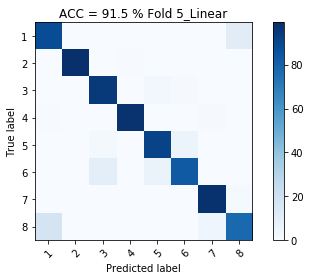



5it [00:17,  3.60s/it]

              precision    recall  f1-score   support

           1       0.83      0.88      0.85       275
           2       1.00      0.99      0.99       275
           3       0.89      0.96      0.92       274
           4       0.98      0.98      0.98       275
           5       0.91      0.92      0.91       274
           6       0.92      0.83      0.87       275
           7       0.94      0.98      0.96       275
           8       0.86      0.78      0.82       275

    accuracy                           0.91      2198
   macro avg       0.92      0.91      0.91      2198
weighted avg       0.92      0.91      0.91      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    0.6s remaining:    3.7s
[Parallel(n_jobs=25)]: Done   3 out of

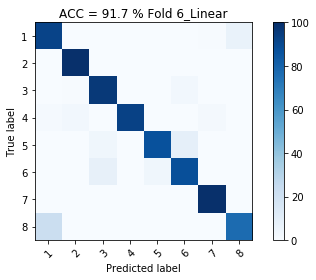



6it [00:22,  3.99s/it]

              precision    recall  f1-score   support

           1       0.79      0.92      0.85       275
           2       0.96      1.00      0.98       275
           3       0.89      0.96      0.93       275
           4       1.00      0.93      0.96       275
           5       0.96      0.87      0.91       274
           6       0.88      0.88      0.88       274
           7       0.97      1.00      0.98       275
           8       0.91      0.77      0.84       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.2s remaining:    8.1s
[Parallel(n_jobs=25)]: Done   3 out of

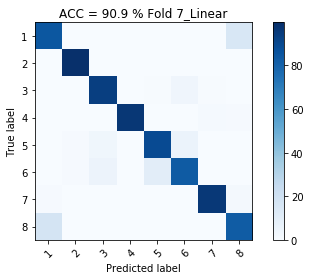



7it [00:25,  3.71s/it]

              precision    recall  f1-score   support

           1       0.82      0.85      0.83       275
           2       0.97      1.00      0.98       275
           3       0.91      0.94      0.92       275
           4       0.99      0.97      0.98       275
           5       0.89      0.89      0.89       274
           6       0.89      0.83      0.86       275
           7       0.98      0.96      0.97       275
           8       0.82      0.83      0.82       274

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.1s remaining:    6.9s
[Parallel(n_jobs=25)]: Done   3 out of

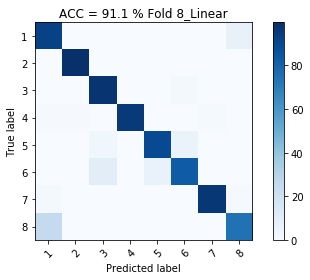



8it [00:29,  3.79s/it]

              precision    recall  f1-score   support

           1       0.76      0.92      0.84       274
           2       0.98      1.00      0.99       275
           3       0.88      0.97      0.92       275
           4       0.99      0.96      0.97       275
           5       0.92      0.89      0.91       275
           6       0.91      0.83      0.86       275
           7       0.99      0.97      0.98       274
           8       0.89      0.75      0.81       275

    accuracy                           0.91      2198
   macro avg       0.92      0.91      0.91      2198
weighted avg       0.92      0.91      0.91      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.1s remaining:    7.3s
[Parallel(n_jobs=25)]: Done   3 out of

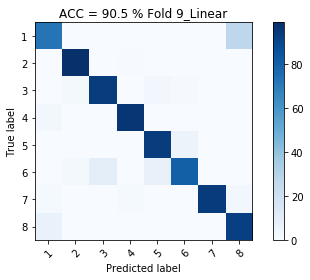



9it [00:33,  3.86s/it]

              precision    recall  f1-score   support

           1       0.87      0.73      0.79       275
           2       0.96      0.99      0.97       275
           3       0.90      0.94      0.92       274
           4       0.97      0.96      0.97       275
           5       0.90      0.94      0.92       275
           6       0.92      0.80      0.86       275
           7       0.99      0.95      0.97       274
           8       0.75      0.93      0.83       275

    accuracy                           0.90      2198
   macro avg       0.91      0.90      0.90      2198
weighted avg       0.91      0.90      0.90      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.1s remaining:    7.4s
[Parallel(n_jobs=25)]: Done   3 out o

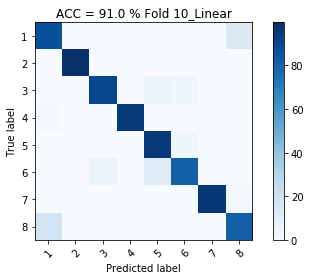



10it [00:37,  3.80s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.80      0.87      0.84       275
           2       0.99      1.00      0.99       275
           3       0.93      0.91      0.92       275
           4       1.00      0.96      0.98       275
           5       0.85      0.96      0.90       275
           6       0.91      0.81      0.86       274
           7       0.99      0.97      0.98       274
           8       0.84      0.81      0.83       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Region =  2/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.1s remaining:   13.8s
[Parallel(n_jobs=25)]: 

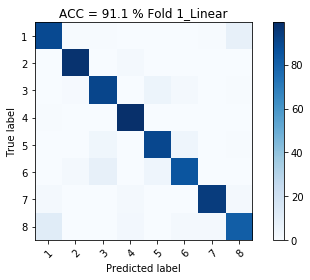



1it [00:07,  7.73s/it]

              precision    recall  f1-score   support

           1       0.87      0.89      0.88       275
           2       0.96      0.98      0.97       274
           3       0.88      0.91      0.89       275
           4       0.93      0.99      0.96       275
           5       0.90      0.90      0.90       275
           6       0.91      0.85      0.88       274
           7       0.97      0.95      0.96       275
           8       0.88      0.81      0.85       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.5s remaining:   16.3s
[Parallel(n_jobs=25)]: Done   3 out of

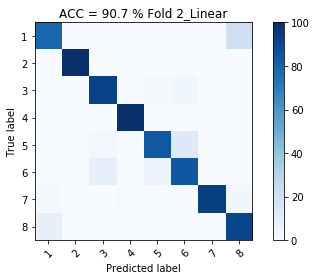



2it [00:15,  7.71s/it]

              precision    recall  f1-score   support

           1       0.89      0.79      0.84       275
           2       0.98      1.00      0.99       275
           3       0.89      0.93      0.91       274
           4       0.98      1.00      0.99       275
           5       0.92      0.84      0.88       275
           6       0.84      0.85      0.84       275
           7       1.00      0.93      0.97       274
           8       0.79      0.91      0.85       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.2s remaining:    7.5s
[Parallel(n_jobs=25)]: Done   3 out of

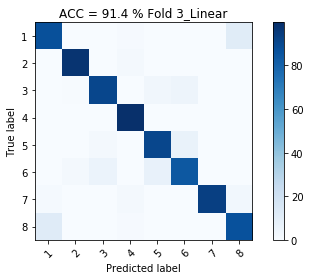



3it [00:21,  7.29s/it]

              precision    recall  f1-score   support

           1       0.86      0.87      0.87       275
           2       0.97      0.98      0.97       274
           3       0.92      0.91      0.91       275
           4       0.94      1.00      0.96       275
           5       0.90      0.91      0.90       274
           6       0.88      0.84      0.86       275
           7       1.00      0.93      0.97       275
           8       0.86      0.87      0.86       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.1s remaining:    7.5s
[Parallel(n_jobs=25)]: Done   3 out of

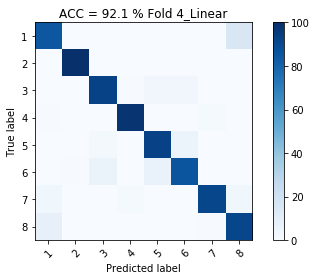



4it [00:32,  8.26s/it]

              precision    recall  f1-score   support

           1       0.87      0.85      0.86       275
           2       0.99      1.00      1.00       274
           3       0.92      0.93      0.92       274
           4       0.98      0.98      0.98       275
           5       0.90      0.93      0.92       275
           6       0.91      0.86      0.88       275
           7       0.98      0.91      0.94       275
           8       0.83      0.91      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.1s remaining:    7.3s
[Parallel(n_jobs=25)]: Done   3 out of

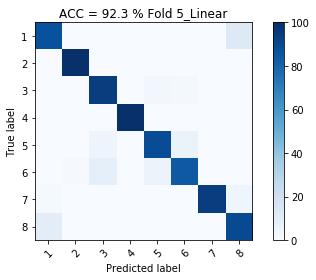



5it [00:38,  7.58s/it]

              precision    recall  f1-score   support

           1       0.88      0.87      0.87       275
           2       0.99      1.00      0.99       275
           3       0.88      0.95      0.91       274
           4       1.00      1.00      1.00       275
           5       0.91      0.89      0.90       274
           6       0.91      0.84      0.88       275
           7       1.00      0.94      0.97       275
           8       0.84      0.89      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.3s remaining:    8.6s
[Parallel(n_jobs=25)]: Done   3 out of

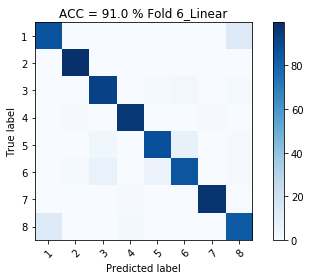



6it [00:49,  8.68s/it]

              precision    recall  f1-score   support

           1       0.86      0.86      0.86       275
           2       0.96      1.00      0.98       275
           3       0.89      0.93      0.91       275
           4       0.96      0.97      0.97       275
           5       0.92      0.88      0.90       274
           6       0.88      0.85      0.87       274
           7       0.97      0.97      0.97       275
           8       0.82      0.83      0.83       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.4s remaining:   15.3s
[Parallel(n_jobs=25)]: Done   3 out of

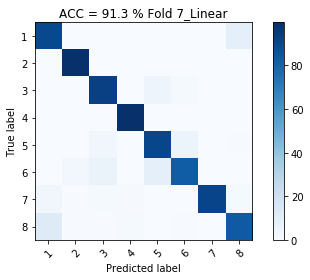



7it [00:58,  8.92s/it]

              precision    recall  f1-score   support

           1       0.85      0.90      0.87       275
           2       0.96      1.00      0.98       275
           3       0.89      0.93      0.91       275
           4       0.96      0.99      0.98       275
           5       0.87      0.91      0.89       274
           6       0.91      0.82      0.87       275
           7       0.99      0.92      0.95       275
           8       0.88      0.84      0.86       274

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    0.7s remaining:    4.7s
[Parallel(n_jobs=25)]: Done   3 out of

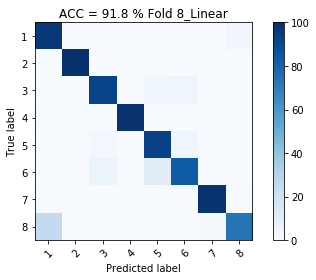



8it [01:03,  7.60s/it]

              precision    recall  f1-score   support

           1       0.78      0.97      0.86       274
           2       0.99      1.00      0.99       275
           3       0.92      0.92      0.92       275
           4       0.99      0.99      0.99       275
           5       0.86      0.93      0.90       275
           6       0.90      0.83      0.87       275
           7       0.99      0.98      0.99       274
           8       0.95      0.73      0.83       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.0s remaining:    6.2s
[Parallel(n_jobs=25)]: Done   3 out of

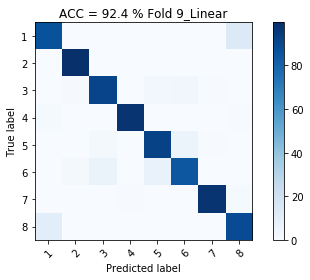



9it [01:09,  7.20s/it]

              precision    recall  f1-score   support

           1       0.88      0.87      0.87       275
           2       0.97      1.00      0.98       275
           3       0.92      0.92      0.92       274
           4       0.98      0.98      0.98       275
           5       0.90      0.92      0.91       275
           6       0.91      0.85      0.88       275
           7       0.99      0.97      0.98       274
           8       0.85      0.89      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.0s remaining:   13.2s
[Parallel(n_jobs=25)]: Done   3 out o

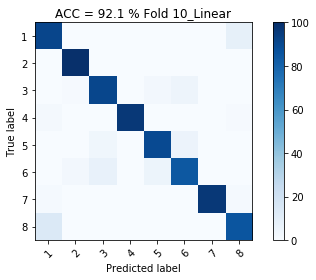



10it [01:16,  7.62s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.84      0.92      0.88       275
           2       0.96      1.00      0.98       275
           3       0.89      0.91      0.90       275
           4       1.00      0.97      0.98       275
           5       0.92      0.90      0.91       275
           6       0.89      0.85      0.87       274
           7       0.99      0.97      0.98       274
           8       0.89      0.86      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  3/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.8s remaining:   18.2s
[Parallel(n_jobs=25)]: 

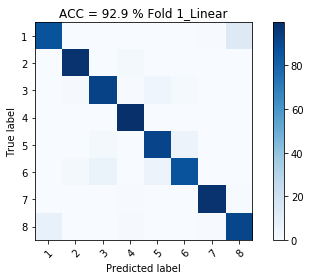



1it [00:12, 12.07s/it]

              precision    recall  f1-score   support

           1       0.92      0.86      0.89       275
           2       0.97      0.98      0.97       274
           3       0.91      0.92      0.92       275
           4       0.96      1.00      0.98       275
           5       0.90      0.92      0.91       275
           6       0.93      0.86      0.89       274
           7       0.98      0.98      0.98       275
           8       0.87      0.91      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.2s remaining:    7.9s
[Parallel(n_jobs=25)]: Done   3 out of

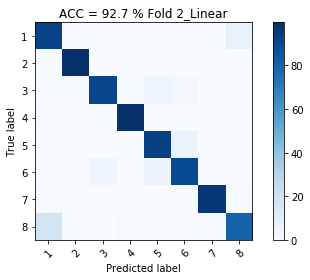



2it [00:20, 11.06s/it]

              precision    recall  f1-score   support

           1       0.81      0.92      0.87       275
           2       0.99      1.00      0.99       275
           3       0.95      0.91      0.93       274
           4       0.98      0.99      0.99       275
           5       0.90      0.93      0.92       275
           6       0.90      0.89      0.90       275
           7       1.00      0.97      0.98       274
           8       0.89      0.80      0.85       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    3.1s remaining:   20.5s
[Parallel(n_jobs=25)]: Done   3 out of

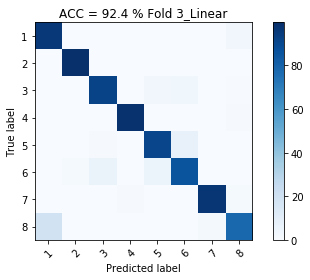



3it [00:28, 10.15s/it]

              precision    recall  f1-score   support

           1       0.83      0.96      0.89       275
           2       0.98      1.00      0.99       274
           3       0.92      0.92      0.92       275
           4       0.98      0.99      0.98       275
           5       0.91      0.91      0.91       274
           6       0.88      0.86      0.87       275
           7       0.98      0.97      0.97       275
           8       0.92      0.79      0.85       275

    accuracy                           0.92      2198
   macro avg       0.93      0.92      0.92      2198
weighted avg       0.93      0.92      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.1s remaining:    6.9s
[Parallel(n_jobs=25)]: Done   3 out of

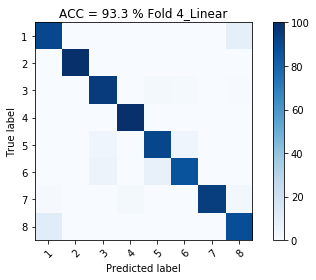



4it [00:39, 10.37s/it]

              precision    recall  f1-score   support

           1       0.87      0.91      0.89       275
           2       0.99      1.00      1.00       274
           3       0.91      0.96      0.93       274
           4       0.98      0.99      0.99       275
           5       0.91      0.91      0.91       275
           6       0.94      0.87      0.90       275
           7       1.00      0.95      0.97       275
           8       0.87      0.88      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    3.6s remaining:   23.1s
[Parallel(n_jobs=25)]: Done   3 out of

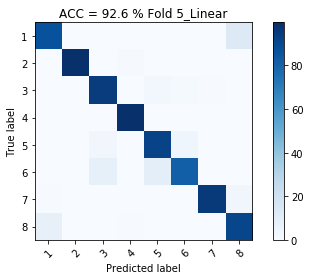



5it [00:52, 11.17s/it]

              precision    recall  f1-score   support

           1       0.91      0.87      0.89       275
           2       0.99      0.99      0.99       275
           3       0.89      0.95      0.92       274
           4       0.98      1.00      0.99       275
           5       0.88      0.92      0.90       274
           6       0.93      0.81      0.87       275
           7       0.99      0.96      0.97       275
           8       0.85      0.91      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.2s remaining:    8.0s
[Parallel(n_jobs=25)]: Done   3 out of

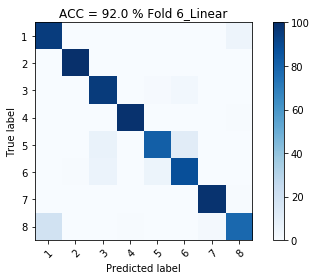



6it [01:03, 10.94s/it]

              precision    recall  f1-score   support

           1       0.83      0.95      0.89       275
           2       0.99      1.00      0.99       275
           3       0.88      0.96      0.92       275
           4       0.99      0.99      0.99       275
           5       0.93      0.82      0.87       274
           6       0.86      0.88      0.87       274
           7       0.98      0.99      0.98       275
           8       0.93      0.78      0.85       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.5s remaining:    9.7s
[Parallel(n_jobs=25)]: Done   3 out of

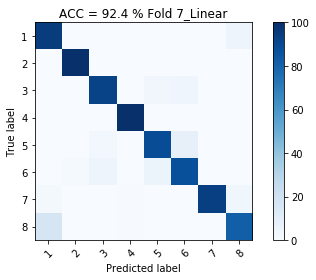



7it [01:10,  9.76s/it]

              precision    recall  f1-score   support

           1       0.83      0.95      0.89       275
           2       0.98      1.00      0.99       275
           3       0.92      0.92      0.92       275
           4       0.99      1.00      0.99       275
           5       0.90      0.89      0.90       274
           6       0.88      0.88      0.88       275
           7       0.99      0.94      0.96       275
           8       0.91      0.82      0.86       274

    accuracy                           0.92      2198
   macro avg       0.93      0.92      0.92      2198
weighted avg       0.93      0.92      0.92      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.5s remaining:   10.0s
[Parallel(n_jobs=25)]: Done   3 out of

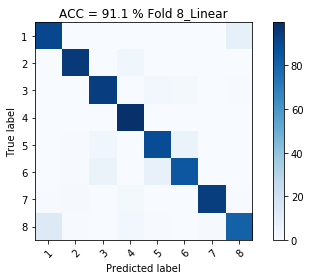



8it [01:20, 10.01s/it]

              precision    recall  f1-score   support

           1       0.86      0.91      0.88       274
           2       0.96      0.96      0.96       275
           3       0.90      0.94      0.92       275
           4       0.91      1.00      0.95       275
           5       0.89      0.89      0.89       275
           6       0.90      0.85      0.87       275
           7       0.98      0.95      0.96       274
           8       0.88      0.81      0.84       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.5s remaining:   10.1s
[Parallel(n_jobs=25)]: Done   3 out of

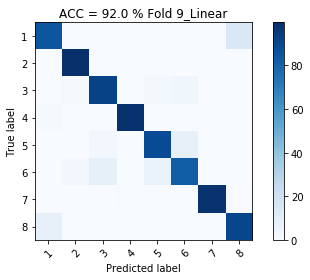



9it [01:30,  9.97s/it]

              precision    recall  f1-score   support

           1       0.90      0.85      0.87       275
           2       0.96      1.00      0.98       275
           3       0.89      0.92      0.91       274
           4       0.99      0.99      0.99       275
           5       0.91      0.89      0.90       275
           6       0.88      0.82      0.85       275
           7       0.99      0.98      0.99       274
           8       0.85      0.91      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.9s remaining:   12.2s
[Parallel(n_jobs=25)]: Done   3 out o

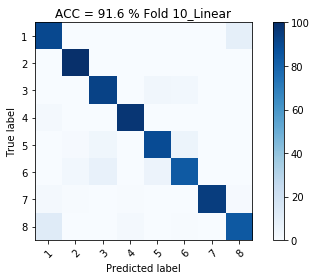



10it [01:41, 10.19s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.84      0.91      0.87       275
           2       0.95      1.00      0.98       275
           3       0.89      0.93      0.91       275
           4       0.97      0.97      0.97       275
           5       0.90      0.89      0.90       275
           6       0.90      0.84      0.87       274
           7       0.99      0.95      0.97       274
           8       0.89      0.84      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  4/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.4s remaining:    9.4s
[Parallel(n_jobs=25)]: 

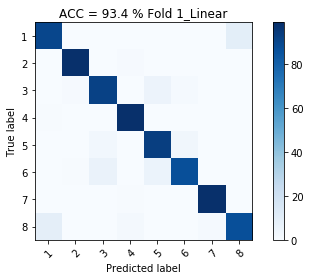



1it [00:11, 11.40s/it]

              precision    recall  f1-score   support

           1       0.90      0.90      0.90       275
           2       0.98      0.99      0.98       274
           3       0.91      0.92      0.92       275
           4       0.96      0.99      0.98       275
           5       0.89      0.93      0.91       275
           6       0.95      0.87      0.91       274
           7       0.99      0.99      0.99       275
           8       0.90      0.87      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.3s remaining:   14.7s
[Parallel(n_jobs=25)]: Done   3 out of

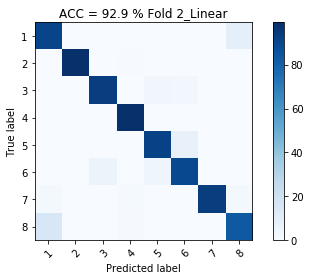



2it [00:25, 12.13s/it]

              precision    recall  f1-score   support

           1       0.84      0.91      0.87       275
           2       0.99      0.99      0.99       275
           3       0.94      0.94      0.94       274
           4       0.97      0.99      0.98       275
           5       0.93      0.92      0.93       275
           6       0.90      0.90      0.90       275
           7       1.00      0.94      0.97       274
           8       0.88      0.84      0.86       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.9s remaining:   12.4s
[Parallel(n_jobs=25)]: Done   3 out of

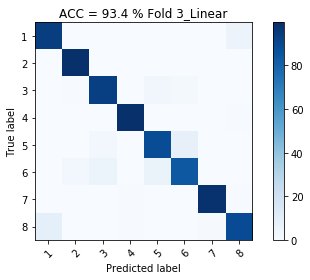



3it [00:34, 11.18s/it]

              precision    recall  f1-score   support

           1       0.91      0.94      0.93       275
           2       0.96      1.00      0.98       274
           3       0.91      0.93      0.92       275
           4       0.98      0.99      0.99       275
           5       0.90      0.89      0.89       274
           6       0.89      0.84      0.87       275
           7       0.98      0.99      0.98       275
           8       0.92      0.89      0.91       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    3.7s remaining:   23.9s
[Parallel(n_jobs=25)]: Done   3 out of

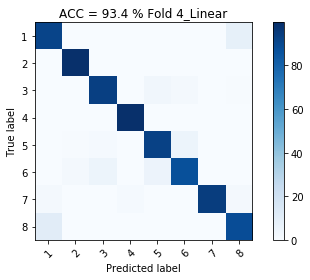



4it [00:44, 11.04s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.89       275
           2       0.97      1.00      0.98       274
           3       0.93      0.94      0.94       274
           4       0.98      1.00      0.99       275
           5       0.91      0.93      0.92       275
           6       0.93      0.87      0.90       275
           7       1.00      0.95      0.97       275
           8       0.89      0.88      0.89       275

    accuracy                           0.93      2198
   macro avg       0.94      0.93      0.93      2198
weighted avg       0.94      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.6s remaining:   10.3s
[Parallel(n_jobs=25)]: Done   3 out of

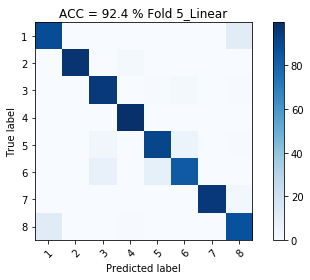



5it [01:06, 14.07s/it]

              precision    recall  f1-score   support

           1       0.87      0.88      0.88       275
           2       0.99      0.98      0.99       275
           3       0.90      0.96      0.93       274
           4       0.96      1.00      0.98       275
           5       0.91      0.91      0.91       274
           6       0.92      0.84      0.88       275
           7       0.99      0.96      0.98       275
           8       0.85      0.87      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.8s remaining:   11.5s
[Parallel(n_jobs=25)]: Done   3 out of

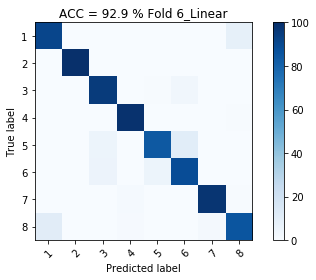



6it [01:24, 15.52s/it]

              precision    recall  f1-score   support

           1       0.89      0.92      0.90       275
           2       0.99      1.00      1.00       275
           3       0.90      0.96      0.93       275
           4       0.97      0.99      0.98       275
           5       0.94      0.84      0.89       274
           6       0.87      0.89      0.88       274
           7       0.98      0.98      0.98       275
           8       0.90      0.86      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.6s remaining:   10.2s
[Parallel(n_jobs=25)]: Done   3 out of

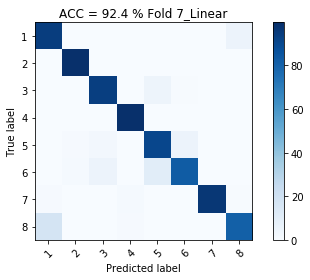



7it [01:40, 15.47s/it]

              precision    recall  f1-score   support

           1       0.84      0.95      0.89       275
           2       0.98      1.00      0.99       275
           3       0.92      0.94      0.93       275
           4       0.97      1.00      0.98       275
           5       0.86      0.91      0.88       274
           6       0.93      0.83      0.87       275
           7       1.00      0.97      0.98       275
           8       0.93      0.81      0.87       274

    accuracy                           0.92      2198
   macro avg       0.93      0.92      0.92      2198
weighted avg       0.93      0.92      0.92      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.1s remaining:   33.0s
[Parallel(n_jobs=25)]: Done   3 out of

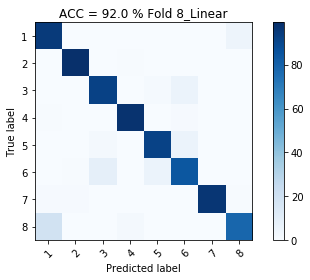



8it [01:56, 15.63s/it]

              precision    recall  f1-score   support

           1       0.82      0.95      0.88       274
           2       0.97      0.99      0.98       275
           3       0.90      0.92      0.91       275
           4       0.97      0.98      0.97       275
           5       0.92      0.92      0.92       275
           6       0.87      0.84      0.86       275
           7       1.00      0.97      0.98       274
           8       0.93      0.79      0.85       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    4.4s remaining:   28.5s
[Parallel(n_jobs=25)]: Done   3 out of

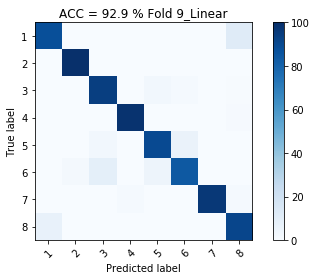



9it [02:07, 14.25s/it]

              precision    recall  f1-score   support

           1       0.91      0.88      0.90       275
           2       0.98      1.00      0.99       275
           3       0.89      0.94      0.91       274
           4       0.98      0.99      0.98       275
           5       0.92      0.90      0.91       275
           6       0.91      0.84      0.88       275
           7       0.99      0.97      0.98       274
           8       0.86      0.92      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.7s remaining:   11.3s
[Parallel(n_jobs=25)]: Done   3 out o

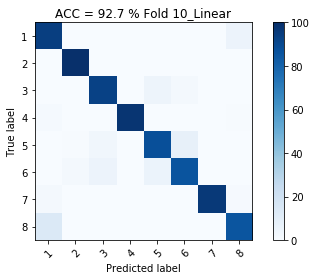



10it [02:21, 14.12s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.84      0.94      0.89       275
           2       0.97      1.00      0.99       275
           3       0.91      0.93      0.92       275
           4       0.99      0.98      0.98       275
           5       0.89      0.88      0.88       275
           6       0.90      0.86      0.88       274
           7       1.00      0.96      0.98       274
           8       0.92      0.86      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Region =  5/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.0s remaining:   39.2s
[Parallel(n_jobs=25)]: 

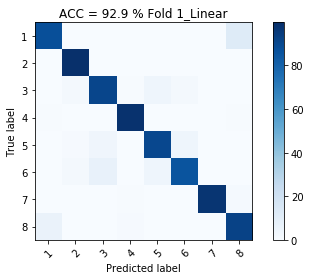



1it [00:17, 17.13s/it]

              precision    recall  f1-score   support

           1       0.92      0.88      0.90       275
           2       0.95      1.00      0.97       274
           3       0.89      0.91      0.90       275
           4       0.97      0.99      0.98       275
           5       0.91      0.91      0.91       275
           6       0.93      0.86      0.89       274
           7       1.00      0.97      0.99       275
           8       0.86      0.92      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    1.7s remaining:   11.3s
[Parallel(n_jobs=25)]: Done   3 out of

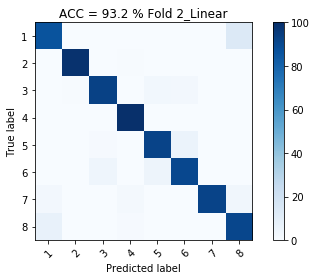



2it [00:38, 18.42s/it]

              precision    recall  f1-score   support

           1       0.89      0.87      0.88       275
           2       0.99      0.99      0.99       275
           3       0.94      0.93      0.94       274
           4       0.96      1.00      0.98       275
           5       0.92      0.92      0.92       275
           6       0.91      0.91      0.91       275
           7       0.99      0.92      0.95       274
           8       0.85      0.91      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.6s remaining:   36.6s
[Parallel(n_jobs=25)]: Done   3 out of

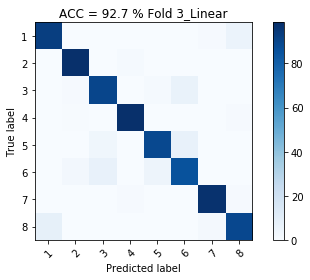



3it [00:52, 17.20s/it]

              precision    recall  f1-score   support

           1       0.91      0.93      0.92       275
           2       0.95      0.99      0.97       274
           3       0.89      0.90      0.90       275
           4       0.97      0.98      0.97       275
           5       0.93      0.89      0.91       274
           6       0.86      0.85      0.86       275
           7       0.97      0.97      0.97       275
           8       0.92      0.89      0.91       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.1s remaining:   32.9s
[Parallel(n_jobs=25)]: Done   3 out of

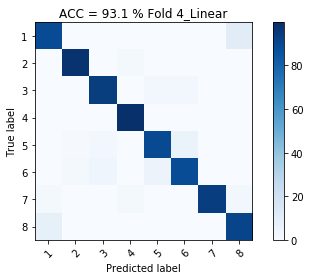



4it [01:07, 16.33s/it]

              precision    recall  f1-score   support

           1       0.89      0.89      0.89       275
           2       0.97      0.98      0.98       274
           3       0.93      0.95      0.94       274
           4       0.96      1.00      0.98       275
           5       0.91      0.89      0.90       275
           6       0.91      0.89      0.90       275
           7       1.00      0.94      0.97       275
           8       0.87      0.92      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.5s remaining:   42.3s
[Parallel(n_jobs=25)]: Done   3 out of

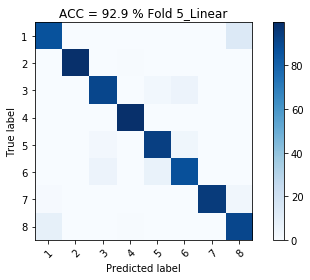



5it [01:27, 17.41s/it]

              precision    recall  f1-score   support

           1       0.90      0.87      0.88       275
           2       1.00      0.99      1.00       275
           3       0.92      0.91      0.91       274
           4       0.98      1.00      0.99       275
           5       0.90      0.93      0.92       274
           6       0.91      0.87      0.89       275
           7       0.99      0.95      0.97       275
           8       0.84      0.91      0.87       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.5s remaining:   15.9s
[Parallel(n_jobs=25)]: Done   3 out of

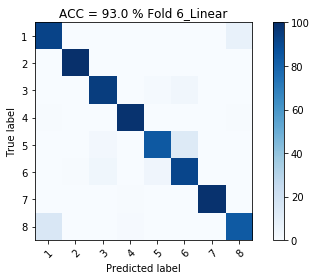



6it [01:52, 19.82s/it]

              precision    recall  f1-score   support

           1       0.86      0.92      0.89       275
           2       0.99      1.00      0.99       275
           3       0.94      0.95      0.94       275
           4       0.98      0.99      0.98       275
           5       0.94      0.84      0.89       274
           6       0.85      0.92      0.88       274
           7       0.99      0.99      0.99       275
           8       0.91      0.84      0.87       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.1s remaining:   33.4s
[Parallel(n_jobs=25)]: Done   3 out of

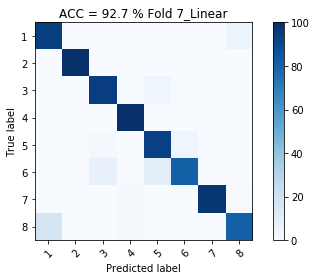



7it [02:09, 18.83s/it]

              precision    recall  f1-score   support

           1       0.84      0.95      0.89       275
           2       0.99      1.00      0.99       275
           3       0.91      0.94      0.92       275
           4       0.97      1.00      0.98       275
           5       0.87      0.93      0.90       274
           6       0.95      0.81      0.88       275
           7       0.99      0.97      0.98       275
           8       0.93      0.81      0.87       274

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.2s remaining:   33.7s
[Parallel(n_jobs=25)]: Done   3 out of

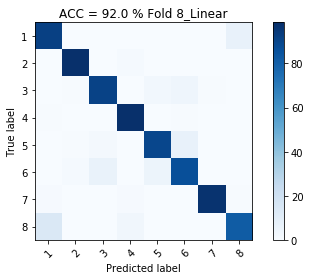



8it [02:23, 17.55s/it]

              precision    recall  f1-score   support

           1       0.85      0.92      0.88       274
           2       0.97      0.99      0.98       275
           3       0.92      0.91      0.91       275
           4       0.94      0.99      0.96       275
           5       0.92      0.90      0.91       275
           6       0.87      0.87      0.87       275
           7       0.99      0.97      0.98       274
           8       0.91      0.82      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.1s remaining:   32.9s
[Parallel(n_jobs=25)]: Done   3 out of

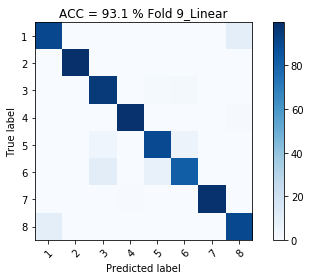



9it [02:42, 17.92s/it]

              precision    recall  f1-score   support

           1       0.90      0.91      0.90       275
           2       0.99      1.00      0.99       275
           3       0.87      0.96      0.91       274
           4       0.99      0.99      0.99       275
           5       0.91      0.90      0.90       275
           6       0.91      0.82      0.86       275
           7       1.00      0.99      0.99       274
           8       0.89      0.90      0.90       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.1s remaining:   13.9s
[Parallel(n_jobs=25)]: Done   3 out o

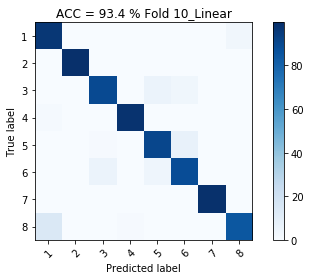



10it [03:01, 18.19s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.86      0.97      0.91       275
           2       0.99      1.00      0.99       275
           3       0.93      0.90      0.91       275
           4       0.98      0.98      0.98       275
           5       0.90      0.91      0.90       275
           6       0.89      0.89      0.89       274
           7       1.00      0.99      0.99       274
           8       0.95      0.85      0.90       275

    accuracy                           0.93      2198
   macro avg       0.94      0.93      0.93      2198
weighted avg       0.94      0.93      0.93      2198

Region =  6/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.2s remaining:   33.6s
[Parallel(n_jobs=25)]: 

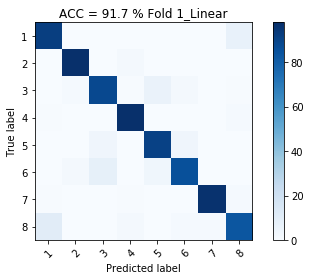



1it [00:29, 29.96s/it]

              precision    recall  f1-score   support

           1       0.88      0.92      0.90       275
           2       0.96      0.98      0.97       274
           3       0.88      0.88      0.88       275
           4       0.94      0.98      0.96       275
           5       0.90      0.91      0.90       275
           6       0.92      0.86      0.89       274
           7       0.99      0.97      0.98       275
           8       0.88      0.84      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.7s remaining:   49.8s
[Parallel(n_jobs=25)]: Done   3 out of

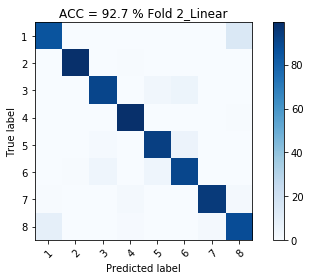



2it [01:11, 33.52s/it]

              precision    recall  f1-score   support

           1       0.90      0.85      0.88       275
           2       0.99      0.99      0.99       275
           3       0.94      0.91      0.92       274
           4       0.96      0.99      0.97       275
           5       0.92      0.93      0.93       275
           6       0.90      0.91      0.90       275
           7       0.98      0.95      0.96       274
           8       0.84      0.88      0.86       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.8s remaining:   44.1s
[Parallel(n_jobs=25)]: Done   3 out of

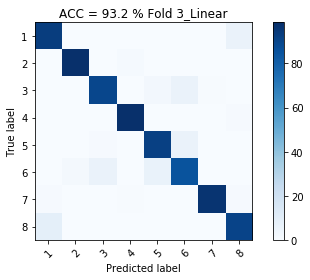



3it [01:28, 28.41s/it]

              precision    recall  f1-score   support

           1       0.90      0.93      0.92       275
           2       0.97      0.99      0.98       274
           3       0.92      0.90      0.91       275
           4       0.97      0.99      0.98       275
           5       0.91      0.92      0.92       274
           6       0.87      0.85      0.86       275
           7       0.99      0.97      0.98       275
           8       0.92      0.91      0.91       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.8s remaining:   18.0s
[Parallel(n_jobs=25)]: Done   3 out of

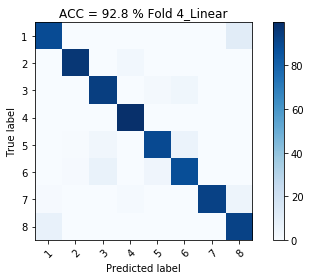



4it [01:53, 27.36s/it]

              precision    recall  f1-score   support

           1       0.91      0.89      0.90       275
           2       0.98      0.97      0.97       274
           3       0.90      0.94      0.92       274
           4       0.96      1.00      0.98       275
           5       0.94      0.90      0.92       275
           6       0.90      0.88      0.89       275
           7       0.99      0.93      0.96       275
           8       0.86      0.92      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    3.0s remaining:   19.2s
[Parallel(n_jobs=25)]: Done   3 out of

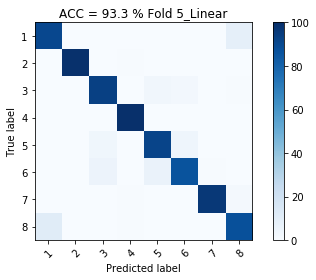



5it [02:27, 29.44s/it]

              precision    recall  f1-score   support

           1       0.88      0.91      0.90       275
           2       1.00      0.99      0.99       275
           3       0.91      0.93      0.92       274
           4       0.98      1.00      0.99       275
           5       0.90      0.92      0.91       274
           6       0.93      0.87      0.89       275
           7       0.99      0.97      0.98       275
           8       0.88      0.88      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.7s remaining:   17.3s
[Parallel(n_jobs=25)]: Done   3 out of

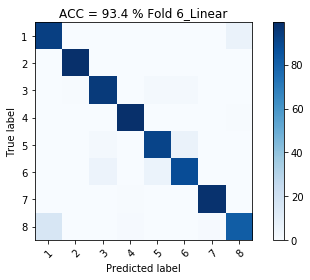



6it [02:47, 26.56s/it]

              precision    recall  f1-score   support

           1       0.85      0.93      0.89       275
           2       0.99      0.99      0.99       275
           3       0.92      0.95      0.94       275
           4       0.98      0.99      0.99       275
           5       0.92      0.91      0.92       274
           6       0.91      0.88      0.89       274
           7       0.99      0.98      0.98       275
           8       0.91      0.82      0.87       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    4.7s remaining:   30.9s
[Parallel(n_jobs=25)]: Done   3 out of

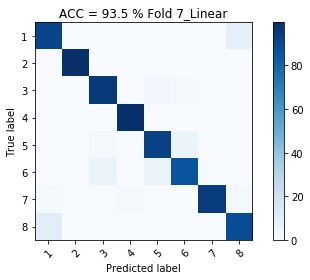



7it [03:13, 26.31s/it]

              precision    recall  f1-score   support

           1       0.88      0.91      0.90       275
           2       1.00      1.00      1.00       275
           3       0.92      0.96      0.94       275
           4       0.97      1.00      0.98       275
           5       0.91      0.93      0.92       274
           6       0.93      0.86      0.89       275
           7       0.99      0.95      0.97       275
           8       0.89      0.89      0.89       274

    accuracy                           0.94      2198
   macro avg       0.94      0.94      0.94      2198
weighted avg       0.94      0.94      0.94      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.3s remaining:   15.2s
[Parallel(n_jobs=25)]: Done   3 out of

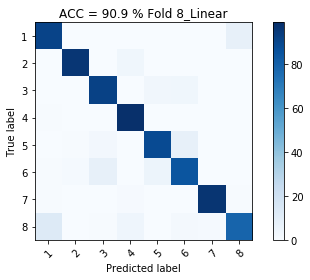



8it [03:43, 27.66s/it]

              precision    recall  f1-score   support

           1       0.86      0.91      0.88       274
           2       0.98      0.96      0.97       275
           3       0.88      0.92      0.90       275
           4       0.91      0.99      0.95       275
           5       0.91      0.89      0.90       275
           6       0.86      0.85      0.85       275
           7       0.99      0.97      0.98       274
           8       0.90      0.79      0.84       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.5s remaining:   16.1s
[Parallel(n_jobs=25)]: Done   3 out of

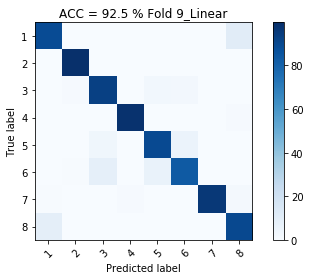



9it [04:08, 26.73s/it]

              precision    recall  f1-score   support

           1       0.89      0.89      0.89       275
           2       0.98      1.00      0.99       275
           3       0.88      0.93      0.91       274
           4       0.98      0.99      0.98       275
           5       0.90      0.90      0.90       275
           6       0.91      0.84      0.87       275
           7       1.00      0.96      0.98       274
           8       0.86      0.90      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.6s remaining:   16.8s
[Parallel(n_jobs=25)]: Done   3 out o

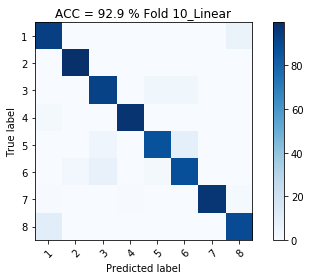



10it [04:30, 27.10s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.88      0.93      0.90       275
           2       0.97      1.00      0.98       275
           3       0.89      0.92      0.91       275
           4       0.98      0.98      0.98       275
           5       0.94      0.87      0.90       275
           6       0.87      0.88      0.87       274
           7       1.00      0.97      0.99       274
           8       0.91      0.89      0.90       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Region =  7/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.1s remaining:   52.8s
[Parallel(n_jobs=25)]: 

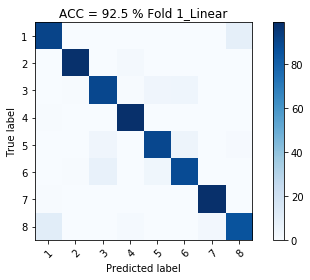



1it [00:21, 21.30s/it]

              precision    recall  f1-score   support

           1       0.88      0.91      0.90       275
           2       0.98      0.98      0.98       274
           3       0.89      0.90      0.89       275
           4       0.96      0.99      0.97       275
           5       0.92      0.90      0.91       275
           6       0.91      0.88      0.89       274
           7       0.97      0.99      0.98       275
           8       0.89      0.85      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.1s remaining:   13.8s
[Parallel(n_jobs=25)]: Done   3 out of

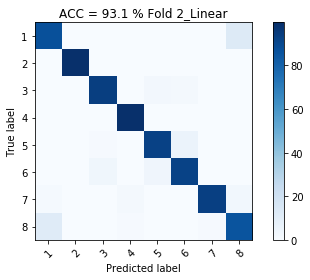



2it [00:44, 21.92s/it]

              precision    recall  f1-score   support

           1       0.86      0.87      0.87       275
           2       1.00      1.00      1.00       275
           3       0.95      0.94      0.95       274
           4       0.96      0.99      0.98       275
           5       0.93      0.93      0.93       275
           6       0.92      0.92      0.92       275
           7       0.98      0.94      0.96       274
           8       0.84      0.86      0.85       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.3s remaining:   15.2s
[Parallel(n_jobs=25)]: Done   3 out of

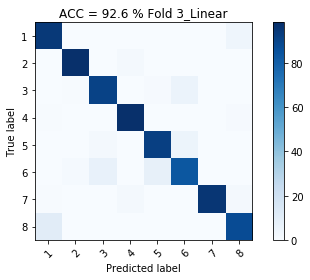



3it [01:34, 30.43s/it]

              precision    recall  f1-score   support

           1       0.88      0.95      0.91       275
           2       0.97      0.98      0.98       274
           3       0.91      0.91      0.91       275
           4       0.95      0.98      0.97       275
           5       0.91      0.92      0.92       274
           6       0.88      0.83      0.86       275
           7       0.99      0.96      0.97       275
           8       0.92      0.88      0.90       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.7s remaining:   56.8s
[Parallel(n_jobs=25)]: Done   3 out of

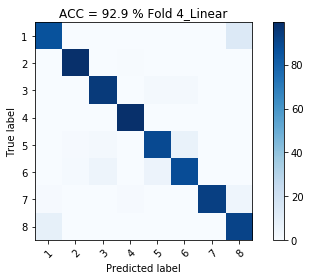



4it [01:57, 27.98s/it]

              precision    recall  f1-score   support

           1       0.90      0.86      0.88       275
           2       0.97      0.99      0.98       274
           3       0.93      0.95      0.94       274
           4       0.98      0.99      0.99       275
           5       0.92      0.89      0.91       275
           6       0.91      0.88      0.90       275
           7       0.99      0.93      0.96       275
           8       0.83      0.92      0.87       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.6s remaining:   49.3s
[Parallel(n_jobs=25)]: Done   3 out of

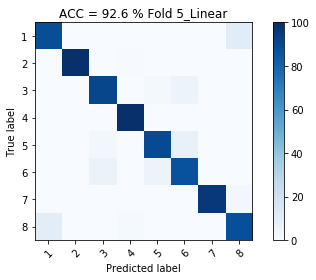



5it [02:32, 30.20s/it]

              precision    recall  f1-score   support

           1       0.89      0.88      0.89       275
           2       1.00      0.99      0.99       275
           3       0.91      0.91      0.91       274
           4       0.97      1.00      0.98       275
           5       0.92      0.90      0.91       274
           6       0.87      0.87      0.87       275
           7       0.99      0.97      0.98       275
           8       0.86      0.88      0.87       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.7s remaining:   56.4s
[Parallel(n_jobs=25)]: Done   3 out of

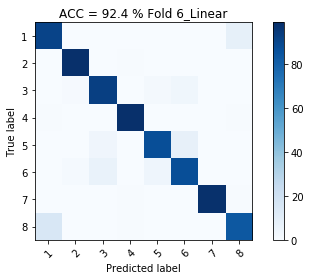



6it [03:17, 34.75s/it]

              precision    recall  f1-score   support

           1       0.85      0.91      0.88       275
           2       0.97      0.99      0.98       275
           3       0.90      0.93      0.91       275
           4       0.98      0.99      0.98       275
           5       0.93      0.88      0.90       274
           6       0.88      0.88      0.88       274
           7       0.99      0.98      0.99       275
           8       0.89      0.84      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.0s remaining:   12.8s
[Parallel(n_jobs=25)]: Done   3 out of

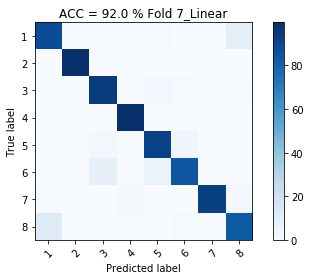



7it [05:14, 59.32s/it]

              precision    recall  f1-score   support

           1       0.86      0.89      0.87       275
           2       0.98      1.00      0.99       275
           3       0.89      0.95      0.92       275
           4       0.96      0.99      0.98       275
           5       0.90      0.93      0.91       274
           6       0.92      0.85      0.88       275
           7       0.99      0.93      0.96       275
           8       0.86      0.83      0.85       274

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.6s remaining:   49.1s
[Parallel(n_jobs=25)]: Done   3 out of

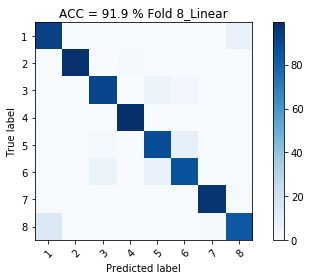



8it [05:40, 49.42s/it]

              precision    recall  f1-score   support

           1       0.86      0.92      0.89       274
           2       0.98      0.98      0.98       275
           3       0.91      0.91      0.91       275
           4       0.97      0.99      0.98       275
           5       0.87      0.88      0.88       275
           6       0.88      0.86      0.87       275
           7       0.98      0.97      0.98       274
           8       0.91      0.84      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.1s remaining:   52.8s
[Parallel(n_jobs=25)]: Done   3 out of

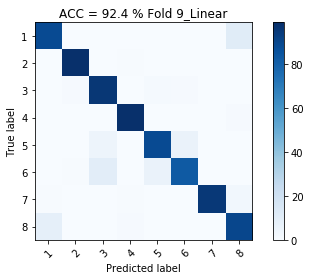



9it [06:13, 44.32s/it]

              precision    recall  f1-score   support

           1       0.90      0.89      0.89       275
           2       0.98      0.99      0.99       275
           3       0.86      0.96      0.91       274
           4       0.97      0.99      0.98       275
           5       0.92      0.89      0.90       275
           6       0.92      0.83      0.87       275
           7       1.00      0.96      0.98       274
           8       0.86      0.90      0.88       275

    accuracy                           0.92      2198
   macro avg       0.93      0.92      0.92      2198
weighted avg       0.93      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    3.1s remaining:   20.2s
[Parallel(n_jobs=25)]: Done   3 out o

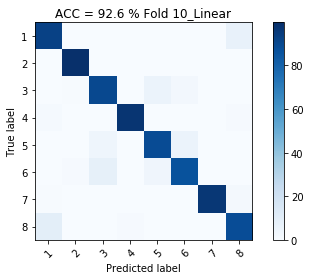



10it [06:39, 39.98s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.89      0.93      0.91       275
           2       0.98      1.00      0.99       275
           3       0.88      0.90      0.89       275
           4       0.98      0.97      0.98       275
           5       0.90      0.89      0.89       275
           6       0.91      0.86      0.89       274
           7       1.00      0.97      0.98       274
           8       0.89      0.89      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Region =  8/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.2s remaining:   53.2s
[Parallel(n_jobs=25)]: 

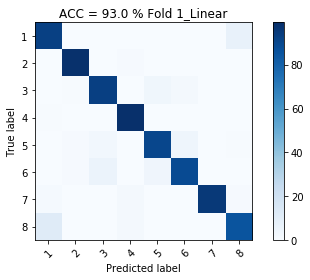



1it [00:25, 25.44s/it]

              precision    recall  f1-score   support

           1       0.87      0.93      0.90       275
           2       0.97      0.99      0.98       274
           3       0.91      0.93      0.92       275
           4       0.95      0.99      0.97       275
           5       0.92      0.91      0.91       275
           6       0.93      0.89      0.91       274
           7       1.00      0.96      0.98       275
           8       0.90      0.85      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.9s remaining:   51.3s
[Parallel(n_jobs=25)]: Done   3 out of

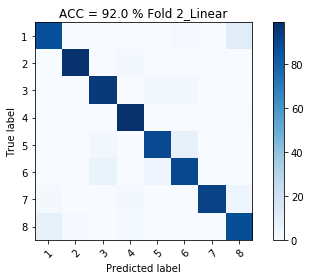



2it [01:15, 32.70s/it]

              precision    recall  f1-score   support

           1       0.89      0.87      0.88       275
           2       0.99      0.98      0.98       275
           3       0.91      0.95      0.93       274
           4       0.95      0.99      0.97       275
           5       0.92      0.89      0.91       275
           6       0.88      0.89      0.89       275
           7       0.99      0.92      0.95       274
           8       0.84      0.88      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    9.8s remaining:  1.1min
[Parallel(n_jobs=25)]: Done   3 out of

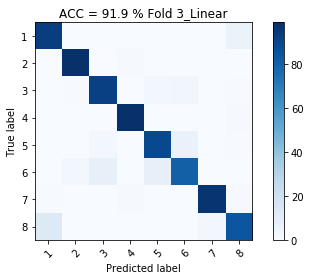



3it [01:37, 29.66s/it]

              precision    recall  f1-score   support

           1       0.87      0.93      0.90       275
           2       0.96      0.99      0.97       274
           3       0.89      0.92      0.91       275
           4       0.97      0.99      0.98       275
           5       0.89      0.89      0.89       274
           6       0.89      0.81      0.85       275
           7       0.97      0.97      0.97       275
           8       0.89      0.84      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.8s remaining:   18.0s
[Parallel(n_jobs=25)]: Done   3 out of

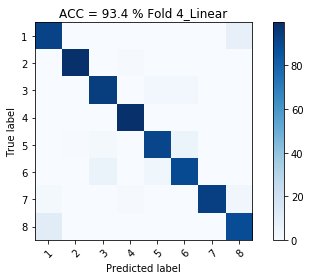



4it [02:16, 32.47s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.90       275
           2       0.99      0.99      0.99       274
           3       0.92      0.95      0.93       274
           4       0.98      1.00      0.99       275
           5       0.94      0.91      0.92       275
           6       0.91      0.89      0.90       275
           7       1.00      0.93      0.96       275
           8       0.88      0.88      0.88       275

    accuracy                           0.93      2198
   macro avg       0.94      0.93      0.93      2198
weighted avg       0.94      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.9s remaining:   57.7s
[Parallel(n_jobs=25)]: Done   3 out of

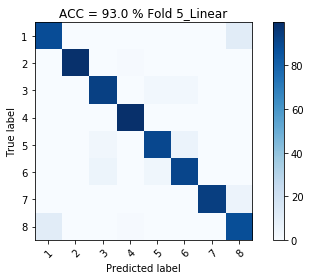



5it [03:02, 36.52s/it]

              precision    recall  f1-score   support

           1       0.89      0.89      0.89       275
           2       1.00      0.99      0.99       275
           3       0.92      0.93      0.92       274
           4       0.97      1.00      0.98       275
           5       0.93      0.91      0.92       274
           6       0.91      0.91      0.91       275
           7       1.00      0.94      0.97       275
           8       0.83      0.88      0.86       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    2.9s remaining:   18.7s
[Parallel(n_jobs=25)]: Done   3 out of

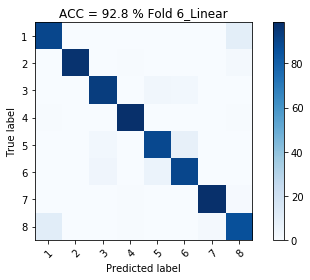



6it [03:41, 37.30s/it]

              precision    recall  f1-score   support

           1       0.89      0.90      0.89       275
           2       1.00      0.97      0.98       275
           3       0.93      0.93      0.93       275
           4       0.98      0.99      0.98       275
           5       0.91      0.89      0.90       274
           6       0.89      0.90      0.89       274
           7       0.97      0.98      0.98       275
           8       0.86      0.87      0.86       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.2s remaining:   34.0s
[Parallel(n_jobs=25)]: Done   3 out of

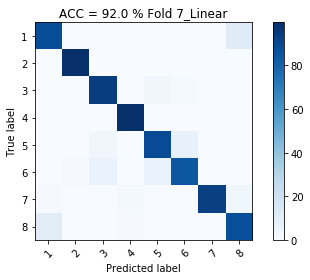



7it [04:14, 36.01s/it]

              precision    recall  f1-score   support

           1       0.88      0.88      0.88       275
           2       0.99      1.00      0.99       275
           3       0.90      0.94      0.92       275
           4       0.97      0.99      0.98       275
           5       0.89      0.89      0.89       274
           6       0.91      0.85      0.88       275
           7       0.99      0.93      0.96       275
           8       0.84      0.88      0.86       274

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    3.5s remaining:   22.7s
[Parallel(n_jobs=25)]: Done   3 out of

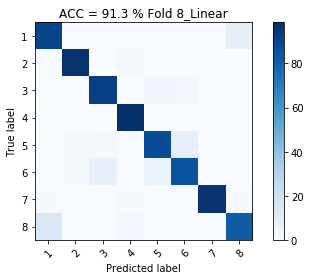



8it [04:44, 34.13s/it]

              precision    recall  f1-score   support

           1       0.84      0.91      0.87       274
           2       0.97      0.97      0.97       275
           3       0.90      0.93      0.91       275
           4       0.95      0.99      0.97       275
           5       0.90      0.88      0.89       275
           6       0.88      0.85      0.86       275
           7       0.99      0.97      0.98       274
           8       0.88      0.82      0.85       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.3s remaining:   47.6s
[Parallel(n_jobs=25)]: Done   3 out of

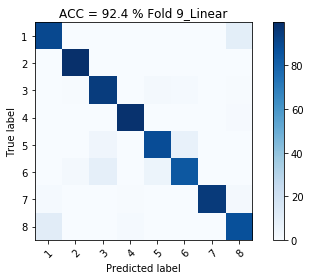



9it [05:10, 31.66s/it]

              precision    recall  f1-score   support

           1       0.87      0.90      0.89       275
           2       0.97      1.00      0.98       275
           3       0.88      0.95      0.91       274
           4       0.97      0.99      0.98       275
           5       0.92      0.88      0.90       275
           6       0.91      0.84      0.87       275
           7       1.00      0.96      0.98       274
           8       0.86      0.87      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    3.5s remaining:   23.0s
[Parallel(n_jobs=25)]: Done   3 out o

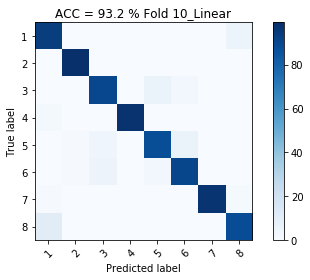



10it [05:33, 33.34s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.87      0.94      0.90       275
           2       0.97      0.99      0.98       275
           3       0.90      0.90      0.90       275
           4       0.99      0.98      0.99       275
           5       0.90      0.88      0.89       275
           6       0.91      0.91      0.91       274
           7       0.99      0.97      0.98       274
           8       0.92      0.88      0.90       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Region =  9/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   10.0s remaining:  1.1min
[Parallel(n_jobs=25)]: 

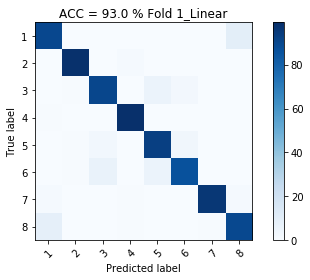



1it [00:38, 38.14s/it]

              precision    recall  f1-score   support

           1       0.89      0.90      0.90       275
           2       0.98      0.99      0.98       274
           3       0.90      0.91      0.90       275
           4       0.97      0.99      0.98       275
           5       0.89      0.93      0.91       275
           6       0.94      0.86      0.90       274
           7       0.99      0.96      0.98       275
           8       0.89      0.90      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.1s remaining:   52.7s
[Parallel(n_jobs=25)]: Done   3 out of

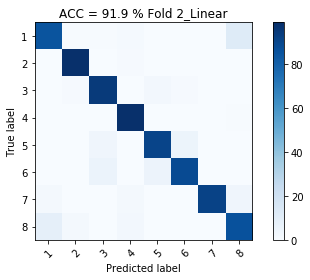



2it [01:49, 48.18s/it]

              precision    recall  f1-score   support

           1       0.89      0.85      0.87       275
           2       0.96      0.99      0.98       275
           3       0.90      0.95      0.92       274
           4       0.93      0.99      0.96       275
           5       0.92      0.91      0.91       275
           6       0.93      0.89      0.91       275
           7       1.00      0.92      0.96       274
           8       0.84      0.86      0.85       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.8s remaining:   50.6s
[Parallel(n_jobs=25)]: Done   3 out of

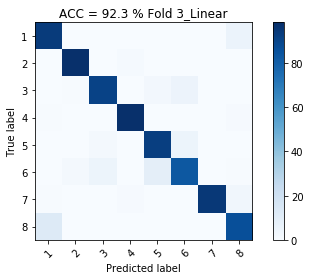



3it [02:12, 40.50s/it]

              precision    recall  f1-score   support

           1       0.87      0.94      0.90       275
           2       0.97      0.98      0.98       274
           3       0.93      0.91      0.92       275
           4       0.97      0.98      0.98       275
           5       0.89      0.93      0.91       274
           6       0.89      0.83      0.86       275
           7       0.99      0.95      0.97       275
           8       0.88      0.87      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    4.3s remaining:   27.9s
[Parallel(n_jobs=25)]: Done   3 out of

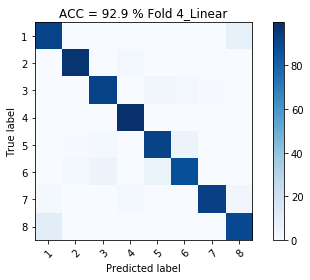



4it [02:39, 36.39s/it]

              precision    recall  f1-score   support

           1       0.88      0.92      0.90       275
           2       0.97      0.97      0.97       274
           3       0.93      0.92      0.93       274
           4       0.96      1.00      0.98       275
           5       0.92      0.92      0.92       275
           6       0.91      0.88      0.89       275
           7       0.99      0.93      0.96       275
           8       0.88      0.90      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    3.3s remaining:   21.7s
[Parallel(n_jobs=25)]: Done   3 out of

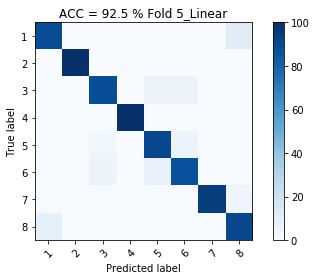



5it [03:47, 46.07s/it]

              precision    recall  f1-score   support

           1       0.91      0.89      0.90       275
           2       1.00      0.99      0.99       275
           3       0.91      0.88      0.89       274
           4       0.98      1.00      0.99       275
           5       0.88      0.91      0.89       274
           6       0.89      0.87      0.88       275
           7       0.99      0.95      0.97       275
           8       0.86      0.91      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    9.6s remaining:  1.0min
[Parallel(n_jobs=25)]: Done   3 out of

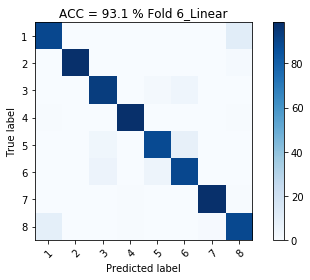



6it [04:35, 46.71s/it]

              precision    recall  f1-score   support

           1       0.90      0.89      0.90       275
           2       1.00      0.98      0.99       275
           3       0.91      0.93      0.92       275
           4       0.98      0.99      0.98       275
           5       0.93      0.88      0.90       274
           6       0.88      0.89      0.89       274
           7       0.99      0.99      0.99       275
           8       0.87      0.89      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.5s remaining:   55.2s
[Parallel(n_jobs=25)]: Done   3 out of

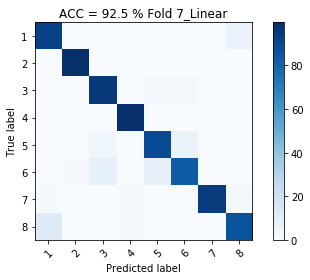



7it [05:27, 48.13s/it]

              precision    recall  f1-score   support

           1       0.87      0.93      0.90       275
           2       0.98      1.00      0.99       275
           3       0.89      0.96      0.92       275
           4       0.97      1.00      0.98       275
           5       0.90      0.89      0.90       274
           6       0.91      0.83      0.86       275
           7       0.99      0.95      0.97       275
           8       0.89      0.86      0.88       274

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.92      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   10.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   10.9s remaining:  1.2min
[Parallel(n_jobs=25)]: Done   3 out of

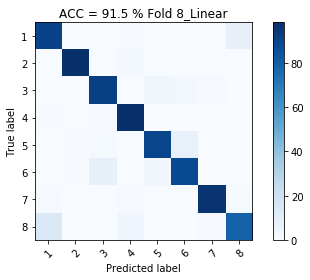



8it [06:54, 59.85s/it]

              precision    recall  f1-score   support

           1       0.85      0.91      0.88       274
           2       0.98      0.98      0.98       275
           3       0.89      0.92      0.91       275
           4       0.92      0.98      0.95       275
           5       0.93      0.90      0.91       275
           6       0.90      0.88      0.89       275
           7       0.97      0.96      0.97       274
           8       0.89      0.79      0.84       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.91      2198
weighted avg       0.92      0.92      0.91      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    4.1s remaining:   26.3s
[Parallel(n_jobs=25)]: Done   3 out of

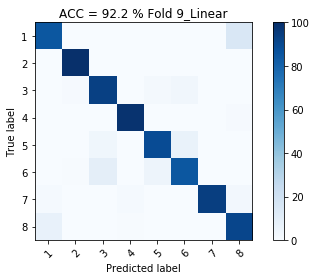



9it [07:25, 51.10s/it]

              precision    recall  f1-score   support

           1       0.90      0.85      0.87       275
           2       0.98      1.00      0.99       275
           3       0.88      0.93      0.90       274
           4       0.98      0.99      0.98       275
           5       0.93      0.89      0.91       275
           6       0.89      0.85      0.87       275
           7       1.00      0.95      0.97       274
           8       0.83      0.92      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.7s remaining:   50.3s
[Parallel(n_jobs=25)]: Done   3 out o

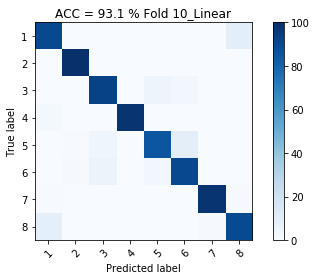



10it [08:02, 48.30s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.89      0.91      0.90       275
           2       0.98      1.00      0.99       275
           3       0.90      0.93      0.92       275
           4       0.99      0.98      0.99       275
           5       0.92      0.85      0.89       275
           6       0.88      0.91      0.89       274
           7       0.99      0.98      0.98       274
           8       0.89      0.90      0.90       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Region =  10/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    9.3s remaining:  1.0min
[Parallel(n_jobs=25)]:

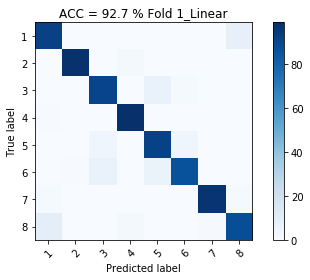



1it [00:47, 47.77s/it]

              precision    recall  f1-score   support

           1       0.89      0.92      0.90       275
           2       0.99      0.98      0.98       274
           3       0.89      0.91      0.90       275
           4       0.96      0.99      0.97       275
           5       0.88      0.92      0.90       275
           6       0.94      0.86      0.90       274
           7       0.99      0.97      0.98       275
           8       0.90      0.88      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    9.2s remaining:   59.6s
[Parallel(n_jobs=25)]: Done   3 out of

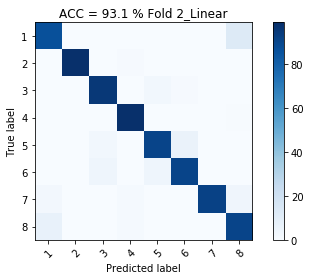



2it [01:32, 46.83s/it]

              precision    recall  f1-score   support

           1       0.89      0.87      0.88       275
           2       1.00      0.99      0.99       275
           3       0.93      0.96      0.94       274
           4       0.96      0.99      0.97       275
           5       0.93      0.91      0.92       275
           6       0.93      0.91      0.92       275
           7       1.00      0.92      0.96       274
           8       0.84      0.91      0.87       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    3.4s remaining:   22.3s
[Parallel(n_jobs=25)]: Done   3 out of

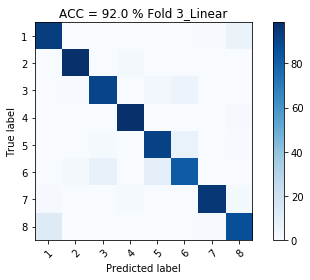



3it [02:10, 44.27s/it]

              precision    recall  f1-score   support

           1       0.87      0.93      0.90       275
           2       0.97      0.98      0.98       274
           3       0.91      0.91      0.91       275
           4       0.96      0.99      0.97       275
           5       0.89      0.91      0.90       274
           6       0.87      0.82      0.84       275
           7       0.99      0.96      0.97       275
           8       0.90      0.87      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    3.1s remaining:   20.0s
[Parallel(n_jobs=25)]: Done   3 out of

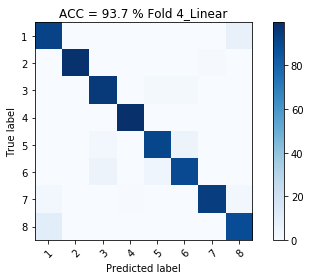



4it [02:45, 41.49s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.89       275
           2       0.99      0.99      0.99       274
           3       0.92      0.96      0.94       274
           4       0.99      1.00      0.99       275
           5       0.93      0.91      0.92       275
           6       0.92      0.90      0.91       275
           7       0.98      0.94      0.96       275
           8       0.90      0.89      0.89       275

    accuracy                           0.94      2198
   macro avg       0.94      0.94      0.94      2198
weighted avg       0.94      0.94      0.94      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    9.9s remaining:  1.1min
[Parallel(n_jobs=25)]: Done   3 out of

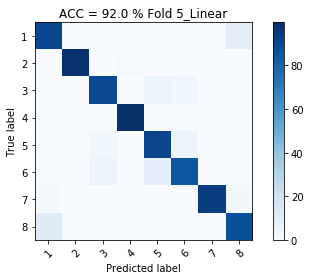



5it [04:18, 56.76s/it]

              precision    recall  f1-score   support

           1       0.87      0.91      0.89       275
           2       1.00      0.99      0.99       275
           3       0.90      0.90      0.90       274
           4       0.97      1.00      0.98       275
           5       0.86      0.91      0.89       274
           6       0.90      0.85      0.87       275
           7       1.00      0.94      0.97       275
           8       0.87      0.87      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   10.4s remaining:  1.1min
[Parallel(n_jobs=25)]: Done   3 out of

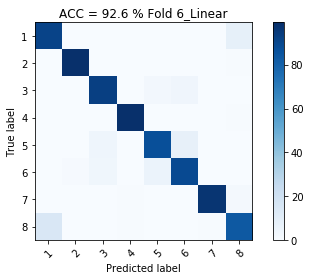



6it [05:04, 53.74s/it]

              precision    recall  f1-score   support

           1       0.85      0.92      0.88       275
           2       0.99      0.99      0.99       275
           3       0.92      0.93      0.93       275
           4       0.99      0.99      0.99       275
           5       0.91      0.88      0.89       274
           6       0.88      0.89      0.89       274
           7       0.99      0.97      0.98       275
           8       0.88      0.84      0.86       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.5s remaining:   49.0s
[Parallel(n_jobs=25)]: Done   3 out of

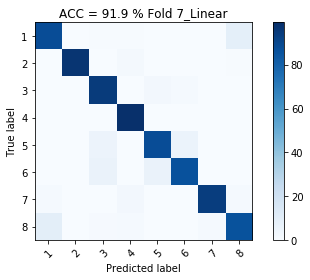



7it [07:06, 74.04s/it]

              precision    recall  f1-score   support

           1       0.88      0.88      0.88       275
           2       0.99      0.97      0.98       275
           3       0.87      0.95      0.91       275
           4       0.94      0.99      0.96       275
           5       0.90      0.88      0.89       274
           6       0.92      0.87      0.89       275
           7       0.98      0.94      0.96       275
           8       0.88      0.86      0.87       274

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    3.9s remaining:   25.2s
[Parallel(n_jobs=25)]: Done   3 out of

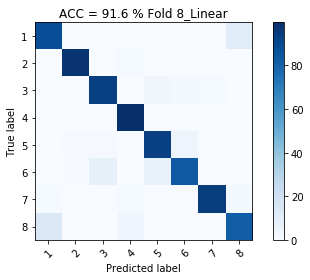



8it [07:51, 65.43s/it]

              precision    recall  f1-score   support

           1       0.85      0.88      0.86       274
           2       0.98      0.98      0.98       275
           3       0.90      0.93      0.92       275
           4       0.93      1.00      0.96       275
           5       0.90      0.93      0.92       275
           6       0.93      0.84      0.88       275
           7       0.98      0.95      0.97       274
           8       0.86      0.82      0.84       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    4.1s remaining:   26.7s
[Parallel(n_jobs=25)]: Done   3 out of

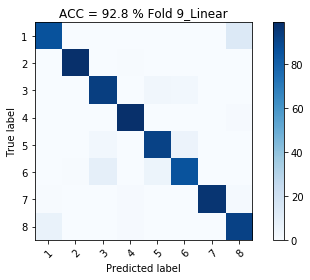



9it [08:24, 55.75s/it]

              precision    recall  f1-score   support

           1       0.91      0.86      0.89       275
           2       0.99      0.99      0.99       275
           3       0.89      0.93      0.91       274
           4       0.97      0.99      0.98       275
           5       0.92      0.92      0.92       275
           6       0.91      0.85      0.88       275
           7       1.00      0.97      0.98       274
           8       0.85      0.92      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    4.5s remaining:   29.3s
[Parallel(n_jobs=25)]: Done   3 out o

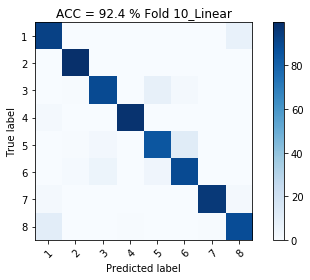



10it [09:04, 54.42s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.87      0.93      0.90       275
           2       0.97      1.00      0.98       275
           3       0.92      0.89      0.91       275
           4       0.99      0.98      0.98       275
           5       0.88      0.85      0.86       275
           6       0.87      0.89      0.88       274
           7       0.99      0.96      0.98       274
           8       0.91      0.88      0.90       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  11/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.1s remaining:   32.9s
[Parallel(n_jobs=25)]:

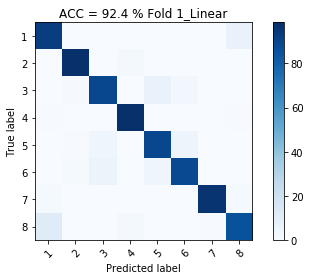



1it [00:44, 44.59s/it]

              precision    recall  f1-score   support

           1       0.87      0.93      0.90       275
           2       0.97      0.98      0.97       274
           3       0.90      0.89      0.90       275
           4       0.95      0.99      0.97       275
           5       0.89      0.89      0.89       275
           6       0.92      0.89      0.91       274
           7       0.99      0.97      0.98       275
           8       0.90      0.86      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.9s remaining:   57.9s
[Parallel(n_jobs=25)]: Done   3 out of

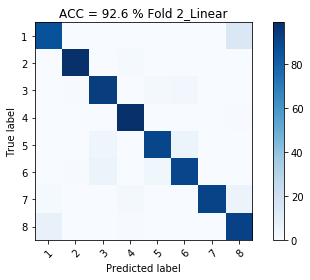



2it [01:18, 41.49s/it]

              precision    recall  f1-score   support

           1       0.90      0.86      0.88       275
           2       0.99      0.98      0.98       275
           3       0.91      0.94      0.92       274
           4       0.96      0.99      0.97       275
           5       0.94      0.90      0.92       275
           6       0.92      0.91      0.91       275
           7       1.00      0.91      0.95       274
           8       0.82      0.92      0.86       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   11.5s remaining:  1.2min
[Parallel(n_jobs=25)]: Done   3 out of

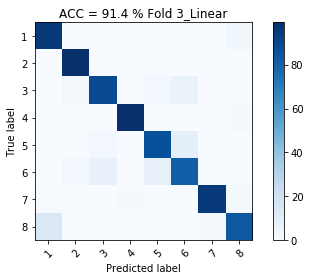



3it [01:49, 38.17s/it]

              precision    recall  f1-score   support

           1       0.87      0.96      0.91       275
           2       0.95      0.99      0.97       274
           3       0.89      0.89      0.89       275
           4       0.97      0.99      0.98       275
           5       0.89      0.87      0.88       274
           6       0.84      0.82      0.83       275
           7       0.99      0.96      0.97       275
           8       0.92      0.84      0.88       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   13.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   13.8s remaining:  1.5min
[Parallel(n_jobs=25)]: Done   3 out of

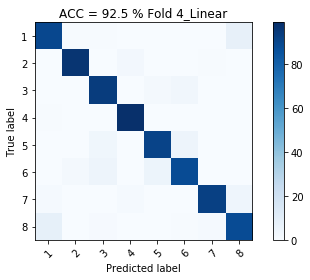



4it [03:03, 49.08s/it]

              precision    recall  f1-score   support

           1       0.89      0.90      0.90       275
           2       0.96      0.97      0.97       274
           3       0.90      0.94      0.92       274
           4       0.96      0.99      0.97       275
           5       0.93      0.91      0.92       275
           6       0.91      0.88      0.90       275
           7       0.98      0.92      0.95       275
           8       0.87      0.88      0.88       275

    accuracy                           0.92      2198
   macro avg       0.93      0.92      0.92      2198
weighted avg       0.93      0.92      0.92      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.3s remaining:   34.2s
[Parallel(n_jobs=25)]: Done   3 out of

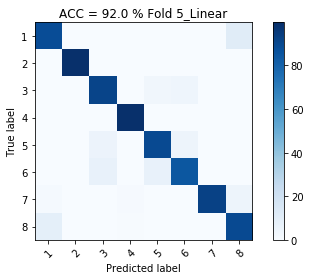



5it [04:46, 65.25s/it]

              precision    recall  f1-score   support

           1       0.89      0.88      0.89       275
           2       1.00      1.00      1.00       275
           3       0.87      0.92      0.89       274
           4       0.98      1.00      0.99       275
           5       0.89      0.90      0.89       274
           6       0.90      0.85      0.87       275
           7       1.00      0.93      0.96       275
           8       0.84      0.90      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   12.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   12.2s remaining:  1.3min
[Parallel(n_jobs=25)]: Done   3 out of

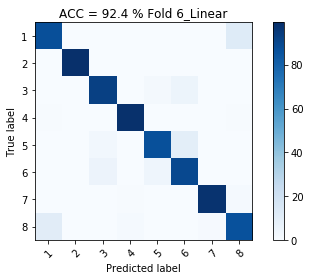



6it [05:54, 66.08s/it]

              precision    recall  f1-score   support

           1       0.88      0.87      0.88       275
           2       1.00      0.99      0.99       275
           3       0.92      0.93      0.92       275
           4       0.97      0.99      0.98       275
           5       0.93      0.87      0.90       274
           6       0.86      0.90      0.88       274
           7       0.99      0.98      0.98       275
           8       0.85      0.87      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    9.3s remaining:  1.0min
[Parallel(n_jobs=25)]: Done   3 out of

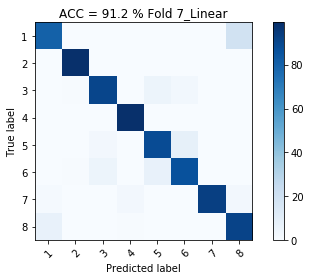



7it [06:53, 64.01s/it]

              precision    recall  f1-score   support

           1       0.90      0.80      0.85       275
           2       0.98      0.99      0.99       275
           3       0.92      0.91      0.91       275
           4       0.96      0.99      0.98       275
           5       0.87      0.89      0.88       274
           6       0.88      0.87      0.88       275
           7       1.00      0.93      0.96       275
           8       0.80      0.92      0.86       274

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   14.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   14.2s remaining:  1.5min
[Parallel(n_jobs=25)]: Done   3 out of

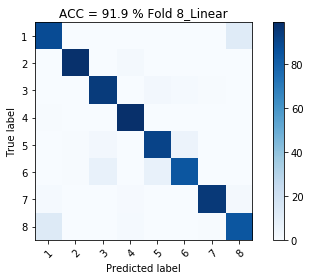



8it [08:38, 76.10s/it]

              precision    recall  f1-score   support

           1       0.85      0.88      0.87       274
           2       0.98      0.98      0.98       275
           3       0.90      0.95      0.92       275
           4       0.95      0.99      0.97       275
           5       0.90      0.91      0.91       275
           6       0.92      0.84      0.88       275
           7       0.98      0.95      0.97       274
           8       0.86      0.84      0.85       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   10.4s remaining:  1.1min
[Parallel(n_jobs=25)]: Done   3 out of

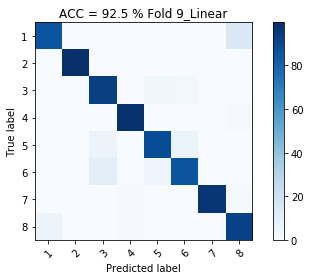



9it [09:18, 65.29s/it]

              precision    recall  f1-score   support

           1       0.93      0.85      0.89       275
           2       0.99      1.00      0.99       275
           3       0.86      0.93      0.89       274
           4       0.97      0.99      0.98       275
           5       0.92      0.88      0.90       275
           6       0.91      0.85      0.88       275
           7       0.99      0.97      0.98       274
           8       0.85      0.92      0.88       275

    accuracy                           0.92      2198
   macro avg       0.93      0.92      0.92      2198
weighted avg       0.93      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.8s remaining:   37.5s
[Parallel(n_jobs=25)]: Done   3 out o

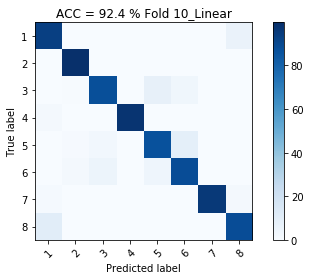



10it [09:48, 58.88s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.87      0.93      0.90       275
           2       0.96      1.00      0.98       275
           3       0.92      0.88      0.90       275
           4       0.99      0.98      0.98       275
           5       0.88      0.87      0.87       275
           6       0.87      0.89      0.88       274
           7       1.00      0.96      0.98       274
           8       0.91      0.89      0.90       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  12/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   12.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   12.3s remaining:  1.3min
[Parallel(n_jobs=25)]:

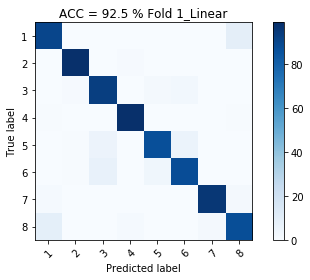



1it [00:38, 38.32s/it]

              precision    recall  f1-score   support

           1       0.89      0.91      0.90       275
           2       0.97      0.99      0.98       274
           3       0.88      0.93      0.90       275
           4       0.96      0.99      0.97       275
           5       0.94      0.87      0.90       275
           6       0.91      0.88      0.89       274
           7       0.98      0.96      0.97       275
           8       0.88      0.88      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   13.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   13.1s remaining:  1.4min
[Parallel(n_jobs=25)]: Done   3 out of

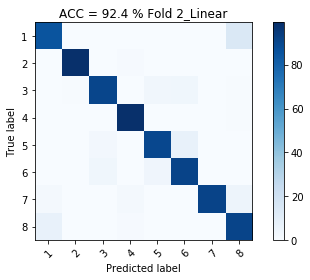



2it [01:18, 39.00s/it]

              precision    recall  f1-score   support

           1       0.90      0.85      0.88       275
           2       0.99      0.99      0.99       275
           3       0.94      0.91      0.92       274
           4       0.96      0.99      0.98       275
           5       0.93      0.90      0.91       275
           6       0.89      0.92      0.90       275
           7       1.00      0.92      0.95       274
           8       0.81      0.91      0.86       275

    accuracy                           0.92      2198
   macro avg       0.93      0.92      0.92      2198
weighted avg       0.93      0.92      0.92      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    4.3s remaining:   27.8s
[Parallel(n_jobs=25)]: Done   3 out of

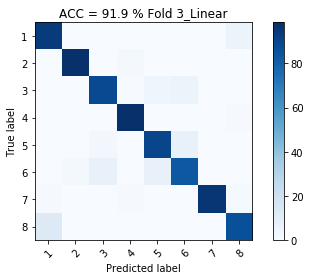



3it [01:50, 36.71s/it]

              precision    recall  f1-score   support

           1       0.87      0.94      0.91       275
           2       0.97      0.98      0.98       274
           3       0.89      0.89      0.89       275
           4       0.96      0.99      0.97       275
           5       0.88      0.90      0.89       274
           6       0.87      0.83      0.85       275
           7       0.99      0.96      0.98       275
           8       0.90      0.87      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.2s remaining:   33.9s
[Parallel(n_jobs=25)]: Done   3 out of

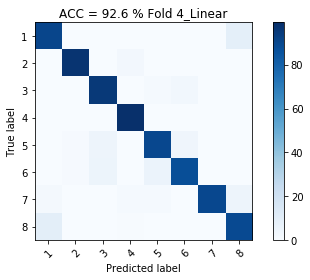



4it [02:39, 40.44s/it]

              precision    recall  f1-score   support

           1       0.88      0.91      0.89       275
           2       0.98      0.97      0.98       274
           3       0.91      0.96      0.93       274
           4       0.95      0.99      0.97       275
           5       0.91      0.90      0.91       275
           6       0.93      0.88      0.90       275
           7       1.00      0.90      0.95       275
           8       0.86      0.89      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.4s remaining:   35.2s
[Parallel(n_jobs=25)]: Done   3 out of

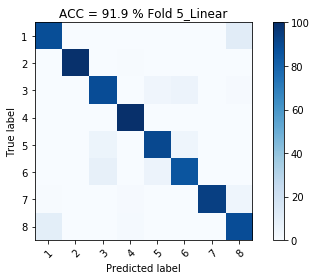



5it [04:57, 69.60s/it]

              precision    recall  f1-score   support

           1       0.89      0.88      0.89       275
           2       0.99      0.99      0.99       275
           3       0.87      0.89      0.88       274
           4       0.97      1.00      0.98       275
           5       0.90      0.91      0.90       274
           6       0.89      0.86      0.88       275
           7       1.00      0.94      0.97       275
           8       0.84      0.89      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.2s remaining:   53.2s
[Parallel(n_jobs=25)]: Done   3 out of

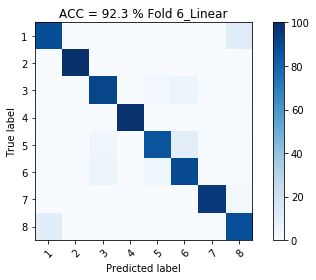



6it [06:00, 67.66s/it]

              precision    recall  f1-score   support

           1       0.88      0.88      0.88       275
           2       0.99      1.00      0.99       275
           3       0.91      0.91      0.91       275
           4       0.99      0.99      0.99       275
           5       0.92      0.86      0.89       274
           6       0.85      0.90      0.88       274
           7       1.00      0.96      0.98       275
           8       0.86      0.88      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.3s remaining:   34.2s
[Parallel(n_jobs=25)]: Done   3 out of

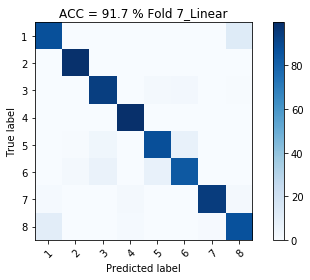



7it [07:03, 66.42s/it]

              precision    recall  f1-score   support

           1       0.88      0.87      0.88       275
           2       0.97      0.99      0.98       275
           3       0.90      0.94      0.92       275
           4       0.96      1.00      0.98       275
           5       0.90      0.88      0.89       274
           6       0.89      0.84      0.87       275
           7       0.98      0.95      0.96       275
           8       0.85      0.87      0.86       274

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    4.9s remaining:   32.0s
[Parallel(n_jobs=25)]: Done   3 out of

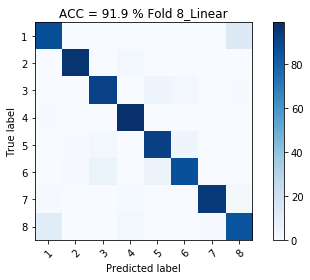



8it [08:21, 69.91s/it]

              precision    recall  f1-score   support

           1       0.87      0.88      0.87       274
           2       0.98      0.97      0.97       275
           3       0.91      0.92      0.91       275
           4       0.93      0.99      0.96       275
           5       0.91      0.92      0.92       275
           6       0.93      0.87      0.90       275
           7       0.99      0.95      0.97       274
           8       0.84      0.85      0.85       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   13.0s remaining:  1.4min
[Parallel(n_jobs=25)]: Done   3 out of

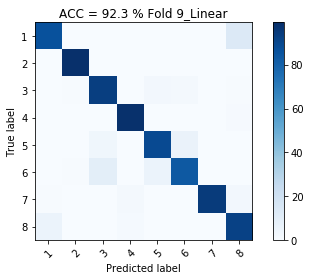



9it [09:32, 70.14s/it]

              precision    recall  f1-score   support

           1       0.93      0.87      0.89       275
           2       0.99      0.99      0.99       275
           3       0.87      0.94      0.90       274
           4       0.96      0.99      0.97       275
           5       0.91      0.89      0.90       275
           6       0.91      0.84      0.87       275
           7       0.99      0.95      0.97       274
           8       0.84      0.92      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    4.7s remaining:   30.5s
[Parallel(n_jobs=25)]: Done   3 out o

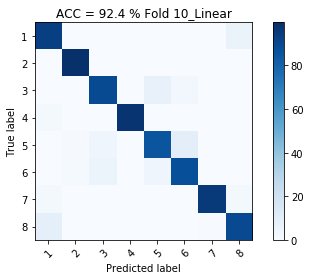



10it [10:08, 60.88s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.88      0.93      0.90       275
           2       0.97      1.00      0.98       275
           3       0.90      0.89      0.90       275
           4       0.99      0.98      0.98       275
           5       0.88      0.85      0.87       275
           6       0.88      0.88      0.88       274
           7       0.99      0.96      0.97       274
           8       0.91      0.90      0.91       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  13/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.1s remaining:   39.8s
[Parallel(n_jobs=25)]:

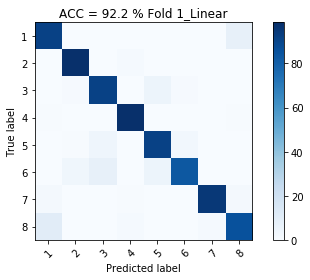



1it [00:45, 45.17s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.90       275
           2       0.95      0.99      0.97       274
           3       0.88      0.92      0.90       275
           4       0.96      0.99      0.97       275
           5       0.90      0.92      0.91       275
           6       0.95      0.83      0.89       274
           7       0.98      0.95      0.97       275
           8       0.88      0.86      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.1s remaining:   33.3s
[Parallel(n_jobs=25)]: Done   3 out of

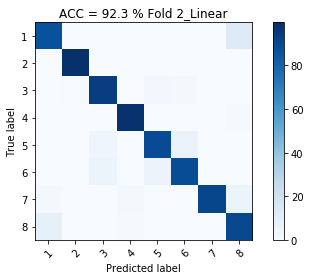



2it [01:33, 46.12s/it]

              precision    recall  f1-score   support

           1       0.89      0.87      0.88       275
           2       0.99      1.00      0.99       275
           3       0.91      0.94      0.93       274
           4       0.96      0.99      0.97       275
           5       0.92      0.89      0.90       275
           6       0.91      0.89      0.90       275
           7       1.00      0.91      0.95       274
           8       0.82      0.91      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    4.6s remaining:   30.0s
[Parallel(n_jobs=25)]: Done   3 out of

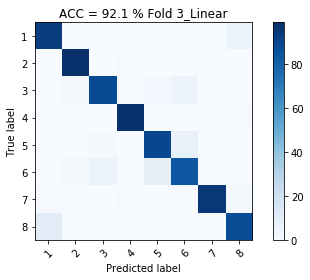



3it [02:25, 47.74s/it]

              precision    recall  f1-score   support

           1       0.89      0.94      0.91       275
           2       0.96      0.99      0.97       274
           3       0.91      0.89      0.90       275
           4       0.97      0.99      0.98       275
           5       0.89      0.90      0.89       274
           6       0.86      0.84      0.85       275
           7       0.99      0.96      0.97       275
           8       0.90      0.88      0.89       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.1s remaining:   52.8s
[Parallel(n_jobs=25)]: Done   3 out of

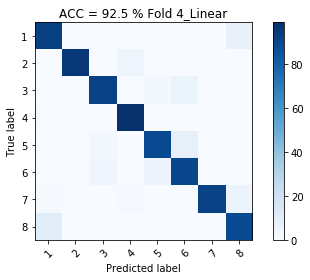



4it [03:01, 44.44s/it]

              precision    recall  f1-score   support

           1       0.88      0.93      0.90       275
           2       0.99      0.96      0.97       274
           3       0.93      0.92      0.93       274
           4       0.95      0.99      0.97       275
           5       0.93      0.89      0.91       275
           6       0.87      0.91      0.89       275
           7       0.99      0.92      0.95       275
           8       0.87      0.89      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.3s remaining:   34.4s
[Parallel(n_jobs=25)]: Done   3 out of

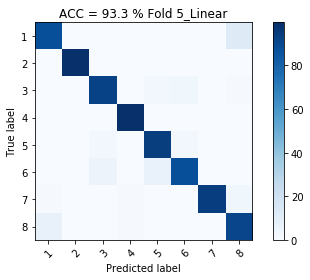



5it [05:57, 83.71s/it]

              precision    recall  f1-score   support

           1       0.91      0.88      0.89       275
           2       1.00      0.99      0.99       275
           3       0.92      0.92      0.92       274
           4       0.98      1.00      0.99       275
           5       0.91      0.95      0.93       274
           6       0.93      0.88      0.90       275
           7       1.00      0.94      0.97       275
           8       0.84      0.91      0.87       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   14.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   15.1s remaining:  1.6min
[Parallel(n_jobs=25)]: Done   3 out of

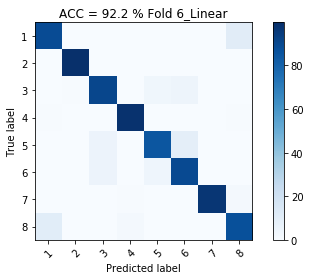



6it [07:28, 85.94s/it]

              precision    recall  f1-score   support

           1       0.89      0.89      0.89       275
           2       0.99      1.00      0.99       275
           3       0.89      0.91      0.90       275
           4       0.97      0.99      0.98       275
           5       0.91      0.85      0.88       274
           6       0.86      0.90      0.88       274
           7       1.00      0.97      0.98       275
           8       0.86      0.87      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   14.7s remaining:  1.6min
[Parallel(n_jobs=25)]: Done   3 out of

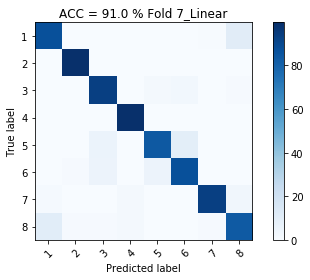



7it [10:32, 115.38s/it]

              precision    recall  f1-score   support

           1       0.88      0.87      0.87       275
           2       0.97      1.00      0.98       275
           3       0.88      0.93      0.91       275
           4       0.96      0.99      0.98       275
           5       0.91      0.84      0.87       274
           6       0.87      0.87      0.87       275
           7       0.98      0.93      0.96       275
           8       0.84      0.84      0.84       274

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.4s remaining:   35.2s
[Parallel(n_jobs=25)]: Done   3 out of

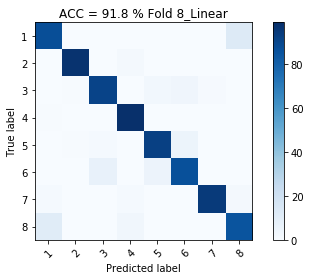



8it [11:44, 102.29s/it]

              precision    recall  f1-score   support

           1       0.87      0.88      0.87       274
           2       0.98      0.97      0.98       275
           3       0.91      0.91      0.91       275
           4       0.93      0.99      0.96       275
           5       0.92      0.92      0.92       275
           6       0.91      0.87      0.89       275
           7       0.98      0.95      0.97       274
           8       0.85      0.85      0.85       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   12.7s remaining:  1.4min
[Parallel(n_jobs=25)]: Done   3 out of

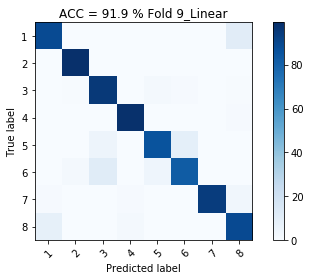



9it [12:49, 91.15s/it] 

              precision    recall  f1-score   support

           1       0.90      0.89      0.90       275
           2       0.97      0.99      0.98       275
           3       0.86      0.96      0.90       274
           4       0.97      0.99      0.98       275
           5       0.93      0.86      0.89       275
           6       0.89      0.83      0.85       275
           7       1.00      0.95      0.97       274
           8       0.85      0.89      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   15.1s remaining:  1.6min
[Parallel(n_jobs=25)]: Done   3 out o

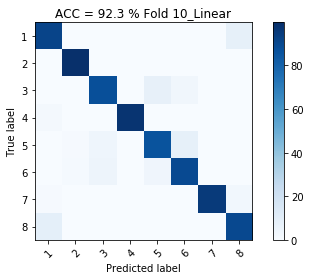



10it [13:35, 81.59s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.88      0.92      0.90       275
           2       0.97      1.00      0.98       275
           3       0.91      0.88      0.89       275
           4       0.99      0.98      0.98       275
           5       0.88      0.86      0.87       275
           6       0.88      0.90      0.89       274
           7       0.99      0.96      0.97       274
           8       0.89      0.90      0.90       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  14/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   12.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   14.3s remaining:  1.5min
[Parallel(n_jobs=25)]:

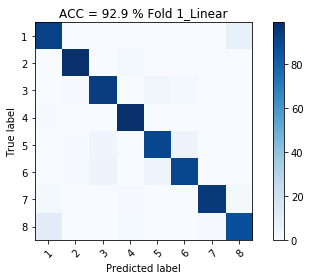



1it [00:44, 44.55s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.90       275
           2       0.97      0.98      0.98       274
           3       0.91      0.93      0.92       275
           4       0.95      0.99      0.97       275
           5       0.93      0.90      0.91       275
           6       0.92      0.90      0.91       274
           7       0.99      0.95      0.97       275
           8       0.89      0.87      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   18.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   18.6s remaining:  2.0min
[Parallel(n_jobs=25)]: Done   3 out of

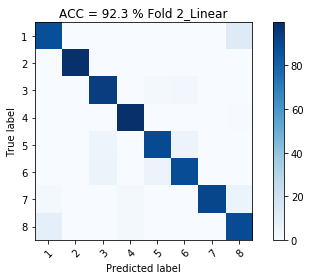



2it [01:43, 48.96s/it]

              precision    recall  f1-score   support

           1       0.88      0.88      0.88       275
           2       1.00      1.00      1.00       275
           3       0.90      0.94      0.92       274
           4       0.96      0.99      0.97       275
           5       0.92      0.89      0.91       275
           6       0.91      0.88      0.90       275
           7       1.00      0.91      0.95       274
           8       0.82      0.89      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.2s remaining:   33.9s
[Parallel(n_jobs=25)]: Done   3 out of

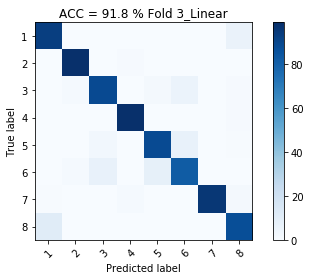



3it [02:20, 45.38s/it]

              precision    recall  f1-score   support

           1       0.89      0.93      0.91       275
           2       0.97      0.99      0.98       274
           3       0.89      0.89      0.89       275
           4       0.96      0.99      0.98       275
           5       0.89      0.89      0.89       274
           6       0.86      0.82      0.84       275
           7       1.00      0.96      0.98       275
           8       0.88      0.88      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   14.5s remaining:  1.6min
[Parallel(n_jobs=25)]: Done   3 out of

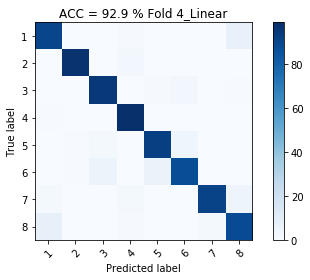



4it [03:40, 55.59s/it]

              precision    recall  f1-score   support

           1       0.90      0.91      0.90       275
           2       0.98      0.97      0.98       274
           3       0.93      0.96      0.94       274
           4       0.94      0.99      0.96       275
           5       0.92      0.93      0.92       275
           6       0.92      0.88      0.90       275
           7       0.98      0.91      0.94       275
           8       0.87      0.88      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   16.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   17.1s remaining:  1.9min
[Parallel(n_jobs=25)]: Done   3 out of

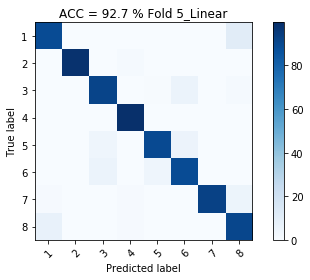



5it [06:16, 85.74s/it]

              precision    recall  f1-score   support

           1       0.91      0.89      0.90       275
           2       0.99      0.99      0.99       275
           3       0.89      0.92      0.90       274
           4       0.96      1.00      0.98       275
           5       0.95      0.90      0.92       274
           6       0.89      0.89      0.89       275
           7       0.99      0.93      0.96       275
           8       0.84      0.91      0.87       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   12.5s remaining:  1.4min
[Parallel(n_jobs=25)]: Done   3 out of

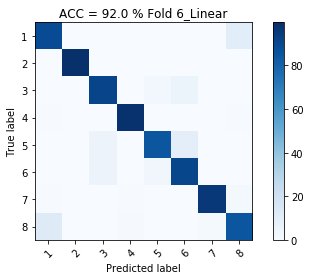



6it [07:41, 85.47s/it]

              precision    recall  f1-score   support

           1       0.87      0.89      0.88       275
           2       1.00      1.00      1.00       275
           3       0.89      0.92      0.90       275
           4       0.98      0.99      0.98       275
           5       0.93      0.85      0.89       274
           6       0.86      0.91      0.88       274
           7       0.98      0.96      0.97       275
           8       0.86      0.85      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   10.6s remaining:  1.2min
[Parallel(n_jobs=25)]: Done   3 out of

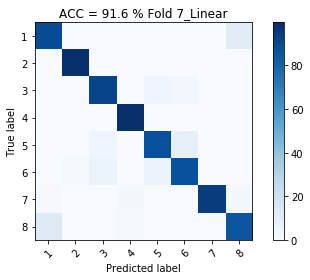



7it [09:18, 89.01s/it]

              precision    recall  f1-score   support

           1       0.86      0.88      0.87       275
           2       0.97      0.99      0.98       275
           3       0.90      0.92      0.91       275
           4       0.96      1.00      0.98       275
           5       0.90      0.87      0.89       274
           6       0.89      0.87      0.88       275
           7       0.99      0.95      0.97       275
           8       0.85      0.85      0.85       274

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.1s remaining:   33.1s
[Parallel(n_jobs=25)]: Done   3 out of

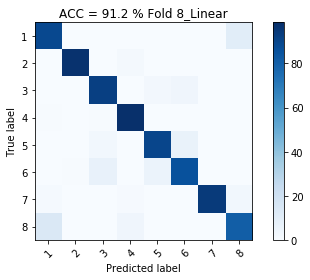



8it [13:35, 139.51s/it]

              precision    recall  f1-score   support

           1       0.84      0.89      0.87       274
           2       0.99      0.97      0.98       275
           3       0.89      0.93      0.91       275
           4       0.93      0.99      0.96       275
           5       0.92      0.90      0.91       275
           6       0.89      0.86      0.87       275
           7       1.00      0.95      0.97       274
           8       0.85      0.81      0.83       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   11.4s remaining:  1.2min
[Parallel(n_jobs=25)]: Done   3 out of

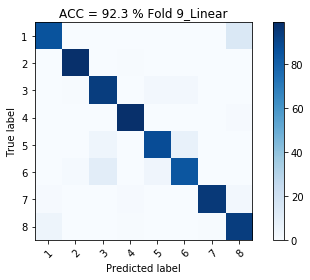



9it [14:38, 116.50s/it]

              precision    recall  f1-score   support

           1       0.93      0.85      0.89       275
           2       0.98      0.99      0.98       275
           3       0.87      0.94      0.90       274
           4       0.97      0.99      0.98       275
           5       0.93      0.88      0.90       275
           6       0.89      0.84      0.87       275
           7       0.99      0.95      0.97       274
           8       0.83      0.94      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.7s remaining:   43.7s
[Parallel(n_jobs=25)]: Done   3 out o

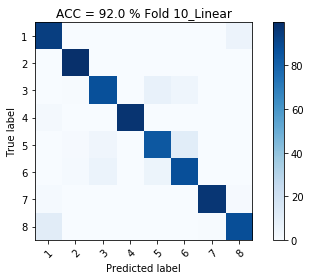



10it [15:17, 91.79s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.87      0.94      0.90       275
           2       0.97      1.00      0.98       275
           3       0.90      0.87      0.89       275
           4       0.99      0.98      0.98       275
           5       0.87      0.84      0.86       275
           6       0.85      0.88      0.86       274
           7       0.99      0.97      0.98       274
           8       0.93      0.88      0.90       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  15/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   19.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   19.9s remaining:  2.2min
[Parallel(n_jobs=25)]:

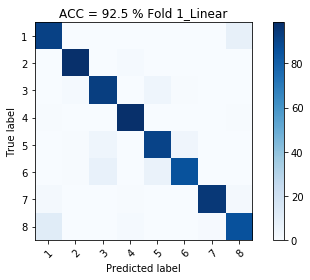



1it [00:56, 56.19s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.89       275
           2       0.97      0.99      0.98       274
           3       0.89      0.93      0.91       275
           4       0.96      0.99      0.97       275
           5       0.90      0.91      0.90       275
           6       0.95      0.86      0.90       274
           7       0.99      0.95      0.97       275
           8       0.89      0.86      0.87       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   19.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   19.3s remaining:  2.1min
[Parallel(n_jobs=25)]: Done   3 out of

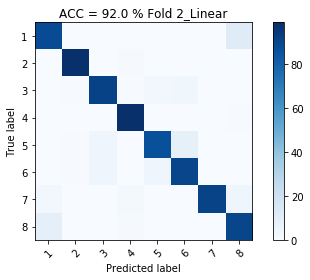



2it [02:01, 58.95s/it]

              precision    recall  f1-score   support

           1       0.88      0.88      0.88       275
           2       0.98      0.99      0.98       275
           3       0.92      0.92      0.92       274
           4       0.95      0.99      0.97       275
           5       0.92      0.87      0.90       275
           6       0.88      0.91      0.89       275
           7       1.00      0.91      0.95       274
           8       0.84      0.90      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   15.1s remaining:  1.6min
[Parallel(n_jobs=25)]: Done   3 out of

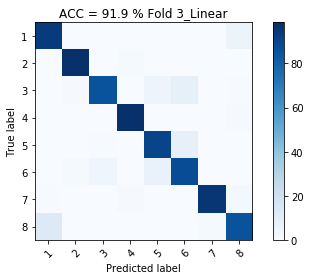



3it [02:58, 58.40s/it]

              precision    recall  f1-score   support

           1       0.88      0.94      0.91       275
           2       0.97      0.98      0.98       274
           3       0.94      0.85      0.89       275
           4       0.97      0.99      0.98       275
           5       0.89      0.91      0.90       274
           6       0.84      0.88      0.86       275
           7       0.99      0.96      0.97       275
           8       0.89      0.85      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    9.0s remaining:   58.7s
[Parallel(n_jobs=25)]: Done   3 out of

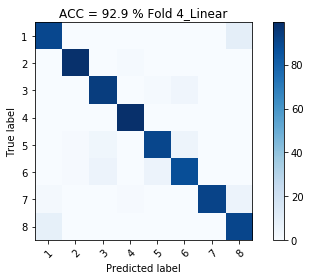



4it [04:03, 60.33s/it]

              precision    recall  f1-score   support

           1       0.90      0.90      0.90       275
           2       0.98      0.99      0.98       274
           3       0.91      0.94      0.93       274
           4       0.96      0.99      0.98       275
           5       0.93      0.91      0.92       275
           6       0.91      0.88      0.89       275
           7       1.00      0.92      0.95       275
           8       0.86      0.91      0.88       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.0s remaining:   39.0s
[Parallel(n_jobs=25)]: Done   3 out of

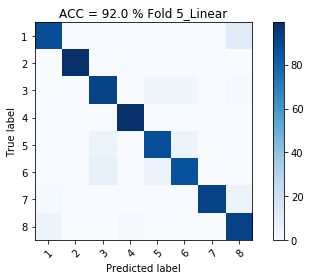



5it [07:11, 98.67s/it]

              precision    recall  f1-score   support

           1       0.91      0.88      0.89       275
           2       1.00      0.99      0.99       275
           3       0.86      0.92      0.89       274
           4       0.98      0.99      0.99       275
           5       0.91      0.88      0.89       274
           6       0.90      0.86      0.88       275
           7       1.00      0.92      0.96       275
           8       0.83      0.92      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.6s remaining:   42.8s
[Parallel(n_jobs=25)]: Done   3 out of

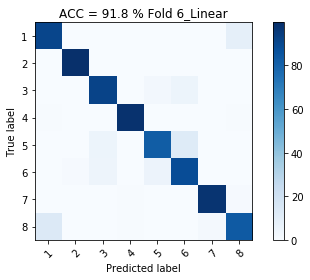



6it [08:38, 95.08s/it]

              precision    recall  f1-score   support

           1       0.86      0.91      0.89       275
           2       0.99      1.00      0.99       275
           3       0.90      0.92      0.91       275
           4       0.98      0.99      0.98       275
           5       0.91      0.82      0.87       274
           6       0.84      0.89      0.86       274
           7       0.98      0.98      0.98       275
           8       0.89      0.84      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.4s remaining:   41.4s
[Parallel(n_jobs=25)]: Done   3 out of

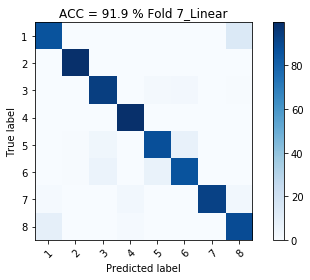



7it [10:38, 102.72s/it]

              precision    recall  f1-score   support

           1       0.89      0.86      0.88       275
           2       0.98      1.00      0.99       275
           3       0.91      0.94      0.92       275
           4       0.96      1.00      0.98       275
           5       0.91      0.88      0.89       274
           6       0.89      0.86      0.88       275
           7       0.99      0.93      0.96       275
           8       0.83      0.89      0.86       274

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.0s remaining:   39.2s
[Parallel(n_jobs=25)]: Done   3 out of

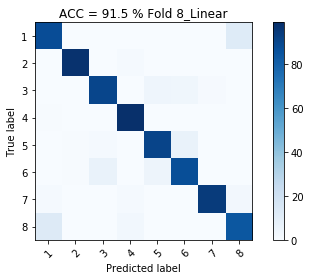



8it [12:22, 102.95s/it]

              precision    recall  f1-score   support

           1       0.85      0.88      0.87       274
           2       0.98      0.98      0.98       275
           3       0.91      0.91      0.91       275
           4       0.94      0.99      0.97       275
           5       0.91      0.91      0.91       275
           6       0.89      0.88      0.88       275
           7       0.98      0.95      0.96       274
           8       0.85      0.84      0.84       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.8s remaining:   44.0s
[Parallel(n_jobs=25)]: Done   3 out of

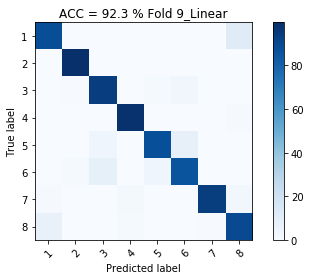



9it [13:55, 99.85s/it] 

              precision    recall  f1-score   support

           1       0.91      0.88      0.89       275
           2       0.98      1.00      0.99       275
           3       0.88      0.94      0.91       274
           4       0.96      0.99      0.97       275
           5       0.94      0.88      0.91       275
           6       0.88      0.86      0.87       275
           7       0.99      0.95      0.97       274
           8       0.85      0.90      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   16.6s remaining:  1.8min
[Parallel(n_jobs=25)]: Done   3 out o

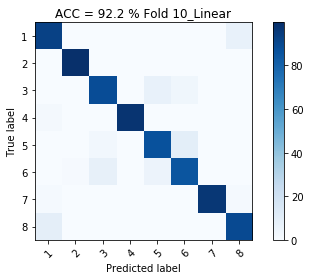



10it [15:17, 91.79s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.88      0.93      0.90       275
           2       0.99      1.00      0.99       275
           3       0.89      0.88      0.89       275
           4       0.99      0.98      0.98       275
           5       0.87      0.87      0.87       275
           6       0.86      0.85      0.86       274
           7       1.00      0.97      0.98       274
           8       0.91      0.90      0.90       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  16/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   15.9s remaining:  1.7min
[Parallel(n_jobs=25)]:

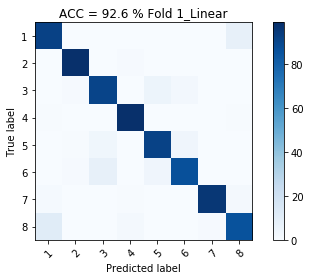



1it [01:16, 76.38s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.90       275
           2       0.97      0.99      0.98       274
           3       0.89      0.91      0.90       275
           4       0.96      0.99      0.97       275
           5       0.91      0.92      0.91       275
           6       0.93      0.87      0.90       274
           7       0.99      0.96      0.97       275
           8       0.89      0.86      0.87       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.2s remaining:   46.9s
[Parallel(n_jobs=25)]: Done   3 out of

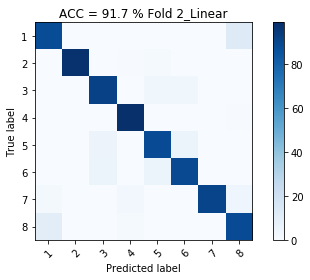



2it [02:48, 80.99s/it]

              precision    recall  f1-score   support

           1       0.87      0.88      0.88       275
           2       0.99      0.98      0.99       275
           3       0.90      0.92      0.91       274
           4       0.95      0.99      0.97       275
           5       0.90      0.88      0.89       275
           6       0.90      0.89      0.90       275
           7       1.00      0.91      0.95       274
           8       0.84      0.88      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.0s remaining:   45.5s
[Parallel(n_jobs=25)]: Done   3 out of

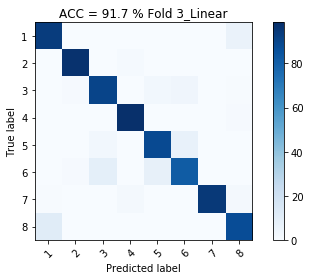



3it [03:52, 76.09s/it]

              precision    recall  f1-score   support

           1       0.88      0.94      0.91       275
           2       0.97      0.97      0.97       274
           3       0.88      0.91      0.89       275
           4       0.96      0.99      0.97       275
           5       0.88      0.89      0.89       274
           6       0.87      0.82      0.84       275
           7       0.99      0.95      0.97       275
           8       0.89      0.88      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.4s remaining:   41.7s
[Parallel(n_jobs=25)]: Done   3 out of

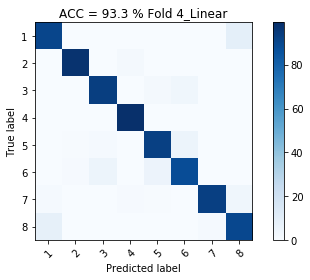



4it [04:40, 67.62s/it]

              precision    recall  f1-score   support

           1       0.90      0.91      0.90       275
           2       0.98      0.98      0.98       274
           3       0.93      0.94      0.94       274
           4       0.97      0.99      0.98       275
           5       0.92      0.93      0.92       275
           6       0.91      0.88      0.90       275
           7       0.98      0.93      0.96       275
           8       0.87      0.90      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   15.5s remaining:  1.7min
[Parallel(n_jobs=25)]: Done   3 out of

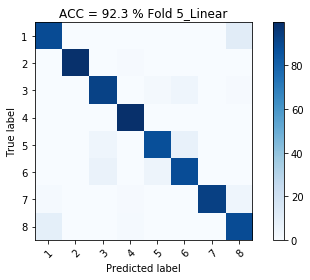



5it [08:14, 111.55s/it]

              precision    recall  f1-score   support

           1       0.89      0.89      0.89       275
           2       0.99      0.99      0.99       275
           3       0.89      0.92      0.91       274
           4       0.96      1.00      0.98       275
           5       0.93      0.88      0.90       274
           6       0.88      0.89      0.88       275
           7       1.00      0.93      0.96       275
           8       0.84      0.89      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.9s remaining:   38.3s
[Parallel(n_jobs=25)]: Done   3 out of

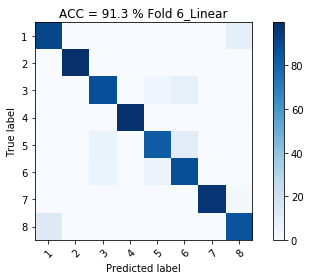



6it [09:56, 108.65s/it]

              precision    recall  f1-score   support

           1       0.87      0.91      0.89       275
           2       0.99      1.00      0.99       275
           3       0.88      0.88      0.88       275
           4       0.98      0.99      0.98       275
           5       0.89      0.82      0.86       274
           6       0.82      0.88      0.85       274
           7       1.00      0.97      0.98       275
           8       0.88      0.86      0.87       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   12.1s remaining:  1.3min
[Parallel(n_jobs=25)]: Done   3 out of

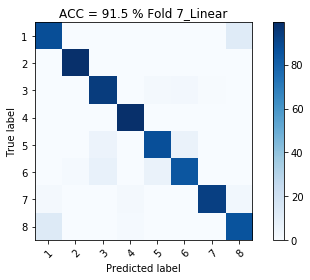



7it [11:41, 107.59s/it]

              precision    recall  f1-score   support

           1       0.86      0.88      0.87       275
           2       0.98      0.99      0.99       275
           3       0.88      0.95      0.91       275
           4       0.96      0.99      0.98       275
           5       0.91      0.88      0.89       274
           6       0.90      0.85      0.87       275
           7       0.99      0.93      0.96       275
           8       0.84      0.86      0.85       274

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   18.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   18.7s remaining:  2.0min
[Parallel(n_jobs=25)]: Done   3 out of

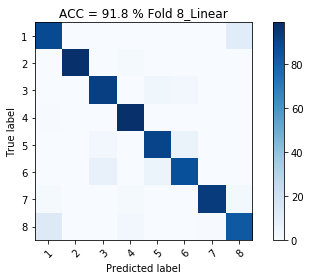



8it [13:59, 116.60s/it]

              precision    recall  f1-score   support

           1       0.85      0.89      0.87       274
           2       0.99      0.98      0.99       275
           3       0.90      0.93      0.92       275
           4       0.94      0.99      0.96       275
           5       0.91      0.91      0.91       275
           6       0.91      0.87      0.89       275
           7       0.99      0.95      0.97       274
           8       0.85      0.83      0.84       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   18.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   18.7s remaining:  2.0min
[Parallel(n_jobs=25)]: Done   3 out of

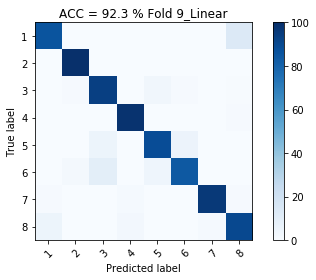



9it [15:19, 105.53s/it]

              precision    recall  f1-score   support

           1       0.93      0.86      0.89       275
           2       0.97      1.00      0.99       275
           3       0.86      0.94      0.90       274
           4       0.96      0.99      0.97       275
           5       0.92      0.89      0.90       275
           6       0.92      0.84      0.88       275
           7       0.98      0.96      0.97       274
           8       0.85      0.91      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   16.5s remaining:  1.8min
[Parallel(n_jobs=25)]: Done   3 out o

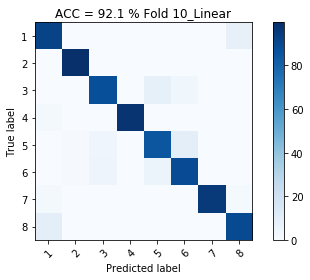



10it [16:21, 98.17s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.87      0.92      0.89       275
           2       0.98      1.00      0.99       275
           3       0.91      0.88      0.89       275
           4       0.99      0.98      0.98       275
           5       0.86      0.85      0.86       275
           6       0.87      0.89      0.88       274
           7       1.00      0.96      0.98       274
           8       0.90      0.89      0.90       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  17/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.2s remaining:   46.9s
[Parallel(n_jobs=25)]:

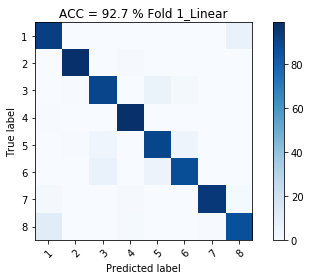



1it [01:20, 80.37s/it]

              precision    recall  f1-score   support

           1       0.87      0.93      0.90       275
           2       0.98      0.99      0.99       274
           3       0.89      0.91      0.90       275
           4       0.96      0.99      0.97       275
           5       0.89      0.90      0.89       275
           6       0.93      0.88      0.90       274
           7       0.99      0.96      0.97       275
           8       0.91      0.87      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   11.7s remaining:  1.3min
[Parallel(n_jobs=25)]: Done   3 out of

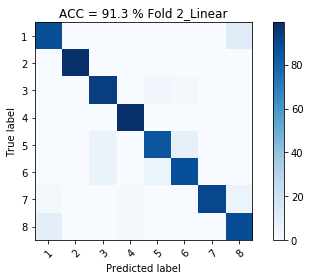



2it [03:12, 90.00s/it]

              precision    recall  f1-score   support

           1       0.88      0.88      0.88       275
           2       0.99      0.99      0.99       275
           3       0.88      0.94      0.91       274
           4       0.95      0.99      0.97       275
           5       0.90      0.85      0.87       275
           6       0.89      0.87      0.88       275
           7       1.00      0.90      0.95       274
           8       0.83      0.88      0.85       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.9s remaining:   38.6s
[Parallel(n_jobs=25)]: Done   3 out of

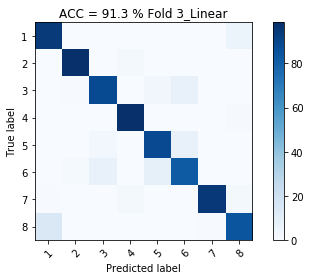



3it [04:02, 77.98s/it]

              precision    recall  f1-score   support

           1       0.86      0.95      0.90       275
           2       0.97      0.98      0.98       274
           3       0.89      0.88      0.89       275
           4       0.96      0.99      0.97       275
           5       0.88      0.89      0.89       274
           6       0.84      0.82      0.83       275
           7       0.99      0.95      0.97       275
           8       0.91      0.84      0.87       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.0s remaining:   39.0s
[Parallel(n_jobs=25)]: Done   3 out of

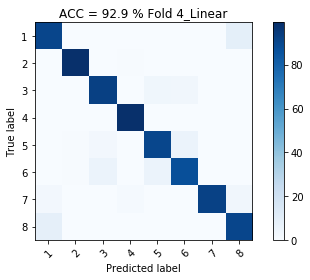



4it [04:59, 71.67s/it]

              precision    recall  f1-score   support

           1       0.89      0.91      0.90       275
           2       0.98      0.99      0.99       274
           3       0.92      0.93      0.92       274
           4       0.98      0.99      0.99       275
           5       0.90      0.91      0.90       275
           6       0.90      0.87      0.89       275
           7       1.00      0.92      0.96       275
           8       0.88      0.91      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   12.7s remaining:  1.4min
[Parallel(n_jobs=25)]: Done   3 out of

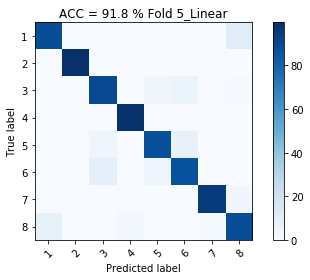



5it [08:21, 110.74s/it]

              precision    recall  f1-score   support

           1       0.90      0.88      0.89       275
           2       0.99      1.00      0.99       275
           3       0.87      0.90      0.88       274
           4       0.97      0.99      0.98       275
           5       0.92      0.88      0.90       274
           6       0.87      0.87      0.87       275
           7       0.98      0.95      0.97       275
           8       0.84      0.88      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.8s remaining:   50.4s
[Parallel(n_jobs=25)]: Done   3 out of

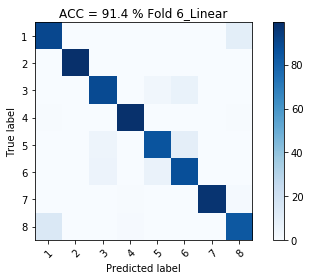



6it [09:42, 101.67s/it]

              precision    recall  f1-score   support

           1       0.85      0.90      0.88       275
           2       0.99      0.99      0.99       275
           3       0.90      0.89      0.89       275
           4       0.97      0.99      0.98       275
           5       0.90      0.85      0.87       274
           6       0.84      0.88      0.86       274
           7       1.00      0.97      0.99       275
           8       0.87      0.84      0.86       275

    accuracy                           0.91      2198
   macro avg       0.92      0.91      0.91      2198
weighted avg       0.92      0.91      0.91      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   16.6s remaining:  1.8min
[Parallel(n_jobs=25)]: Done   3 out of

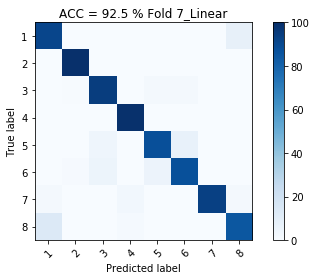



7it [11:31, 103.89s/it]

              precision    recall  f1-score   support

           1       0.85      0.92      0.88       275
           2       0.98      1.00      0.99       275
           3       0.91      0.95      0.93       275
           4       0.96      0.99      0.98       275
           5       0.92      0.88      0.90       274
           6       0.90      0.88      0.89       275
           7       0.99      0.93      0.96       275
           8       0.89      0.85      0.87       274

    accuracy                           0.92      2198
   macro avg       0.93      0.92      0.92      2198
weighted avg       0.93      0.92      0.92      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.7s remaining:   50.3s
[Parallel(n_jobs=25)]: Done   3 out of

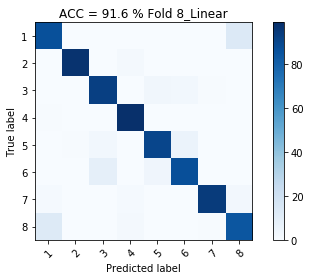



8it [13:34, 109.75s/it]

              precision    recall  f1-score   support

           1       0.85      0.87      0.86       274
           2       0.99      0.97      0.98       275
           3       0.89      0.93      0.91       275
           4       0.94      0.99      0.97       275
           5       0.93      0.91      0.92       275
           6       0.91      0.87      0.89       275
           7       0.98      0.95      0.96       274
           8       0.84      0.84      0.84       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   17.1s remaining:  1.9min
[Parallel(n_jobs=25)]: Done   3 out of

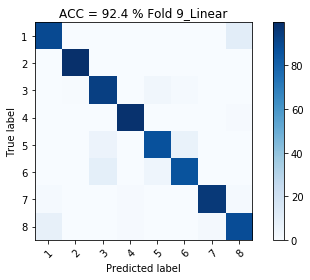



9it [15:32, 112.28s/it]

              precision    recall  f1-score   support

           1       0.90      0.90      0.90       275
           2       0.98      1.00      0.99       275
           3       0.86      0.94      0.90       274
           4       0.97      0.99      0.98       275
           5       0.92      0.87      0.89       275
           6       0.91      0.86      0.89       275
           7       0.98      0.96      0.97       274
           8       0.87      0.89      0.88       275

    accuracy                           0.92      2198
   macro avg       0.93      0.92      0.92      2198
weighted avg       0.93      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.6s remaining:   49.7s
[Parallel(n_jobs=25)]: Done   3 out o

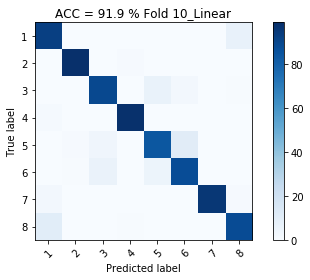



10it [16:49, 100.95s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.86      0.93      0.89       275
           2       0.98      0.99      0.99       275
           3       0.90      0.89      0.90       275
           4       0.97      0.98      0.98       275
           5       0.88      0.84      0.86       275
           6       0.87      0.88      0.87       274
           7       1.00      0.96      0.98       274
           8       0.90      0.88      0.89       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  18/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.7s remaining:   49.9s
[Parallel(n_jobs=25)]:

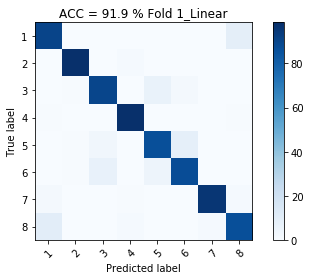



1it [00:59, 59.63s/it]

              precision    recall  f1-score   support

           1       0.87      0.91      0.89       275
           2       0.98      0.98      0.98       274
           3       0.90      0.90      0.90       275
           4       0.96      0.99      0.97       275
           5       0.89      0.87      0.88       275
           6       0.89      0.88      0.88       274
           7       0.99      0.96      0.97       275
           8       0.88      0.87      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.5s remaining:   48.5s
[Parallel(n_jobs=25)]: Done   3 out of

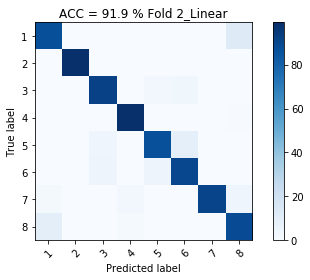



2it [02:43, 72.79s/it]

              precision    recall  f1-score   support

           1       0.88      0.88      0.88       275
           2       0.99      0.99      0.99       275
           3       0.91      0.92      0.92       274
           4       0.95      0.99      0.97       275
           5       0.92      0.87      0.89       275
           6       0.88      0.90      0.89       275
           7       1.00      0.91      0.95       274
           8       0.83      0.89      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.5s remaining:   49.1s
[Parallel(n_jobs=25)]: Done   3 out of

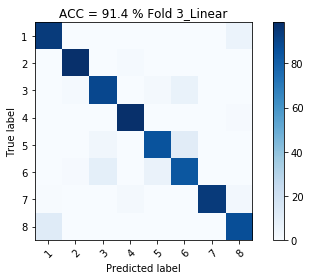



3it [03:30, 65.29s/it]

              precision    recall  f1-score   support

           1       0.88      0.94      0.91       275
           2       0.96      0.98      0.97       274
           3       0.88      0.89      0.88       275
           4       0.96      0.99      0.97       275
           5       0.91      0.85      0.88       274
           6       0.82      0.84      0.83       275
           7       1.00      0.95      0.97       275
           8       0.90      0.87      0.89       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   17.2s remaining:  1.9min
[Parallel(n_jobs=25)]: Done   3 out of

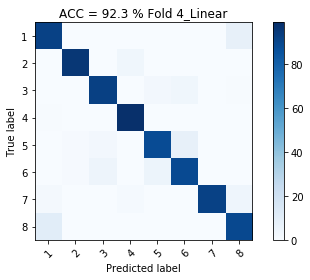



4it [05:01, 72.90s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.90       275
           2       0.98      0.96      0.97       274
           3       0.93      0.93      0.93       274
           4       0.95      0.99      0.97       275
           5       0.92      0.88      0.90       275
           6       0.88      0.89      0.89       275
           7       1.00      0.92      0.96       275
           8       0.87      0.89      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   14.2s remaining:  1.5min
[Parallel(n_jobs=25)]: Done   3 out of

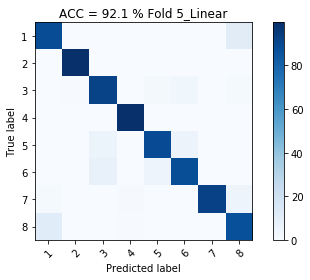



5it [09:21, 129.15s/it]

              precision    recall  f1-score   support

           1       0.87      0.89      0.88       275
           2       0.99      1.00      0.99       275
           3       0.88      0.92      0.90       274
           4       0.98      0.99      0.99       275
           5       0.93      0.89      0.91       274
           6       0.91      0.88      0.89       275
           7       1.00      0.93      0.96       275
           8       0.83      0.87      0.85       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    9.1s remaining:   59.3s
[Parallel(n_jobs=25)]: Done   3 out of

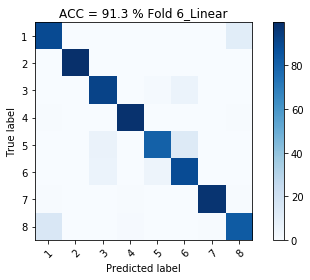



6it [11:01, 120.23s/it]

              precision    recall  f1-score   support

           1       0.85      0.89      0.87       275
           2       1.00      1.00      1.00       275
           3       0.88      0.92      0.90       275
           4       0.97      0.99      0.98       275
           5       0.93      0.81      0.86       274
           6       0.82      0.89      0.86       274
           7       0.99      0.98      0.99       275
           8       0.87      0.83      0.85       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    9.1s remaining:   59.2s
[Parallel(n_jobs=25)]: Done   3 out of

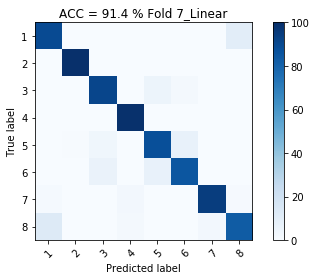



7it [13:06, 121.58s/it]

              precision    recall  f1-score   support

           1       0.86      0.89      0.88       275
           2       0.99      1.00      0.99       275
           3       0.90      0.92      0.91       275
           4       0.95      0.99      0.97       275
           5       0.87      0.88      0.88       274
           6       0.90      0.85      0.88       275
           7       0.97      0.95      0.96       275
           8       0.87      0.83      0.85       274

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.2s remaining:   40.1s
[Parallel(n_jobs=25)]: Done   3 out of

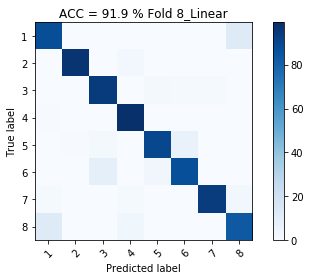



8it [15:15, 124.01s/it]

              precision    recall  f1-score   support

           1       0.86      0.88      0.87       274
           2       0.99      0.97      0.98       275
           3       0.89      0.95      0.92       275
           4       0.93      0.99      0.96       275
           5       0.94      0.90      0.92       275
           6       0.91      0.87      0.89       275
           7       0.98      0.95      0.96       274
           8       0.85      0.84      0.84       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    5.8s remaining:   37.9s
[Parallel(n_jobs=25)]: Done   3 out of

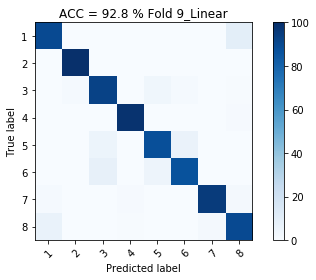



9it [17:59, 135.79s/it]

              precision    recall  f1-score   support

           1       0.91      0.90      0.91       275
           2       0.98      1.00      0.99       275
           3       0.87      0.93      0.90       274
           4       0.98      0.99      0.98       275
           5       0.91      0.88      0.90       275
           6       0.92      0.87      0.89       275
           7       0.98      0.96      0.97       274
           8       0.87      0.90      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   18.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   18.5s remaining:  2.0min
[Parallel(n_jobs=25)]: Done   3 out o

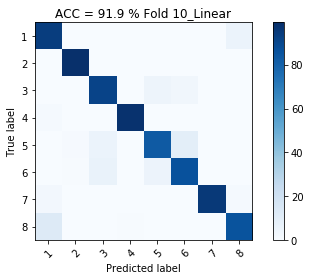



10it [18:56, 113.64s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.85      0.94      0.89       275
           2       0.98      0.99      0.99       275
           3       0.88      0.92      0.90       275
           4       0.98      0.98      0.98       275
           5       0.89      0.83      0.86       275
           6       0.87      0.87      0.87       274
           7       0.99      0.96      0.97       274
           8       0.92      0.86      0.89       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  19/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   24.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   25.4s remaining:  2.8min
[Parallel(n_jobs=25)]:

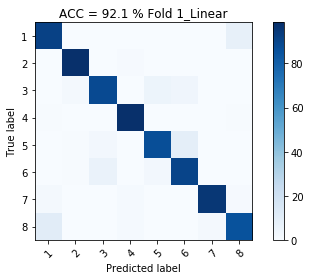



1it [01:27, 87.74s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.90       275
           2       0.97      0.99      0.98       274
           3       0.91      0.89      0.90       275
           4       0.96      0.99      0.97       275
           5       0.92      0.87      0.89       275
           6       0.87      0.91      0.89       274
           7       0.98      0.96      0.97       275
           8       0.90      0.86      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.8s remaining:   57.4s
[Parallel(n_jobs=25)]: Done   3 out of

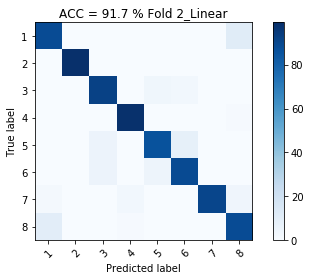



2it [03:13, 93.25s/it]

              precision    recall  f1-score   support

           1       0.87      0.89      0.88       275
           2       0.99      0.99      0.99       275
           3       0.89      0.92      0.91       274
           4       0.95      0.99      0.97       275
           5       0.91      0.86      0.88       275
           6       0.89      0.89      0.89       275
           7       1.00      0.91      0.95       274
           8       0.84      0.89      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   22.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   22.7s remaining:  2.5min
[Parallel(n_jobs=25)]: Done   3 out of

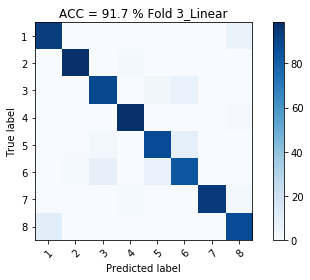



3it [04:41, 91.48s/it]

              precision    recall  f1-score   support

           1       0.89      0.93      0.91       275
           2       0.97      0.98      0.97       274
           3       0.89      0.89      0.89       275
           4       0.96      0.99      0.97       275
           5       0.90      0.88      0.89       274
           6       0.84      0.84      0.84       275
           7       0.99      0.95      0.97       275
           8       0.90      0.88      0.89       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   21.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   21.7s remaining:  2.4min
[Parallel(n_jobs=25)]: Done   3 out of

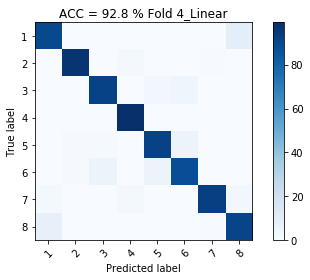



4it [06:17, 92.78s/it]

              precision    recall  f1-score   support

           1       0.89      0.90      0.90       275
           2       0.97      0.97      0.97       274
           3       0.93      0.92      0.92       274
           4       0.95      0.99      0.97       275
           5       0.92      0.92      0.92       275
           6       0.90      0.88      0.89       275
           7       0.98      0.93      0.96       275
           8       0.87      0.91      0.89       275

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    6.0s remaining:   39.0s
[Parallel(n_jobs=25)]: Done   3 out of

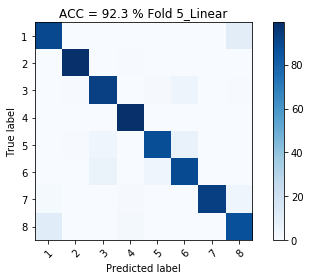



5it [10:00, 131.90s/it]

              precision    recall  f1-score   support

           1       0.87      0.90      0.89       275
           2       0.99      0.99      0.99       275
           3       0.89      0.93      0.91       274
           4       0.96      0.99      0.98       275
           5       0.94      0.88      0.91       274
           6       0.88      0.89      0.89       275
           7       1.00      0.93      0.97       275
           8       0.85      0.87      0.86       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   19.1s remaining:  2.1min
[Parallel(n_jobs=25)]: Done   3 out of

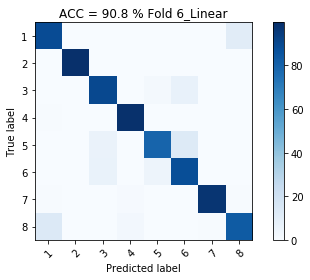



6it [12:12, 131.98s/it]

              precision    recall  f1-score   support

           1       0.86      0.89      0.87       275
           2       1.00      1.00      1.00       275
           3       0.87      0.90      0.89       275
           4       0.95      0.99      0.97       275
           5       0.92      0.80      0.85       274
           6       0.81      0.88      0.85       274
           7       0.99      0.97      0.98       275
           8       0.87      0.83      0.85       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.1s remaining:   46.4s
[Parallel(n_jobs=25)]: Done   3 out of

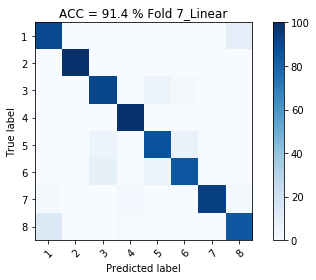



7it [14:30, 133.76s/it]

              precision    recall  f1-score   support

           1       0.85      0.91      0.88       275
           2       0.99      1.00      1.00       275
           3       0.86      0.92      0.89       275
           4       0.96      0.99      0.98       275
           5       0.87      0.86      0.87       274
           6       0.91      0.85      0.88       275
           7       1.00      0.93      0.96       275
           8       0.88      0.85      0.86       274

    accuracy                           0.91      2198
   macro avg       0.92      0.91      0.91      2198
weighted avg       0.92      0.91      0.91      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   22.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   22.5s remaining:  2.4min
[Parallel(n_jobs=25)]: Done   3 out of

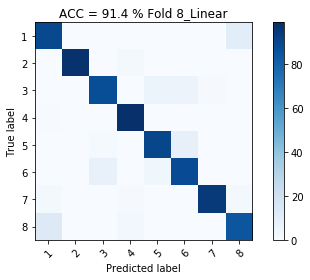



8it [16:35, 131.31s/it]

              precision    recall  f1-score   support

           1       0.85      0.89      0.87       274
           2       0.99      0.98      0.99       275
           3       0.91      0.88      0.89       275
           4       0.94      0.99      0.96       275
           5       0.91      0.90      0.91       275
           6       0.87      0.88      0.88       275
           7       0.98      0.95      0.97       274
           8       0.86      0.84      0.85       275

    accuracy                           0.91      2198
   macro avg       0.92      0.91      0.91      2198
weighted avg       0.92      0.91      0.91      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   12.9s remaining:  1.4min
[Parallel(n_jobs=25)]: Done   3 out of

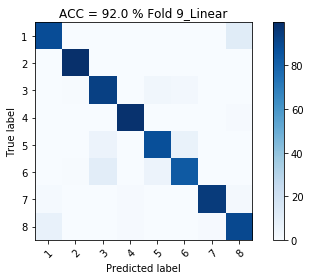



9it [18:28, 125.74s/it]

              precision    recall  f1-score   support

           1       0.90      0.88      0.89       275
           2       0.99      1.00      0.99       275
           3       0.85      0.93      0.89       274
           4       0.98      0.99      0.98       275
           5       0.91      0.88      0.89       275
           6       0.90      0.84      0.87       275
           7       0.99      0.95      0.97       274
           8       0.86      0.90      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   17.3s remaining:  1.9min
[Parallel(n_jobs=25)]: Done   3 out o

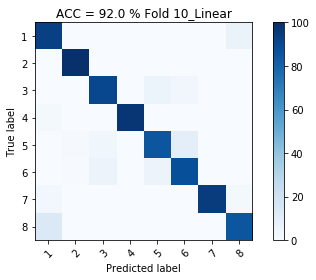



10it [19:38, 117.88s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.83      0.93      0.88       275
           2       0.98      1.00      0.99       275
           3       0.91      0.91      0.91       275
           4       0.99      0.97      0.98       275
           5       0.89      0.85      0.87       275
           6       0.87      0.88      0.87       274
           7       1.00      0.95      0.97       274
           8       0.91      0.85      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  20/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   15.2s remaining:  1.6min
[Parallel(n_jobs=25)]:

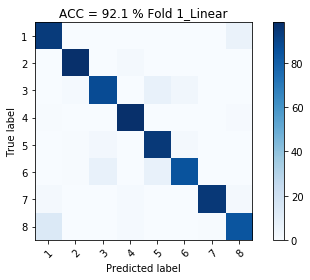



1it [01:16, 76.47s/it]

              precision    recall  f1-score   support

           1       0.85      0.94      0.89       275
           2       0.97      0.98      0.98       274
           3       0.90      0.88      0.89       275
           4       0.95      0.98      0.97       275
           5       0.87      0.95      0.90       275
           6       0.94      0.85      0.89       274
           7       0.99      0.95      0.97       275
           8       0.90      0.84      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   20.3s remaining:  2.2min
[Parallel(n_jobs=25)]: Done   3 out of

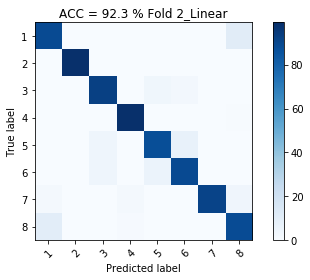



2it [02:41, 78.98s/it]

              precision    recall  f1-score   support

           1       0.88      0.89      0.88       275
           2       0.99      0.99      0.99       275
           3       0.91      0.93      0.92       274
           4       0.96      0.99      0.97       275
           5       0.90      0.88      0.89       275
           6       0.90      0.89      0.90       275
           7       1.00      0.92      0.95       274
           8       0.85      0.89      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   17.9s remaining:  1.9min
[Parallel(n_jobs=25)]: Done   3 out of

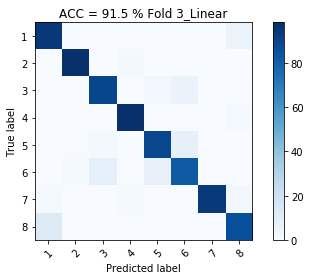



3it [03:41, 73.32s/it]

              precision    recall  f1-score   support

           1       0.87      0.95      0.91       275
           2       0.97      0.98      0.97       274
           3       0.89      0.89      0.89       275
           4       0.96      0.98      0.97       275
           5       0.89      0.89      0.89       274
           6       0.85      0.82      0.84       275
           7       1.00      0.94      0.97       275
           8       0.90      0.87      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   20.5s remaining:  2.2min
[Parallel(n_jobs=25)]: Done   3 out of

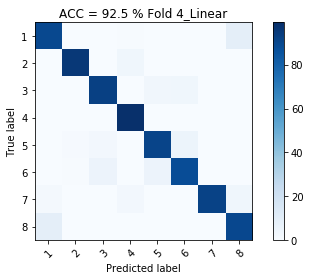



4it [06:14, 97.12s/it]

              precision    recall  f1-score   support

           1       0.89      0.90      0.89       275
           2       0.98      0.96      0.97       274
           3       0.92      0.93      0.93       274
           4       0.93      0.99      0.96       275
           5       0.91      0.91      0.91       275
           6       0.91      0.88      0.90       275
           7       0.99      0.92      0.95       275
           8       0.87      0.90      0.89       275

    accuracy                           0.92      2198
   macro avg       0.93      0.92      0.93      2198
weighted avg       0.93      0.92      0.93      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   10.9s remaining:  1.2min
[Parallel(n_jobs=25)]: Done   3 out of

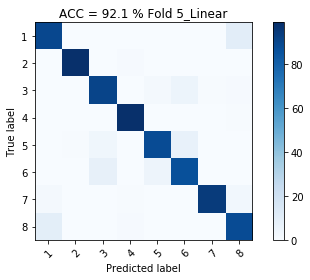



5it [10:08, 138.37s/it]

              precision    recall  f1-score   support

           1       0.88      0.90      0.89       275
           2       0.99      0.99      0.99       275
           3       0.88      0.91      0.90       274
           4       0.97      0.99      0.98       275
           5       0.93      0.88      0.91       274
           6       0.88      0.87      0.87       275
           7       0.99      0.95      0.97       275
           8       0.85      0.88      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   10.2s remaining:  1.1min
[Parallel(n_jobs=25)]: Done   3 out of

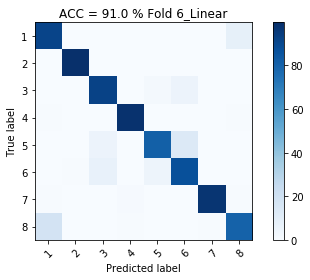



6it [12:04, 131.60s/it]

              precision    recall  f1-score   support

           1       0.82      0.92      0.87       275
           2       0.99      1.00      0.99       275
           3       0.88      0.92      0.90       275
           4       0.98      0.99      0.98       275
           5       0.92      0.81      0.86       274
           6       0.82      0.87      0.85       274
           7       0.99      0.97      0.98       275
           8       0.89      0.80      0.85       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   16.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   18.0s remaining:  2.0min
[Parallel(n_jobs=25)]: Done   3 out of

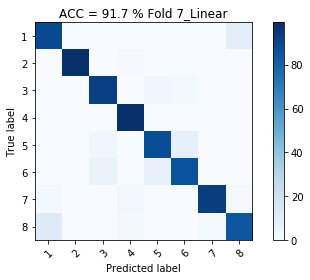



7it [14:08, 129.41s/it]

              precision    recall  f1-score   support

           1       0.86      0.89      0.88       275
           2       0.99      0.99      0.99       275
           3       0.90      0.93      0.92       275
           4       0.94      0.99      0.97       275
           5       0.89      0.88      0.89       274
           6       0.89      0.86      0.88       275
           7       0.97      0.94      0.96       275
           8       0.88      0.84      0.86       274

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   17.0s remaining:  1.8min
[Parallel(n_jobs=25)]: Done   3 out of

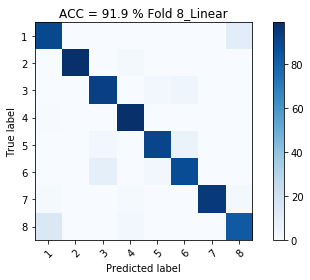



8it [16:27, 132.11s/it]

              precision    recall  f1-score   support

           1       0.84      0.89      0.87       274
           2       0.99      0.98      0.99       275
           3       0.89      0.92      0.91       275
           4       0.94      0.99      0.96       275
           5       0.94      0.91      0.92       275
           6       0.89      0.88      0.89       275
           7       1.00      0.95      0.97       274
           8       0.86      0.83      0.85       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.5s remaining:   48.7s
[Parallel(n_jobs=25)]: Done   3 out of

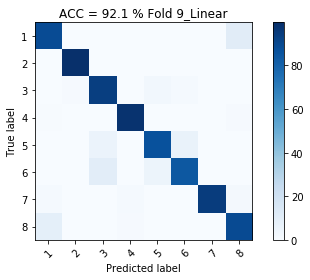



9it [19:18, 143.85s/it]

              precision    recall  f1-score   support

           1       0.89      0.89      0.89       275
           2       0.99      1.00      0.99       275
           3       0.85      0.94      0.89       274
           4       0.97      0.98      0.98       275
           5       0.92      0.87      0.89       275
           6       0.91      0.84      0.88       275
           7       1.00      0.95      0.97       274
           8       0.86      0.89      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   21.3s remaining:  2.3min
[Parallel(n_jobs=25)]: Done   3 out o

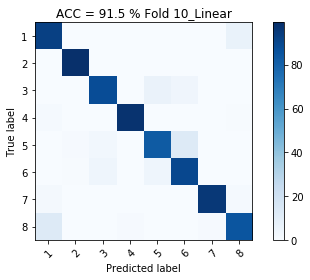



10it [21:02, 126.25s/it]


0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.85      0.93      0.89       275
           2       0.98      0.99      0.99       275
           3       0.92      0.88      0.90       275
           4       0.97      0.98      0.98       275
           5       0.88      0.83      0.86       275
           6       0.84      0.90      0.87       274
           7       0.98      0.96      0.97       274
           8       0.90      0.85      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Region =  21/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    7.8s remaining:   50.5s
[Parallel(n_jobs=25)]:

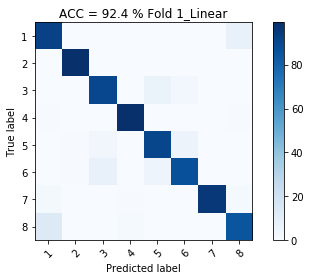



1it [01:30, 90.86s/it]

              precision    recall  f1-score   support

           1       0.86      0.92      0.89       275
           2       0.98      0.99      0.99       274
           3       0.89      0.90      0.90       275
           4       0.97      0.99      0.98       275
           5       0.89      0.91      0.90       275
           6       0.91      0.87      0.89       274
           7       1.00      0.96      0.98       275
           8       0.90      0.85      0.87       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  2/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   19.9s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   19.9s remaining:  2.2min
[Parallel(n_jobs=25)]: Done   3 out of

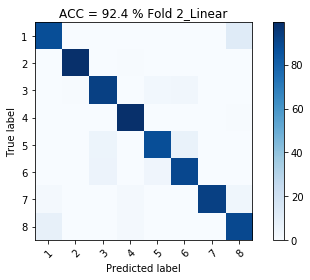



2it [04:40, 120.54s/it]

              precision    recall  f1-score   support

           1       0.90      0.88      0.89       275
           2       0.99      0.99      0.99       275
           3       0.90      0.93      0.91       274
           4       0.95      0.99      0.97       275
           5       0.93      0.88      0.90       275
           6       0.90      0.90      0.90       275
           7       1.00      0.93      0.96       274
           8       0.85      0.90      0.87       275

    accuracy                           0.92      2198
   macro avg       0.93      0.92      0.92      2198
weighted avg       0.93      0.92      0.92      2198

Iteration =  3/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.7s remaining:   56.5s
[Parallel(n_jobs=25)]: Done   3 out of

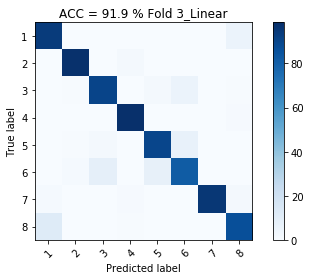



3it [05:37, 101.38s/it]

              precision    recall  f1-score   support

           1       0.87      0.94      0.91       275
           2       0.97      0.98      0.97       274
           3       0.90      0.91      0.90       275
           4       0.96      0.99      0.97       275
           5       0.90      0.90      0.90       274
           6       0.86      0.82      0.84       275
           7       1.00      0.96      0.98       275
           8       0.90      0.87      0.89       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  4/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    8.2s remaining:   53.6s
[Parallel(n_jobs=25)]: Done   3 out of

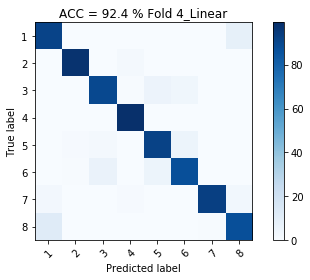



4it [06:48, 92.36s/it] 

              precision    recall  f1-score   support

           1       0.86      0.92      0.89       275
           2       0.98      0.98      0.98       274
           3       0.91      0.90      0.91       274
           4       0.96      0.99      0.98       275
           5       0.90      0.92      0.91       275
           6       0.91      0.88      0.89       275
           7       0.98      0.93      0.96       275
           8       0.88      0.87      0.88       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  5/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:   21.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   21.4s remaining:  2.3min
[Parallel(n_jobs=25)]: Done   3 out of

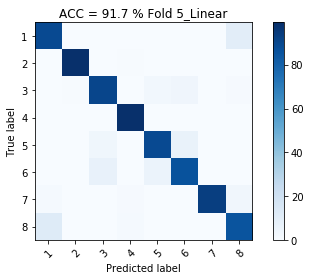



5it [11:23, 147.26s/it]

              precision    recall  f1-score   support

           1       0.86      0.89      0.88       275
           2       0.99      0.99      0.99       275
           3       0.89      0.91      0.90       274
           4       0.97      0.99      0.98       275
           5       0.91      0.89      0.90       274
           6       0.89      0.86      0.87       275
           7       0.99      0.94      0.96       275
           8       0.85      0.85      0.85       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198

Iteration =  6/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   13.6s remaining:  1.5min
[Parallel(n_jobs=25)]: Done   3 out of

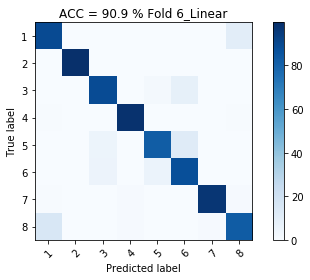



6it [13:49, 146.87s/it]

              precision    recall  f1-score   support

           1       0.84      0.89      0.87       275
           2       0.99      1.00      0.99       275
           3       0.89      0.89      0.89       275
           4       0.97      0.99      0.98       275
           5       0.91      0.82      0.87       274
           6       0.81      0.88      0.84       274
           7       0.99      0.97      0.98       275
           8       0.87      0.83      0.85       275

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  7/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    9.6s remaining:  1.0min
[Parallel(n_jobs=25)]: Done   3 out of

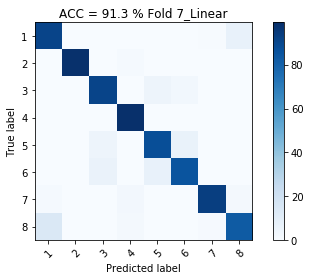



7it [16:21, 148.18s/it]

              precision    recall  f1-score   support

           1       0.85      0.91      0.88       275
           2       0.99      0.99      0.99       275
           3       0.89      0.91      0.90       275
           4       0.94      0.99      0.97       275
           5       0.88      0.88      0.88       274
           6       0.90      0.85      0.88       275
           7       0.98      0.94      0.96       275
           8       0.89      0.83      0.86       274

    accuracy                           0.91      2198
   macro avg       0.91      0.91      0.91      2198
weighted avg       0.91      0.91      0.91      2198

Iteration =  8/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    9.6s remaining:  1.0min
[Parallel(n_jobs=25)]: Done   3 out of

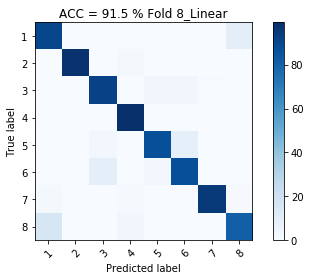



8it [18:46, 147.45s/it]

              precision    recall  f1-score   support

           1       0.83      0.91      0.87       274
           2       0.99      0.98      0.98       275
           3       0.88      0.92      0.90       275
           4       0.94      0.99      0.96       275
           5       0.94      0.88      0.91       275
           6       0.88      0.88      0.88       275
           7       0.99      0.96      0.97       274
           8       0.88      0.81      0.85       275

    accuracy                           0.91      2198
   macro avg       0.92      0.91      0.91      2198
weighted avg       0.92      0.91      0.91      2198

Iteration =  9/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:   18.9s remaining:  2.0min
[Parallel(n_jobs=25)]: Done   3 out of

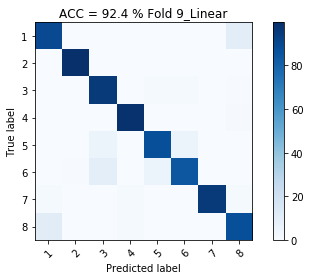



9it [21:23, 150.06s/it]

              precision    recall  f1-score   support

           1       0.88      0.90      0.89       275
           2       0.99      1.00      0.99       275
           3       0.86      0.96      0.91       274
           4       0.97      0.99      0.98       275
           5       0.93      0.88      0.90       275
           6       0.92      0.85      0.88       275
           7       1.00      0.96      0.98       274
           8       0.87      0.88      0.87       275

    accuracy                           0.92      2198
   macro avg       0.93      0.92      0.92      2198
weighted avg       0.93      0.92      0.92      2198

Iteration =  10/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=25)]: Done   2 out of  15 | elapsed:    9.0s remaining:   58.2s
[Parallel(n_jobs=25)]: Done   3 out o

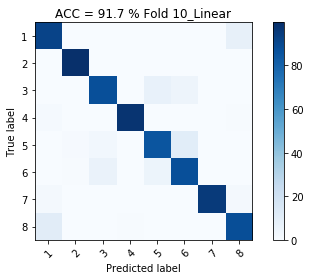



10it [23:11, 139.12s/it]

              precision    recall  f1-score   support

           1       0.86      0.92      0.89       275
           2       0.98      1.00      0.99       275
           3       0.90      0.88      0.89       275
           4       0.98      0.98      0.98       275
           5       0.87      0.85      0.86       275
           6       0.85      0.88      0.86       274
           7       1.00      0.96      0.98       274
           8       0.89      0.88      0.89       275

    accuracy                           0.92      2198
   macro avg       0.92      0.92      0.92      2198
weighted avg       0.92      0.92      0.92      2198



In [ ]:
# Traininig/Testing loop

for feature in range(0,len(ftr_vec)): # For loop over regions
  print("Region = ", str(feature+1) +'/'+ str(21))
  fold = 0
  # Initializa variables
  train_idx    = []
  test_idx     = []
  cm_L         = np.zeros((n_partitions,n_classes,n_classes))
  cr_L         = []
  best_mod_L   = []
  best_pms_L   = []
  for train_index, test_index in tqdm(sss.split(X,y)):
      # Training/testing index storage
      train_idx += [train_index]
      test_idx  += [test_index]
      
      # Number of partitions flag
      fold = fold + 1
      print("Iteration = ", str(fold) +'/'+ str(n_partitions))
      
      # Iteration file name 
      filename = img_path + "/Fold" + str(fold) + "Region" + str(feature+1)

      # Train/Test partition and matrix storing to apply CKA over them for 
      # visualization
      X_train, X_test = X[train_index,0:ftr_vec[feature]], X[test_index,0:ftr_vec[feature]]
      y_train, y_test = y[train_index], y[test_index]

      # ---------------------------------------------------------------------------------------------------------------------------
      # Training
      
      # Linear
      print('Linear Model')
      # Using GridSearchCV 
      hs_Lineal = GridSearchCV(Pipeline(steps[0]), parameters[0], n_jobs = 25, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
      # Using RandomizedSearchCV
      # hs_Lineal = RandomizedSearchCV(Pipeline(steps[0]), param_distributions=parameters[0],n_iter=10, cv=5, iid=False, n_jobs=2)
      hs_Lineal.fit(X_train,y_train)
      # Projection matrix from CKA
      # W_cka_L += [hs_Lineal.best_estimator_.named_steps['Projection'].Wcka]


      # ---------------------------------------------------------------------------------------------------------------------------
      # Validation
      
      # Linear
      y_pred_L           = hs_Lineal.best_estimator_.predict(X_test)
      accuracy_L[fold-1,feature] = accuracy_score(y_test,y_pred_L)
      cm_temp            = confusion_matrix(y_test,y_pred_L)
      cm_L[fold-1,:,:]   = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
      plot_confusion_matrix(y_test, y_pred_L, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_L[fold-1,feature],fold) + '_'+ label_models[0])
      plt.autoscale()
      save_fig(img_path,label_models[0]+'_Fold'+str(fold)+ "Region" + str(feature+1))                      
      plt.show()
      cr_L += [classification_report(y_test,y_pred_L)]
      print(cr_L[-1])
      # Best model storage
      # best_mod_L += [hs_Lineal.best_estimator_, accuracy_L,cm_L,cr_L, sel_fts_L]
      # best_mod_L += [hs_Lineal.best_estimator_]
      # best_pms_L += [hs_Lineal.best_params_,accuracy_L,cm_L,cr_L,W_cka_L]
      best_pms_L += [hs_Lineal.best_params_]
      # joblib.dump(best_pms_L, filename + "LinealCKA" + ".pkl")

  # Results dictionary creation
  L_dict = {'accuracy_L': accuracy_L,
            'cm_L': cm_L,
            'cr_L': cr_L,
            'best_pms_L':best_pms_L}

  Results = [L_dict]

  joblib.dump(Results, rslt_dir + "Region" + str(feature+1) +".pkl")

([<matplotlib.axis.XTick at 0x7fb17d265a10>,
 <a list of 21 Text xticklabel objects>)

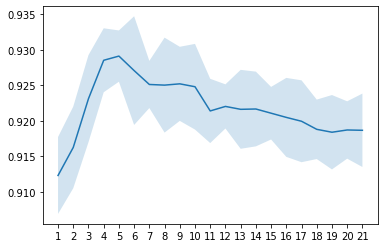

In [ ]:
# Get mean and standard deviation vectors 
mean_vec_l    = np.mean(Results[0]['accuracy_L'], axis = 0)
std_vec_l     = np.std(Results[0]['accuracy_L'], axis = 0)
# mean_vec_lr   = np.mean(Results[1]['accuracy_LogR'], axis = 0)
# std_vec_lr    = np.std(Results[1]['accuracy_LogR'], axis = 0)
# mean_vec_lsvm = np.mean(Results[2]['accuracy_lSVM'], axis = 0)
# std_vec_lsvm  = np.std(Results[2]['accuracy_lSVM'], axis = 0)
reg_vec  = np.arange(1,22,1)

# Plotting
plt.figure()
plt.plot(reg_vec,mean_vec_l)
plt.fill_between(reg_vec, mean_vec_l-std_vec_l, mean_vec_l+std_vec_l, alpha=0.2)
# plt.ylim(0.7,0.9)
# # plt.plot(reg_vec,mean_vec_lr)
# # plt.fill_between(reg_vec, mean_vec_lr-std_vec_lr, mean_vec_lr+std_vec_lr, alpha=0.2)
# # plt.plot(reg_vec,mean_vec_lsvm)
# # plt.fill_between(reg_vec, mean_vec_lsvm-std_vec_lsvm, mean_vec_lsvm+std_vec_lsvm, alpha=0.2)
plt.xticks(reg_vec, reg_vec)

In [ ]:
# Storing the data
Data = np.c_[reg_vec.reshape(1,-1).T,mean_vec_l.T,std_vec_l.T]
np.savetxt(img_path + '/ETH80DBRSL.dat', Data, delimiter='   ')

In [ ]:
# Computing optimal number of regiones acording to target
Results      = np.loadtxt(img_path + 'ETH80DBRSL.dat')
# Normalizing the number of regions
Results[:,0] = Results[:,0] - min(Results[:,0])
Results[:,0] = Results[:,0]/max(Results[:,0])
# Normalizing the accuracy
Results[:,1] = Results[:,1] - min(Results[:,1])
Results[:,1] = Results[:,1]/max(Results[:,1])
# Normalizing the standard deviation
Results[:,2] = Results[:,2] - min(Results[:,2])
Results[:,2] = Results[:,2]/max(Results[:,2])
# Ideal result
Target       = np.array((0,1,0))
# Computing the minimum distance between the ideal result and our results
dist         = cdist(Target.reshape(1,-1),Results, 'euclidean')
# Showing the optimum number of regions
print('The ideal number of regions is: ' + str((np.argmin(dist)+1)))

The ideal number of regions is: 5


# **Step 6: Projecting the selected regions using CKA**

In [ ]:
# Selecting the regions to project
X       = X[:,0:7500]

In [ ]:
# Variable declaration
n_partitions = 80
test_per     = 0.67
n_classes    = len(np.unique(y))
fold         = 0
train_idx    = []
test_idx     = []
alpha_L      = []
alpha_LogR   = []
alpha_lSVM   = []
sel_fts_L    = []
sel_fts_LogR = []
sel_fts_lSVM = []
thld_L       = []
thld_LogR    = []
thld_lSVM    = []
sel_fts_Lt   = []
sel_fts_LogRt= []
sel_fts_lSVMt= []
nfeats_L     = []
nfeats_LogR  = []
nfeats_lSVM  = []
accuracy_L   = np.zeros((n_partitions))
accuracy_LogR= np.zeros((n_partitions))
accuracy_lSVM= np.zeros((n_partitions))
cm_L         = np.zeros((n_partitions,n_classes,n_classes))
cm_LogR      = np.zeros((n_partitions,n_classes,n_classes))
cm_lSVM      = np.zeros((n_partitions,n_classes,n_classes))
cr_L         = []
cr_LogR      = []
cr_lSVM      = []
best_mod_L   = []
best_mod_LogR= []
best_mod_lSVM= []
best_pms_L   = []
best_pms_LogR= []
best_pms_lSVM= [] 

In [ ]:
# Matrix declaration to store train/test matrices and their labels, and projection matrices from CKA
X_train_cka = []
X_test_cka  = []
y_train_cka = []
y_test_cka  = []
W_cka_L     = []
W_cka_LogR  = []
W_cka_lSVM  = []
    
# Step declaration
steps = [
        [('Preprocessing', StandardScaler()),
          ('Projection', MiniBatchCKA(Q = 0.95, batch=41)),
          ('Preprocessing2',StandardScaler()),
          ('Classification',SGDClassifier())],      # Clasificador Lineal
        [('Preprocessing', StandardScaler()),
          ('Projection', MiniBatchCKA(Q = 0.95, batch=41)),
          ('Preprocessing2',StandardScaler()),
          ('Classification',LogisticRegression())], # Regresion Logistica
        [('Preprocessing', StandardScaler()),
          ('Projection', MiniBatchCKA(Q = 0.95, batch=41)),
          ('Preprocessing2',StandardScaler()),
          ('Classification',LinearSVC())],          # Maquina de Vectores de Soporte
        ]
    
# Grid declaration
parameters = [
            {'Classification__penalty': ['l1', 'l2', 'elasticnet'] },
            {'Classification__C': [0.01,0.1,1,10]},
            {'Classification__C': [0.1,1,10,100,1000]}
            ]

# Model labels
label_models = ['LinearCKA','LogisticRegressionCKA','LinearSVCKA']

In [ ]:
# Directory to save results and plots
rslt_dir     = img_dir + '/RegionSelection/ReliefF_CKA_RS_BoCF/Results_ReliefF_CKA_RS_BoCF_Py'
sys.path.append(rslt_dir)
img_path     = img_dir + '/RegionSelection/ReliefF_CKA_RS_BoCF/'
sys.path.append(img_path)

Loop to optimize CKA projection

Iteration =  1/80
Linear Model
it:1/50---cost:-1.70e+00--- elapsed:112.82 [s]



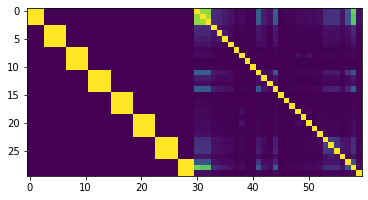

Logistic Regression Model
it:1/50---cost:-1.66e+00--- elapsed:108.28 [s]



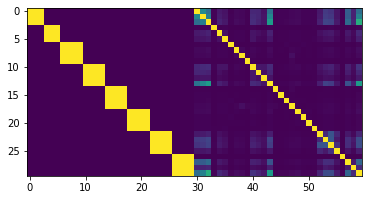

Linear SVM Model
it:1/50---cost:-1.71e+00--- elapsed:103.69 [s]



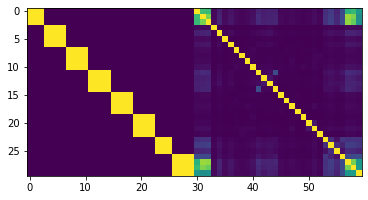

              precision    recall  f1-score   support

           1       1.00      0.93      0.96        41
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

              precision    recall  f1-score   support

           1       1.00      0.93      0.96        41
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

              precision    recall  f1-score   support

           1       1.00      0.93      0.96        41
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

Iteration =  2/80
L

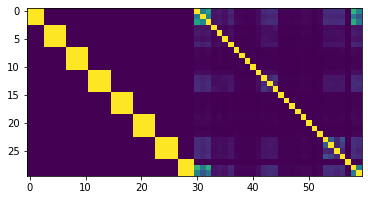

Logistic Regression Model
it:1/50---cost:-1.74e+00--- elapsed:94.47 [s]



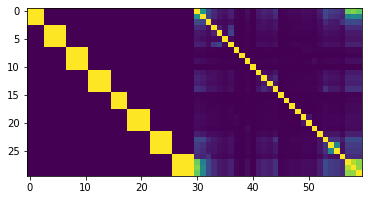

Linear SVM Model
it:1/50---cost:-1.66e+00--- elapsed:95.82 [s]



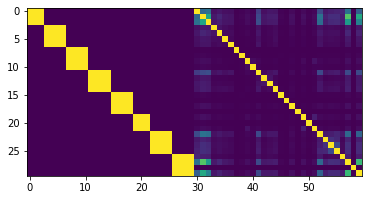

              precision    recall  f1-score   support

           1       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       1.00      0.93      0.96        41
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

Iteration =  3/80
Linear Model
it:1/50---cost:-1.75e+00--- elapsed:101.11

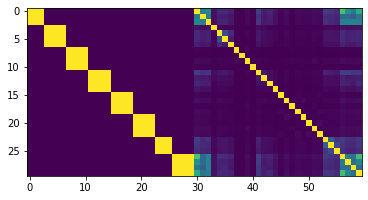

Logistic Regression Model
it:1/50---cost:-1.65e+00--- elapsed:98.53 [s]



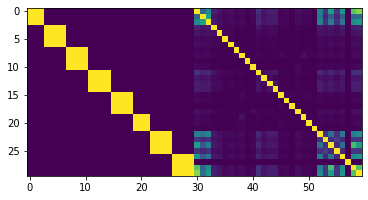

Linear SVM Model
it:1/50---cost:-1.70e+00--- elapsed:102.72 [s]



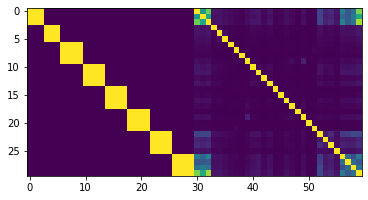

              precision    recall  f1-score   support

           1       1.00      0.93      0.96        41
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

              precision    recall  f1-score   support

           1       1.00      0.95      0.97        41
           8       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           1       1.00      0.88      0.94        41
           8       0.00      0.00      0.00         0

    accuracy                           0.88        41
   macro avg       0.50      0.44      0.47        41
weighted avg       1.00      0.88      0.94        41

Iteration =  4/80
L

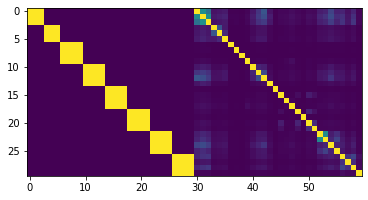

Logistic Regression Model
it:1/50---cost:-1.77e+00--- elapsed:108.59 [s]



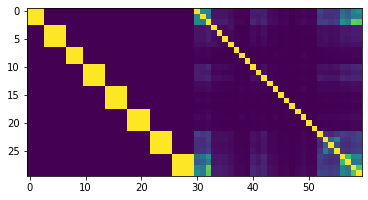

Linear SVM Model
it:1/50---cost:-1.69e+00--- elapsed:110.79 [s]



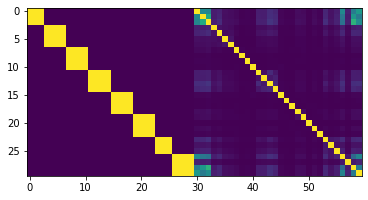

              precision    recall  f1-score   support

           1       1.00      0.93      0.96        41
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

              precision    recall  f1-score   support

           1       1.00      0.95      0.97        41
           8       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           1       1.00      0.90      0.95        41
           8       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0.50      0.45      0.47        41
weighted avg       1.00      0.90      0.95        41

Iteration =  5/80
L

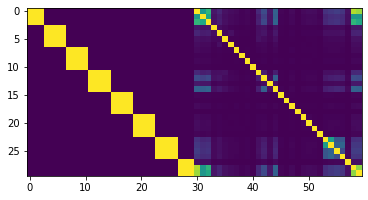

Logistic Regression Model
it:1/50---cost:-1.73e+00--- elapsed:102.65 [s]



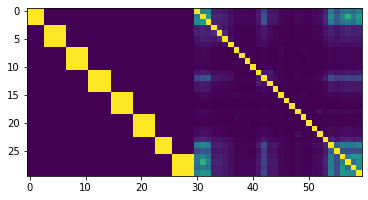

Linear SVM Model
it:1/50---cost:-1.76e+00--- elapsed:96.31 [s]



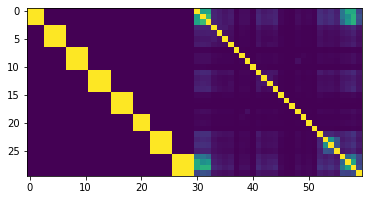

              precision    recall  f1-score   support

           1       1.00      0.41      0.59        41
           8       0.00      0.00      0.00         0

    accuracy                           0.41        41
   macro avg       0.50      0.21      0.29        41
weighted avg       1.00      0.41      0.59        41

              precision    recall  f1-score   support

           1       1.00      0.49      0.66        41
           8       0.00      0.00      0.00         0

    accuracy                           0.49        41
   macro avg       0.50      0.24      0.33        41
weighted avg       1.00      0.49      0.66        41

              precision    recall  f1-score   support

           1       1.00      0.54      0.70        41
           8       0.00      0.00      0.00         0

    accuracy                           0.54        41
   macro avg       0.50      0.27      0.35        41
weighted avg       1.00      0.54      0.70        41

Iteration =  6/80
L

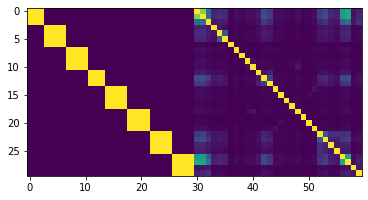

Logistic Regression Model
it:1/50---cost:-1.66e+00--- elapsed:96.97 [s]



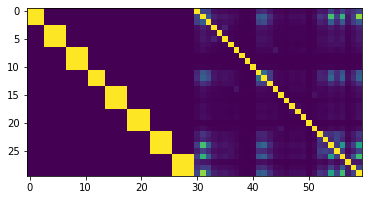

Linear SVM Model
it:1/50---cost:-1.70e+00--- elapsed:102.76 [s]



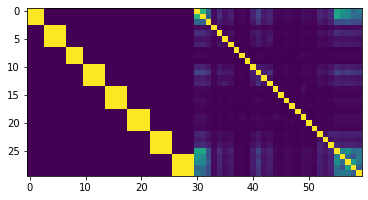

              precision    recall  f1-score   support

           1       1.00      0.85      0.92        41
           8       0.00      0.00      0.00         0

    accuracy                           0.85        41
   macro avg       0.50      0.43      0.46        41
weighted avg       1.00      0.85      0.92        41

              precision    recall  f1-score   support

           1       1.00      0.88      0.94        41
           8       0.00      0.00      0.00         0

    accuracy                           0.88        41
   macro avg       0.50      0.44      0.47        41
weighted avg       1.00      0.88      0.94        41

              precision    recall  f1-score   support

           1       1.00      0.85      0.92        41
           8       0.00      0.00      0.00         0

    accuracy                           0.85        41
   macro avg       0.50      0.43      0.46        41
weighted avg       1.00      0.85      0.92        41

Iteration =  7/80
L

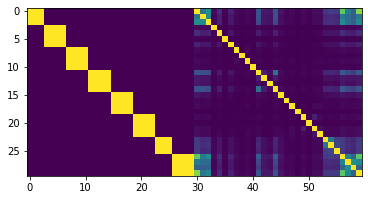

Logistic Regression Model
it:1/50---cost:-1.79e+00--- elapsed:92.08 [s]



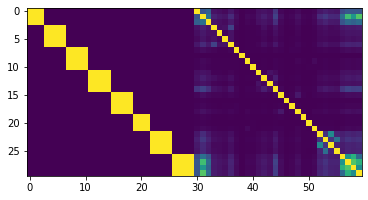

Linear SVM Model
it:1/50---cost:-1.79e+00--- elapsed:98.90 [s]



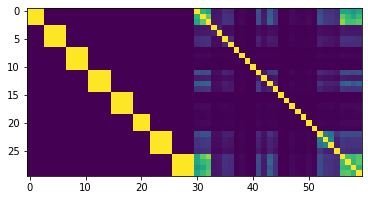

              precision    recall  f1-score   support

           1       1.00      0.95      0.97        41
           8       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           1       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           1       1.00      0.90      0.95        41
           8       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0.50      0.45      0.47        41
weighted avg       1.00      0.90      0.95        41

Iteration =  8/80
L

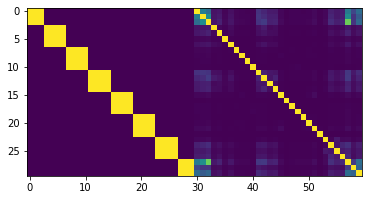

Logistic Regression Model
it:1/50---cost:-1.74e+00--- elapsed:102.14 [s]



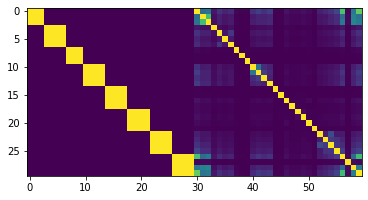

Linear SVM Model
it:1/50---cost:-1.74e+00--- elapsed:97.63 [s]



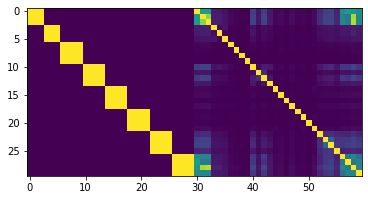

              precision    recall  f1-score   support

           1       1.00      0.90      0.95        41
           8       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0.50      0.45      0.47        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           1       1.00      0.93      0.96        41
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

              precision    recall  f1-score   support

           1       1.00      0.95      0.97        41
           8       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

Iteration =  9/80
L

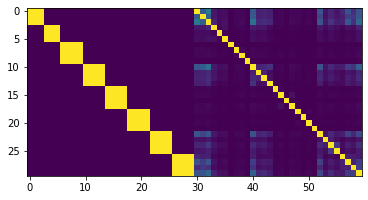

Logistic Regression Model
it:1/50---cost:-1.76e+00--- elapsed:104.89 [s]



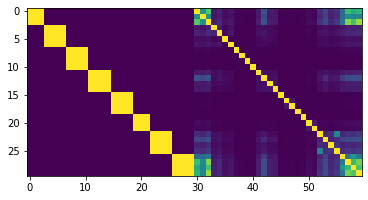

Linear SVM Model
it:1/50---cost:-1.67e+00--- elapsed:91.47 [s]



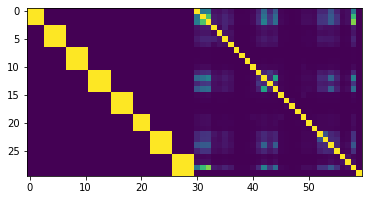

              precision    recall  f1-score   support

           1       1.00      0.83      0.91        41
           8       0.00      0.00      0.00         0

    accuracy                           0.83        41
   macro avg       0.50      0.41      0.45        41
weighted avg       1.00      0.83      0.91        41

              precision    recall  f1-score   support

           1       1.00      0.80      0.89        41
           8       0.00      0.00      0.00         0

    accuracy                           0.80        41
   macro avg       0.50      0.40      0.45        41
weighted avg       1.00      0.80      0.89        41

              precision    recall  f1-score   support

           1       1.00      0.83      0.91        41
           8       0.00      0.00      0.00         0

    accuracy                           0.83        41
   macro avg       0.50      0.41      0.45        41
weighted avg       1.00      0.83      0.91        41

Iteration =  10/80


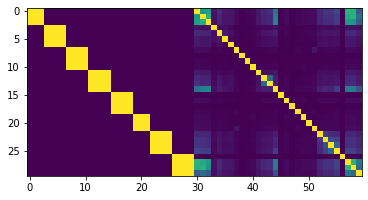

Logistic Regression Model
it:1/50---cost:-1.68e+00--- elapsed:100.21 [s]



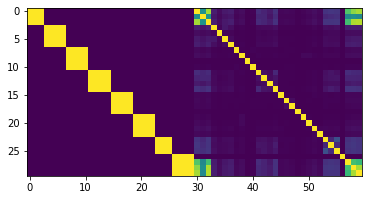

Linear SVM Model
it:1/50---cost:-1.74e+00--- elapsed:99.85 [s]



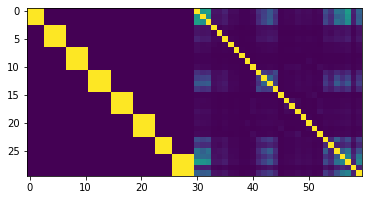

              precision    recall  f1-score   support

           1       1.00      0.39      0.56        41
           8       0.00      0.00      0.00         0

    accuracy                           0.39        41
   macro avg       0.50      0.20      0.28        41
weighted avg       1.00      0.39      0.56        41

              precision    recall  f1-score   support

           1       1.00      0.54      0.70        41
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.54        41
   macro avg       0.33      0.18      0.23        41
weighted avg       1.00      0.54      0.70        41

              precision    recall  f1-score   support

           1       1.00      0.44      0.61        41
           4       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy        

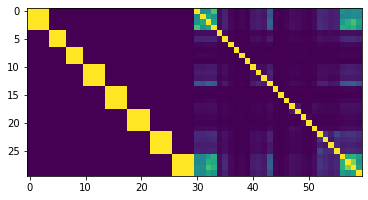

Logistic Regression Model
it:1/50---cost:-1.71e+00--- elapsed:108.56 [s]



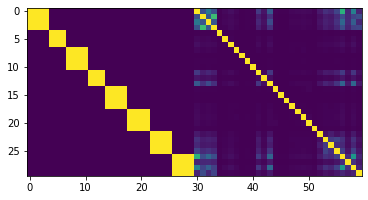

Linear SVM Model
it:1/50---cost:-1.72e+00--- elapsed:112.23 [s]



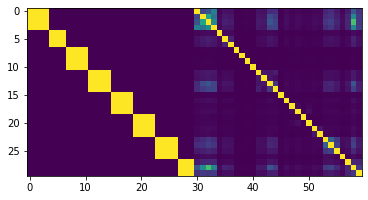

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Iteration =  12/80
Linear Model
it:1/50---cost:-1.70e+00--- elapsed:99.22 [s]



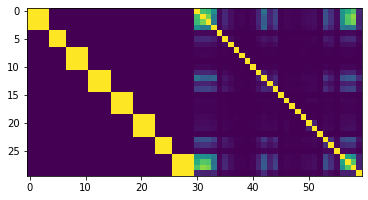

Logistic Regression Model
it:1/50---cost:-1.77e+00--- elapsed:97.17 [s]



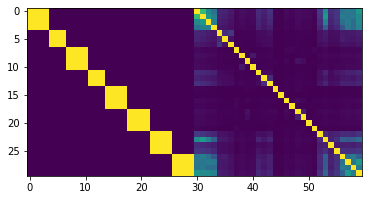

Linear SVM Model
it:1/50---cost:-1.73e+00--- elapsed:92.15 [s]



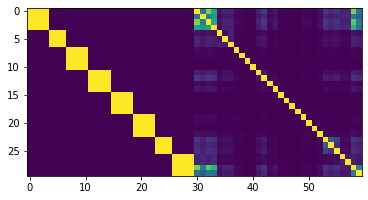

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  13/80
Linear Model
it:1/50---cost:-1.74e+00--- elapsed:95.84 [s]



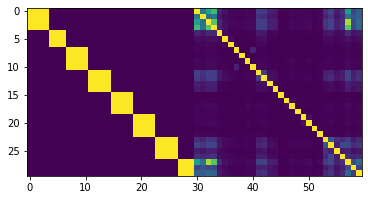

Logistic Regression Model
it:1/50---cost:-1.65e+00--- elapsed:101.65 [s]



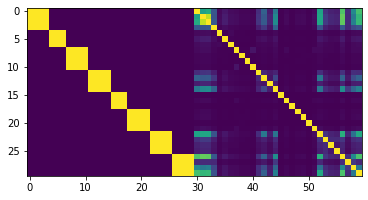

Linear SVM Model
it:1/50---cost:-1.72e+00--- elapsed:109.89 [s]



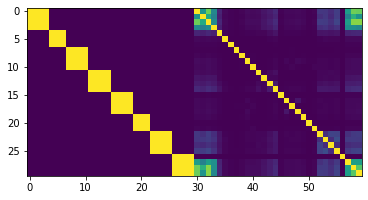

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Iteration =  14/80
Linear Model
it:1/50---cost:-1.75e+00--- elapsed:100.36 [s]



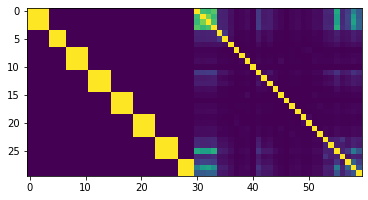

Logistic Regression Model
it:1/50---cost:-1.76e+00--- elapsed:93.37 [s]



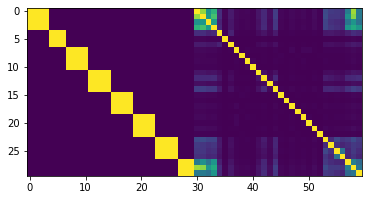

Linear SVM Model
it:1/50---cost:-1.64e+00--- elapsed:95.88 [s]



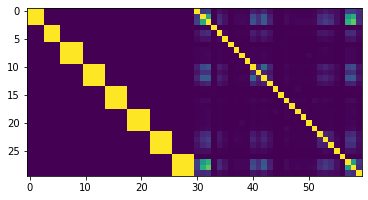

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      0.80      0.89        41
           8       0.00      0.00      0.00         0

    accuracy                           0.80        41
   macro avg       0.33      0.27      0.30        41
weighted avg       1.00      0.80      0.89        41

Iteration =  15/80
Linear Model
it:1/50---cost:-1.74e+00--- elapsed:108.5

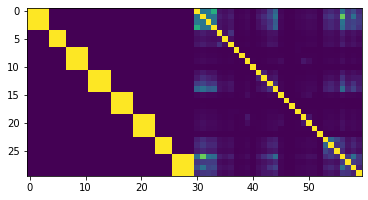

Logistic Regression Model
it:1/50---cost:-1.69e+00--- elapsed:94.30 [s]



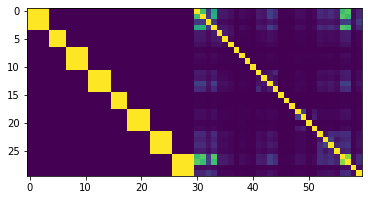

Linear SVM Model
it:1/50---cost:-1.73e+00--- elapsed:101.01 [s]



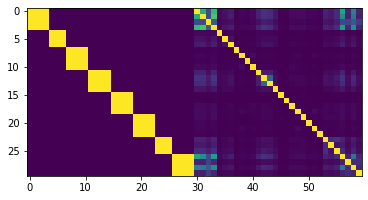

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Iteration =  16/80
Linear Model
it:1/50---cost:-1.74e+00--- elapsed:96.08 [s]



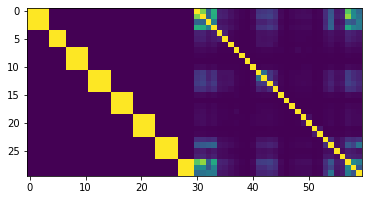

Logistic Regression Model
it:1/50---cost:-1.74e+00--- elapsed:94.82 [s]



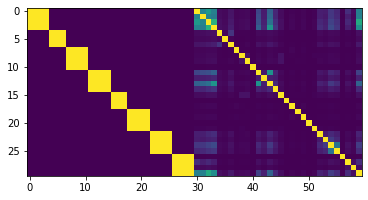

Linear SVM Model
it:1/50---cost:-1.68e+00--- elapsed:103.30 [s]



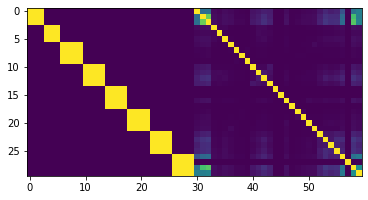

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  17/80
Linear Model
it:1/50---cost:-1.76e+00--- elapsed:109.46 [s]



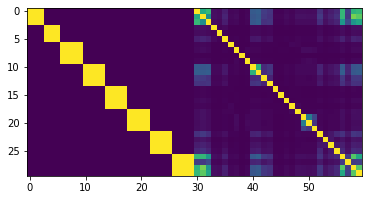

Logistic Regression Model
it:1/50---cost:-1.71e+00--- elapsed:100.24 [s]



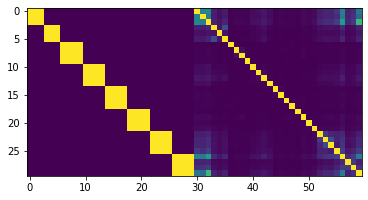

Linear SVM Model
it:1/50---cost:-1.77e+00--- elapsed:117.16 [s]



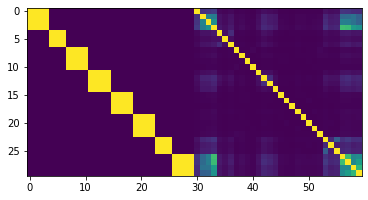

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Iteration =  18/80
Linear Model
it:1/50---cost:-1.80e+00--- elapsed:106.55 [s]



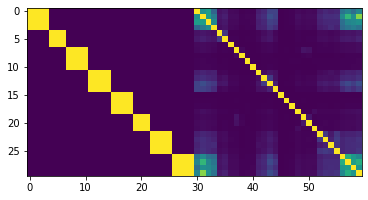

Logistic Regression Model
it:1/50---cost:-1.75e+00--- elapsed:101.52 [s]



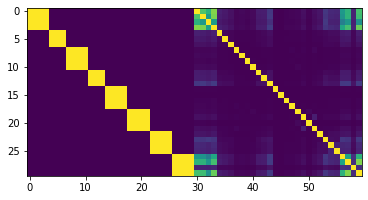

Linear SVM Model
it:1/50---cost:-1.71e+00--- elapsed:112.59 [s]



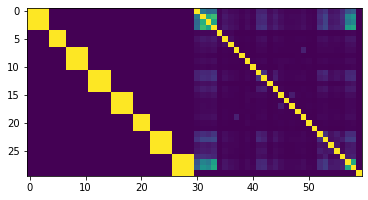

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  19/80
Linear Model
it:1/50---cost:-1.73e+00--- elapsed:94.82 [s]



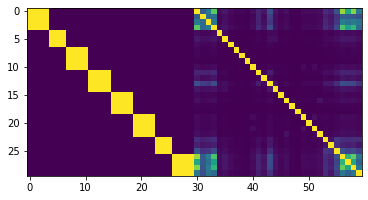

Logistic Regression Model
it:1/50---cost:-1.78e+00--- elapsed:101.19 [s]



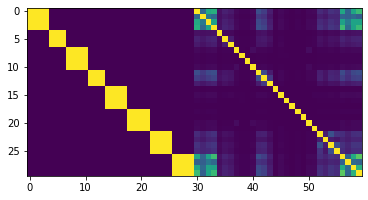

Linear SVM Model
it:1/50---cost:-1.72e+00--- elapsed:93.04 [s]



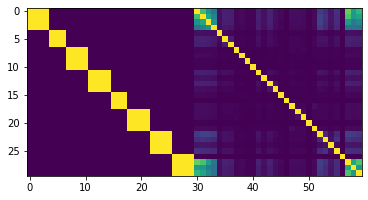

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  20/80
Linear Model
it:1/50---cost:-1.77e+00--- elapsed:92.28 [s]



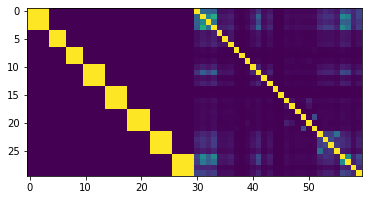

Logistic Regression Model
it:1/50---cost:-1.74e+00--- elapsed:104.33 [s]



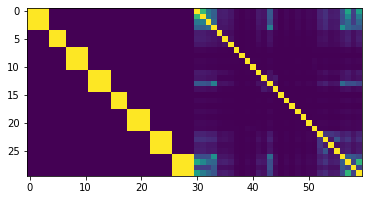

Linear SVM Model
it:1/50---cost:-1.72e+00--- elapsed:93.54 [s]



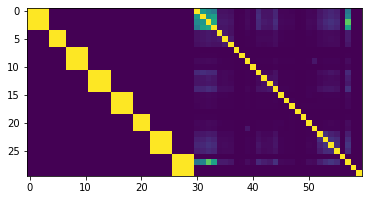

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      0.93      0.96        41
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.33      0.31      0.32        41
weighted avg       1.00      0.93      0.96        41

Iteration =  21/80
Linear Model
it:1/50---cost:-1.74e+00--- elapsed:99.86

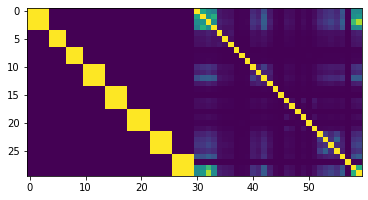

Logistic Regression Model
it:1/50---cost:-1.74e+00--- elapsed:94.12 [s]



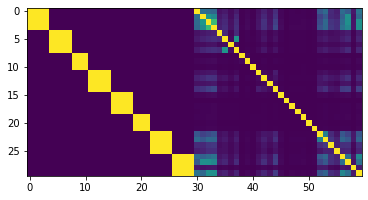

Linear SVM Model
it:1/50---cost:-1.70e+00--- elapsed:92.05 [s]



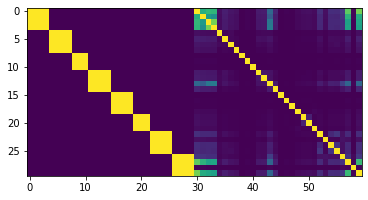

              precision    recall  f1-score   support

           3       1.00      0.90      0.95        41
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0.33      0.30      0.32        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           3       1.00      0.98      0.99        41
           6       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           3       1.00      0.95      0.97        41
           6       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1

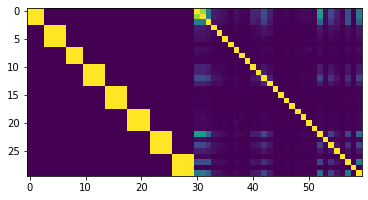

Logistic Regression Model
it:1/50---cost:-1.81e+00--- elapsed:95.85 [s]



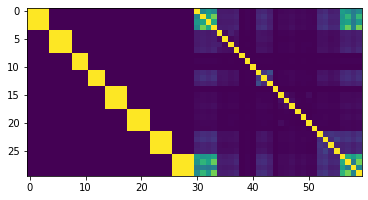

Linear SVM Model
it:1/50---cost:-1.70e+00--- elapsed:100.66 [s]



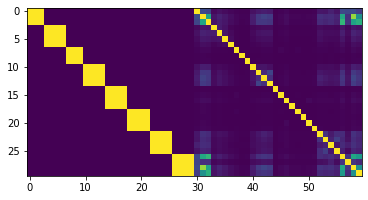

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Iteration =  23/80
Linear Model
it:1/50---cost:-1.74e+00--- elapsed:109.55 [s]



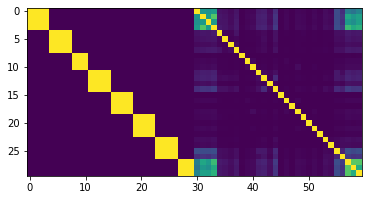

Logistic Regression Model
it:1/50---cost:-1.71e+00--- elapsed:110.05 [s]



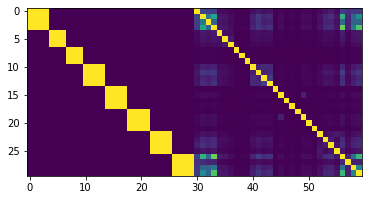

Linear SVM Model
it:1/50---cost:-1.69e+00--- elapsed:98.29 [s]



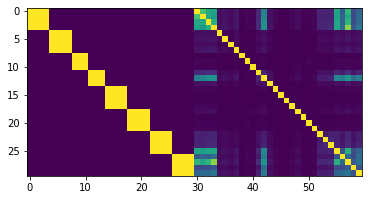

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       1.00      0.95      0.97        41

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

Iteration =  24/80
Linear Model
it:1/50---cost:-1.74e+00--- elapsed:100.84 [s]



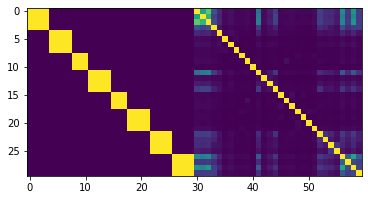

Logistic Regression Model
it:1/50---cost:-1.71e+00--- elapsed:103.70 [s]



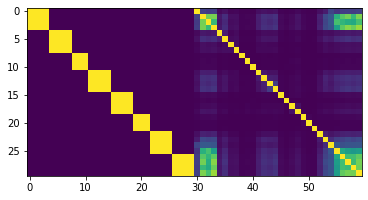

Linear SVM Model
it:1/50---cost:-1.76e+00--- elapsed:94.16 [s]



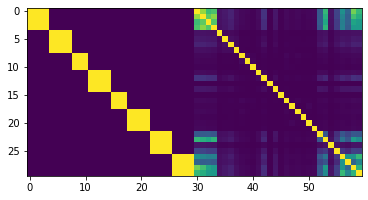

              precision    recall  f1-score   support

           3       1.00      0.98      0.99        41
           6       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           3       1.00      0.98      0.99        41
           6       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           3       1.00      0.93      0.96        41
           6       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.33      0.31      0.32        41
weighted avg       1

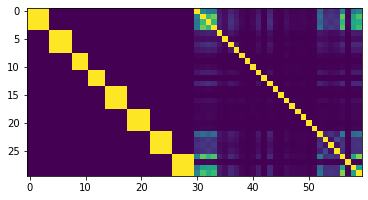

Logistic Regression Model
it:1/50---cost:-1.76e+00--- elapsed:92.54 [s]



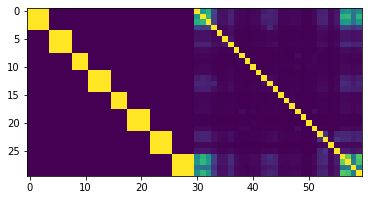

Linear SVM Model
it:1/50---cost:-1.73e+00--- elapsed:98.20 [s]



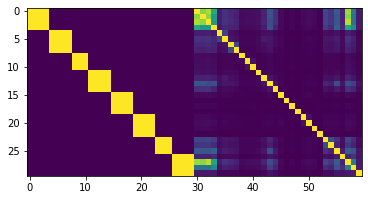

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       1.00      0.51      0.68        41
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.51        41
   macro avg       0.14      0.07      0.10        41
weighted avg       1.00      0.51      0.68        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       1.00      0.44      0.61        41
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00 

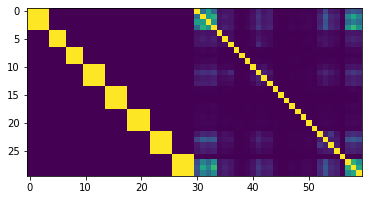

Logistic Regression Model
it:1/50---cost:-1.73e+00--- elapsed:96.75 [s]



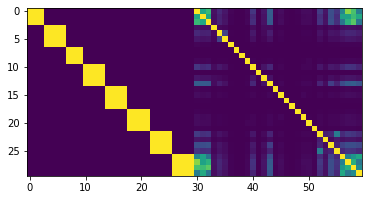

Linear SVM Model
it:1/50---cost:-1.70e+00--- elapsed:97.91 [s]



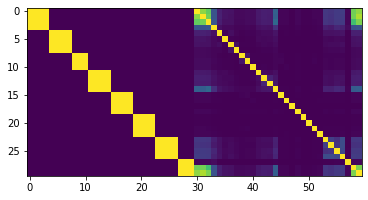

              precision    recall  f1-score   support

           3       1.00      0.88      0.94        41
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.88        41
   macro avg       0.33      0.29      0.31        41
weighted avg       1.00      0.88      0.94        41

              precision    recall  f1-score   support

           3       1.00      0.95      0.97        41
           6       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       1.00      0.78      0.88        41
           5       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy        

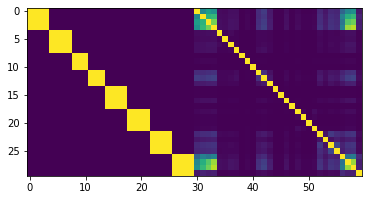

Logistic Regression Model
it:1/50---cost:-1.72e+00--- elapsed:101.91 [s]



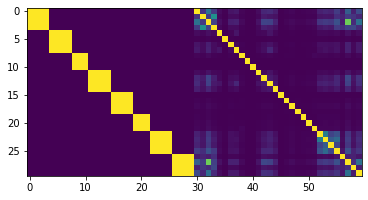

Linear SVM Model
it:1/50---cost:-1.75e+00--- elapsed:94.75 [s]



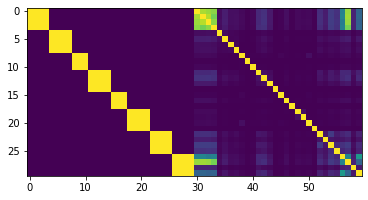

              precision    recall  f1-score   support

           3       1.00      0.98      0.99        41
           5       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           3       1.00      0.98      0.99        41
           5       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       1.00      0.88      0.94        41
           5       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.88        41
   macro avg       0

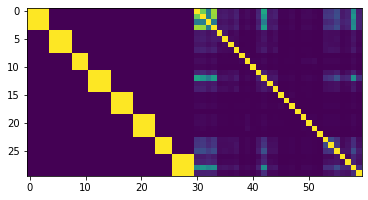

Logistic Regression Model
it:1/50---cost:-1.74e+00--- elapsed:92.24 [s]



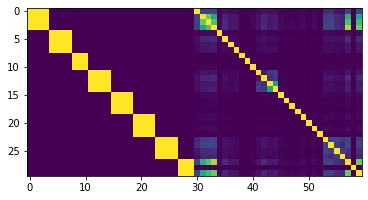

Linear SVM Model
it:1/50---cost:-1.78e+00--- elapsed:105.08 [s]



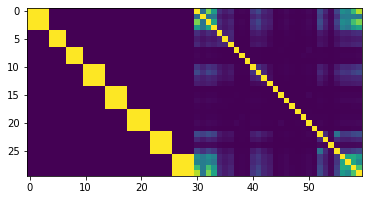

              precision    recall  f1-score   support

           3       1.00      0.95      0.97        41
           5       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           3       1.00      0.95      0.97        41
           5       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       1.00      0.93      0.96        41
           5       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.33      0.31      0.32        41
weighted avg       1

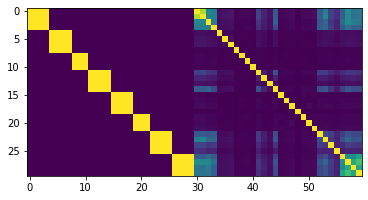

Logistic Regression Model
it:1/50---cost:-1.71e+00--- elapsed:110.43 [s]



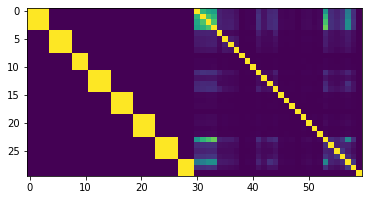

Linear SVM Model
it:1/50---cost:-1.76e+00--- elapsed:99.73 [s]



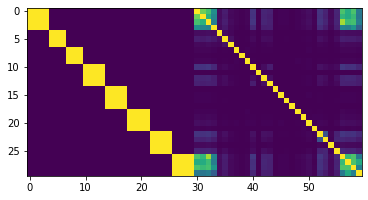

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       1.00      0.95      0.97        41
           8       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.33      0.32      0.33        41
weighted avg       1.00      0.95      0.98        41

Iteration =  30/80
Linear Model
it:1/50---cost:-1.69e+00--- elapsed:100.5

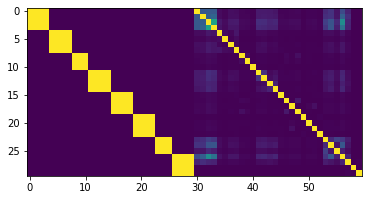

Logistic Regression Model
it:1/50---cost:-1.77e+00--- elapsed:109.66 [s]



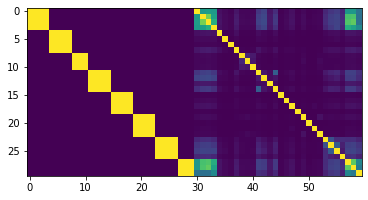

Linear SVM Model
it:1/50---cost:-1.77e+00--- elapsed:106.01 [s]



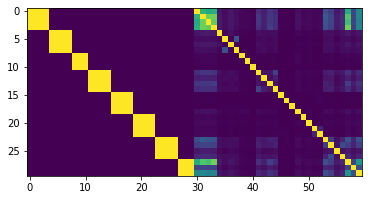

              precision    recall  f1-score   support

           3       1.00      0.95      0.97        41
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.33      0.32      0.33        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           3       1.00      0.95      0.97        41
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.33      0.32      0.33        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       1.00      0.93      0.96        41
           5       0.00      0.00      0.00         0
           6       0.

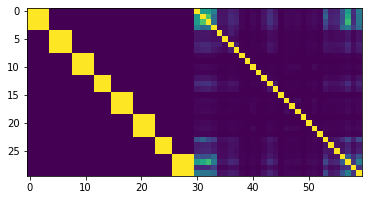

Logistic Regression Model
it:1/50---cost:-1.77e+00--- elapsed:95.97 [s]



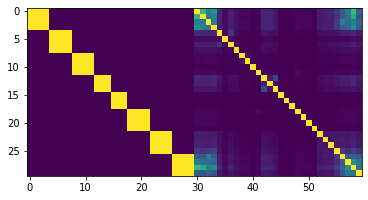

Linear SVM Model
it:1/50---cost:-1.70e+00--- elapsed:99.39 [s]



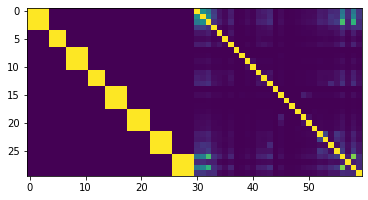

              precision    recall  f1-score   support

           4       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           4       1.00      0.95      0.97        41
           8       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.33      0.32      0.33        41
weighted avg       1.00      0.95      0.98        41

Iteration =  32/80


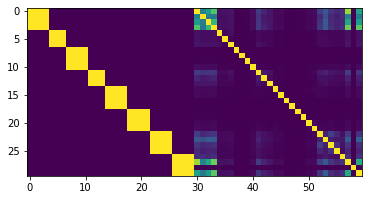

Logistic Regression Model
it:1/50---cost:-1.73e+00--- elapsed:100.45 [s]



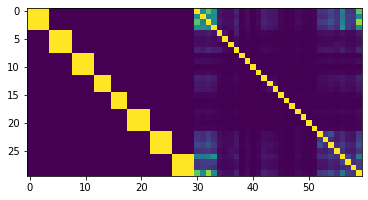

Linear SVM Model
it:1/50---cost:-1.71e+00--- elapsed:98.04 [s]



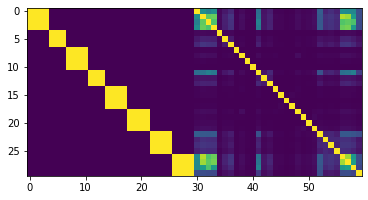

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Iteration =  33/80
Linear Model
it:1/50---cost:-1.71e+00--- elapsed:101.78 [s]



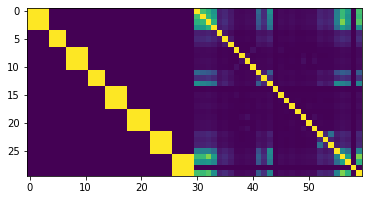

Logistic Regression Model
it:1/50---cost:-1.77e+00--- elapsed:107.40 [s]



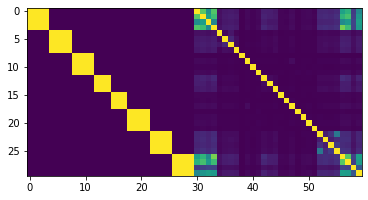

Linear SVM Model
it:1/50---cost:-1.69e+00--- elapsed:96.25 [s]



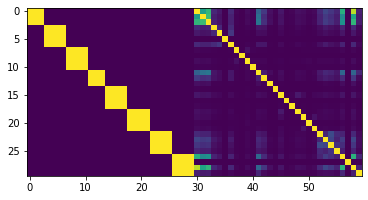

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Iteration =  34/80
Linear Model
it:1/50---cost:-1.76e+00--- elapsed:96.32 [s]



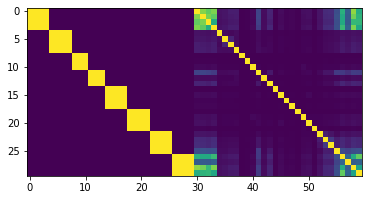

Logistic Regression Model
it:1/50---cost:-1.73e+00--- elapsed:94.94 [s]



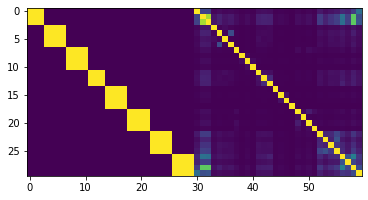

Linear SVM Model
it:1/50---cost:-1.78e+00--- elapsed:99.01 [s]



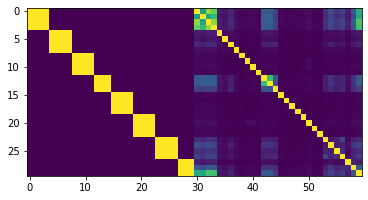

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           4       1.00      0.93      0.96        41
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

Iteration =  35/80
Linear Model
it:1/50---cost:-1.73e+00--- elapsed:95.06 [s]



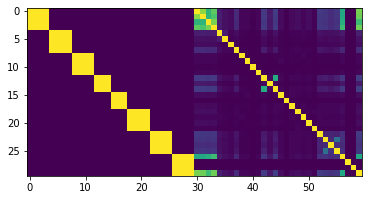

Logistic Regression Model
it:1/50---cost:-1.74e+00--- elapsed:97.08 [s]



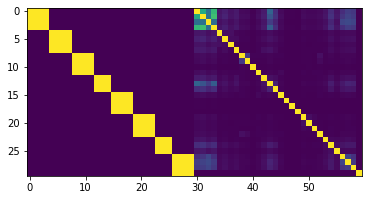

Linear SVM Model
it:1/50---cost:-1.74e+00--- elapsed:109.68 [s]



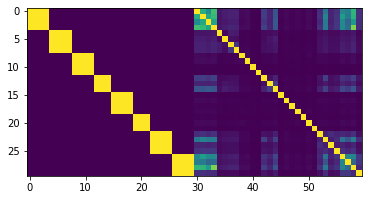

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           4       1.00      0.93      0.96        41

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

Iteration =  36/80
Linear Model
it:1/50---cost:-1.80e+00--- elapsed:121.32 [s]



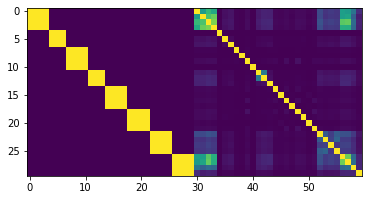

Logistic Regression Model
it:1/50---cost:-1.75e+00--- elapsed:101.37 [s]



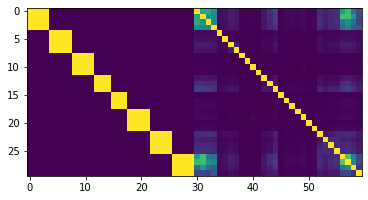

Linear SVM Model
it:1/50---cost:-1.74e+00--- elapsed:100.91 [s]



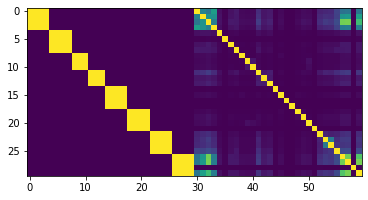

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           4       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Iteration =  37/80
Linear Model
it:1/50---cost:-1.71e+00--- elapsed:107.72 [s]



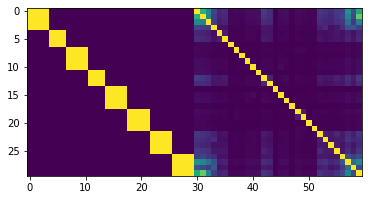

Logistic Regression Model
it:1/50---cost:-1.70e+00--- elapsed:108.01 [s]



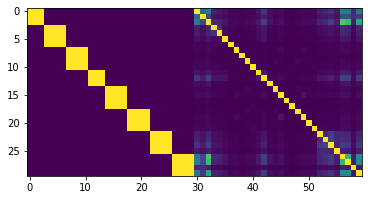

Linear SVM Model
it:1/50---cost:-1.71e+00--- elapsed:110.96 [s]



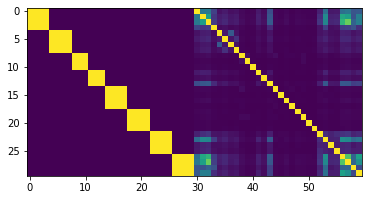

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Iteration =  38/80
Linear Model
it:1/50---cost:-1.74e+00--- elapsed:108.03 [s]



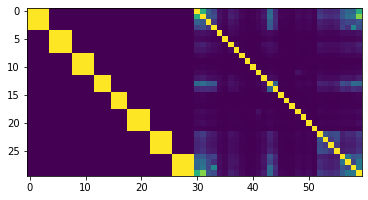

Logistic Regression Model
it:1/50---cost:-1.67e+00--- elapsed:109.60 [s]



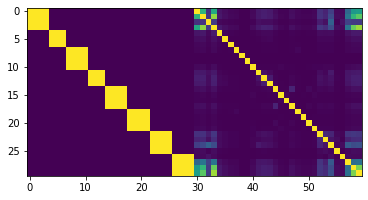

Linear SVM Model
it:1/50---cost:-1.70e+00--- elapsed:120.79 [s]



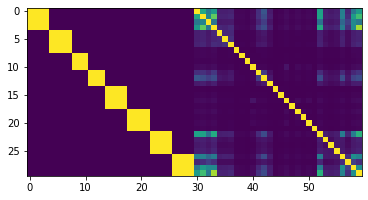

              precision    recall  f1-score   support

           4       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           4       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Iteration =  39/80
Linear Model
it:1/50---cost:-1.80e+00--- elapsed:107.8

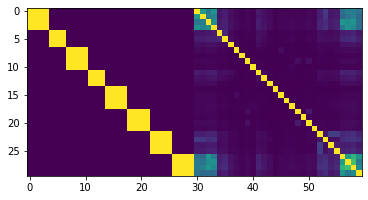

Logistic Regression Model
it:1/50---cost:-1.71e+00--- elapsed:105.70 [s]



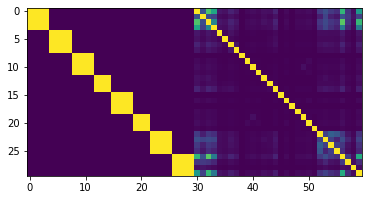

Linear SVM Model
it:1/50---cost:-1.82e+00--- elapsed:100.96 [s]



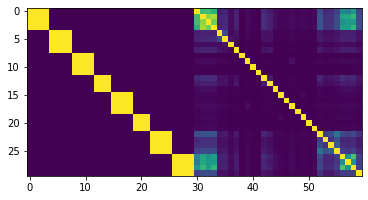

              precision    recall  f1-score   support

           4       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           4       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Iteration =  40/80
Linear Model
it:1/50---cost:-1.69e+00--- elapsed:100.8

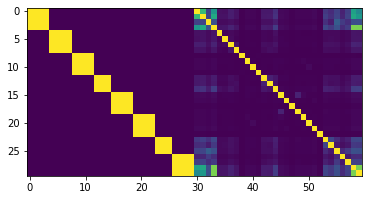

Logistic Regression Model
it:1/50---cost:-1.77e+00--- elapsed:101.18 [s]



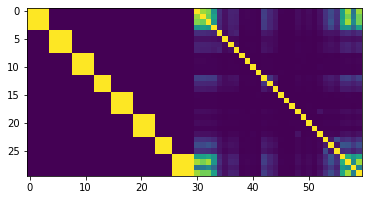

Linear SVM Model
it:1/50---cost:-1.71e+00--- elapsed:100.48 [s]



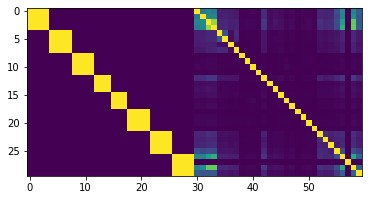

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           4       1.00      0.90      0.95        41
           8       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0.33      0.30      0.32        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           4       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           4       1.00      0.95      0.97        41
           8       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0

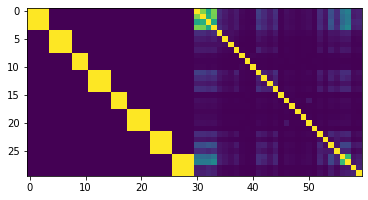

Logistic Regression Model
it:1/50---cost:-1.75e+00--- elapsed:97.89 [s]



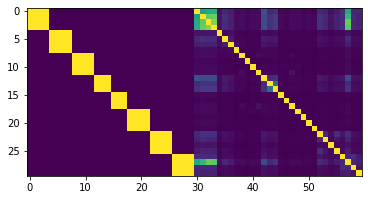

Linear SVM Model
it:1/50---cost:-1.78e+00--- elapsed:95.20 [s]



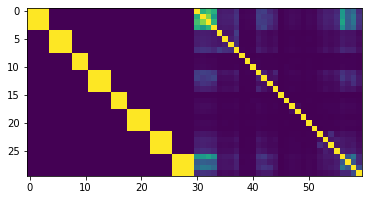

              precision    recall  f1-score   support

           5       1.00      0.80      0.89        41
           6       0.00      0.00      0.00         0

    accuracy                           0.80        41
   macro avg       0.50      0.40      0.45        41
weighted avg       1.00      0.80      0.89        41

              precision    recall  f1-score   support

           5       1.00      0.83      0.91        41
           6       0.00      0.00      0.00         0

    accuracy                           0.83        41
   macro avg       0.50      0.41      0.45        41
weighted avg       1.00      0.83      0.91        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           5       1.00      0.66      0.79        41
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy        

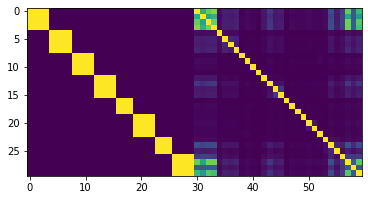

Logistic Regression Model
it:1/50---cost:-1.75e+00--- elapsed:100.51 [s]



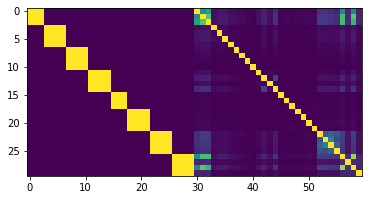

Linear SVM Model
it:1/50---cost:-1.69e+00--- elapsed:108.25 [s]



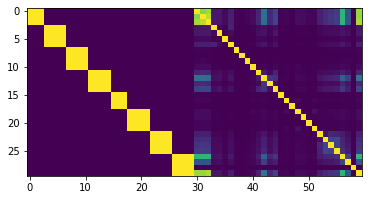

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       1.00      0.90      0.95        41
           6       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0.33      0.30      0.32        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       1.00      0.90      0.95        41
           6       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0.33      0.30      0.32        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       1.00      0.83      0.91        41
           6       0.

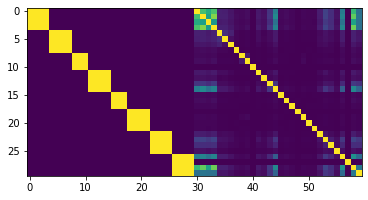

Logistic Regression Model
it:1/50---cost:-1.71e+00--- elapsed:107.21 [s]



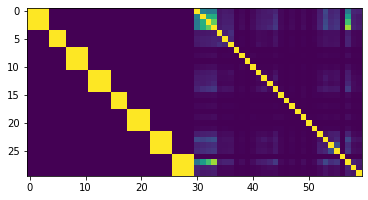

Linear SVM Model
it:1/50---cost:-1.74e+00--- elapsed:98.84 [s]



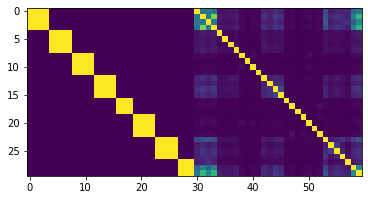

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       1.00      0.93      0.96        41
           6       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.33      0.31      0.32        41
weighted avg       1.00      0.93      0.96        41

              precision    recall  f1-score   support

           5       1.00      0.95      0.97        41
           6       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           5       1.00      0.93      0.96        41
           6       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0

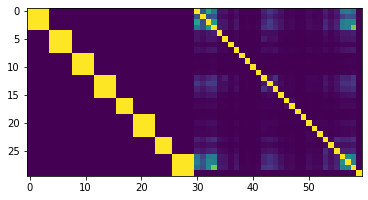

Logistic Regression Model
it:1/50---cost:-1.79e+00--- elapsed:109.06 [s]



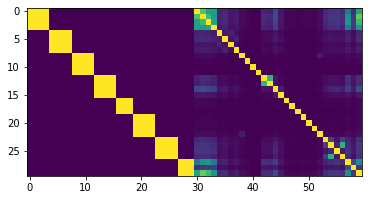

Linear SVM Model
it:1/50---cost:-1.76e+00--- elapsed:100.98 [s]



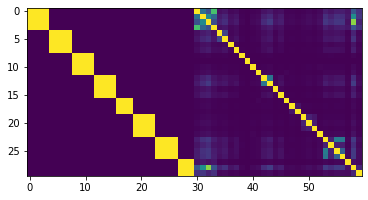

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       1.00      0.71      0.83        41
           6       0.00      0.00      0.00         0

    accuracy                           0.71        41
   macro avg       0.33      0.24      0.28        41
weighted avg       1.00      0.71      0.83        41

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       1.00      0.83      0.91        41
           6       0.00      0.00      0.00         0

    accuracy                           0.83        41
   macro avg       0.33      0.28      0.30        41
weighted avg       1.00      0.83      0.91        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       1.00      0.80      0.89        41
           6       0.

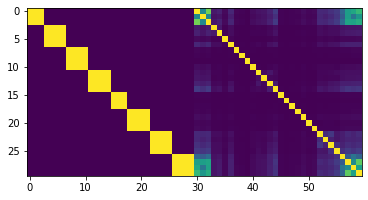

Logistic Regression Model
it:1/50---cost:-1.74e+00--- elapsed:101.03 [s]



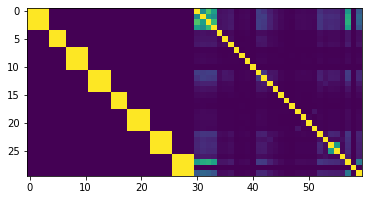

Linear SVM Model
it:1/50---cost:-1.79e+00--- elapsed:109.82 [s]



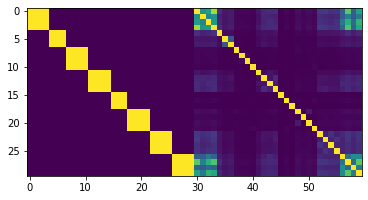

              precision    recall  f1-score   support

           5       1.00      0.95      0.97        41
           6       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           5       1.00      0.98      0.99        41
           6       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           5       1.00      0.98      0.99        41
           6       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  46/80


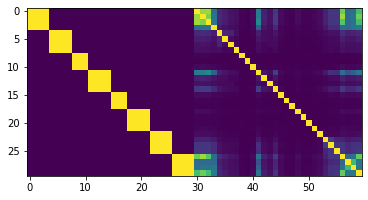

Logistic Regression Model
it:1/50---cost:-1.76e+00--- elapsed:94.69 [s]



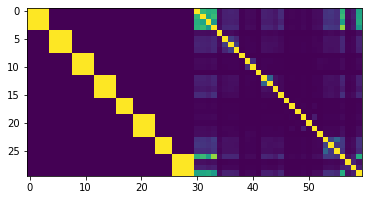

Linear SVM Model
it:1/50---cost:-1.74e+00--- elapsed:95.16 [s]



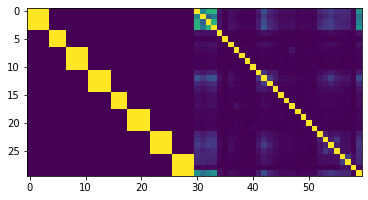

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       1.00      0.88      0.94        41
           6       0.00      0.00      0.00         0

    accuracy                           0.88        41
   macro avg       0.33      0.29      0.31        41
weighted avg       1.00      0.88      0.94        41

              precision    recall  f1-score   support

           5       1.00      0.95      0.97        41
           6       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           5       1.00      0.98      0.99        41
           6       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1

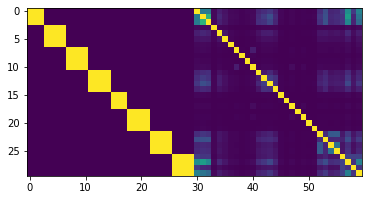

Logistic Regression Model
it:1/50---cost:-1.74e+00--- elapsed:99.77 [s]



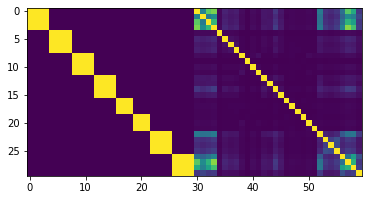

Linear SVM Model
it:1/50---cost:-1.75e+00--- elapsed:101.35 [s]



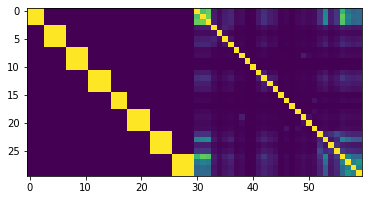

              precision    recall  f1-score   support

           5       1.00      0.98      0.99        41
           6       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           5       1.00      0.98      0.99        41
           6       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           5       1.00      0.90      0.95        41
           6       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0

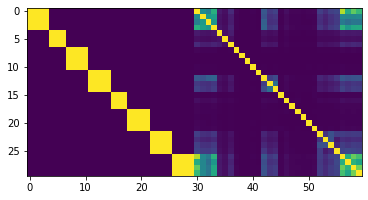

Logistic Regression Model
it:1/50---cost:-1.78e+00--- elapsed:188.62 [s]



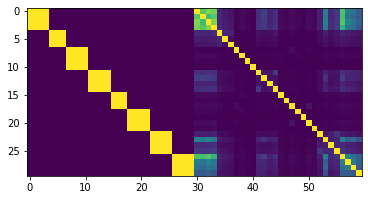

Linear SVM Model
it:1/50---cost:-1.65e+00--- elapsed:214.67 [s]



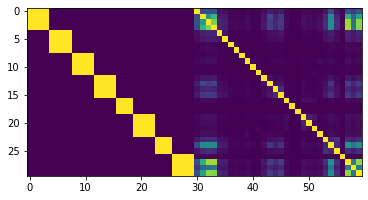

              precision    recall  f1-score   support

           5       1.00      0.90      0.95        41
           6       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0.50      0.45      0.47        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           5       1.00      0.95      0.97        41
           6       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           5       1.00      0.85      0.92        41
           6       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.85        41
   macro avg       0

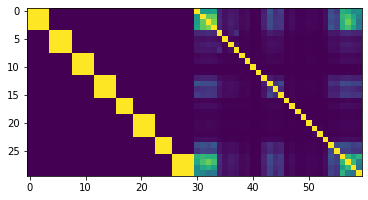

Logistic Regression Model
it:1/50---cost:-1.79e+00--- elapsed:211.83 [s]



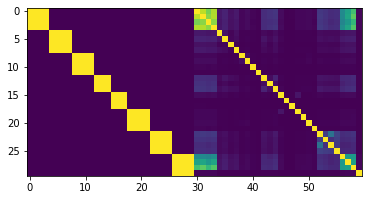

Linear SVM Model
it:1/50---cost:-1.72e+00--- elapsed:98.17 [s]



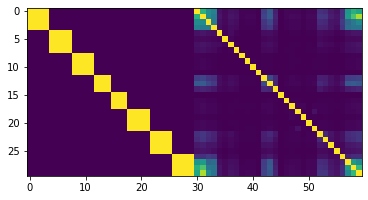

              precision    recall  f1-score   support

           5       1.00      0.90      0.95        41
           6       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0.50      0.45      0.47        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           5       1.00      0.90      0.95        41
           6       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0.50      0.45      0.47        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           5       1.00      0.83      0.91        41
           6       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.83        41
   macro avg       0

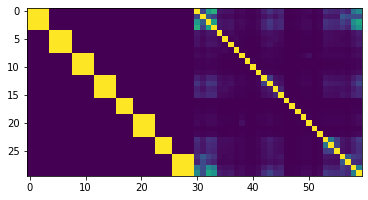

Logistic Regression Model
it:1/50---cost:-1.74e+00--- elapsed:91.12 [s]



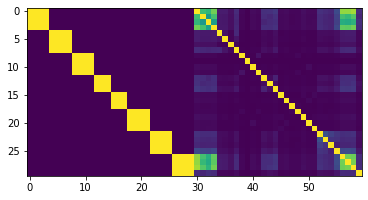

Linear SVM Model
it:1/50---cost:-1.67e+00--- elapsed:98.06 [s]



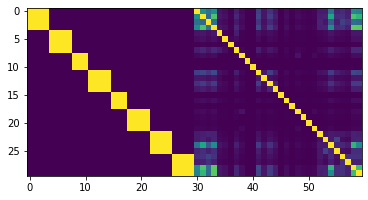

              precision    recall  f1-score   support

           5       1.00      0.98      0.99        41
           6       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           5       1.00      0.98      0.99        41
           6       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           5       1.00      0.85      0.92        41
           8       0.00      0.00      0.00         0

    accuracy                           0.85        41
   macro avg       0.33      0.28      0.31        41
weighted avg       1

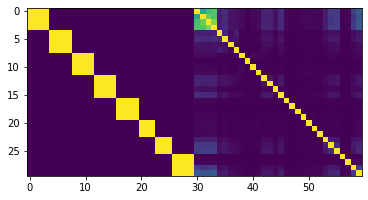

Logistic Regression Model
it:1/50---cost:-1.72e+00--- elapsed:159.10 [s]



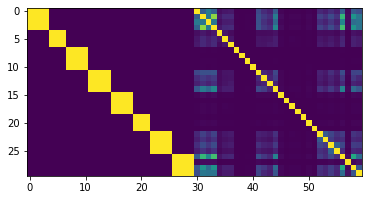

Linear SVM Model
it:1/50---cost:-1.77e+00--- elapsed:140.50 [s]



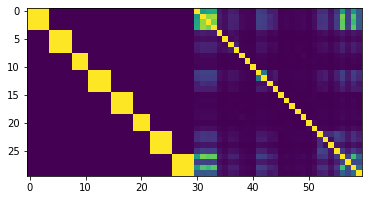

              precision    recall  f1-score   support

           6       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           6       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           6       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  52/80
Linear Model
it:1/50---cost:-1.71e+00--- elapsed:122.18 [s]



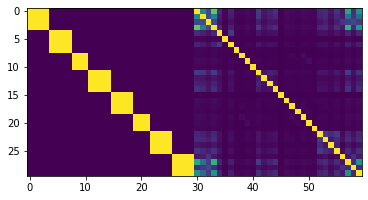

Logistic Regression Model
it:1/50---cost:-1.74e+00--- elapsed:180.42 [s]



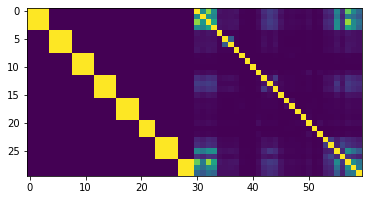

Linear SVM Model
it:1/50---cost:-1.65e+00--- elapsed:177.12 [s]



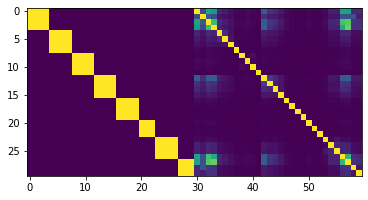

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.88      0.94        41

    accuracy                           0.88        41
   macro avg       0.33      0.29      0.31        41
weighted avg       1.00      0.88      0.94        41

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.90      0.95        41

    accuracy                           0.90        41
   macro avg       0.33      0.30      0.32        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.

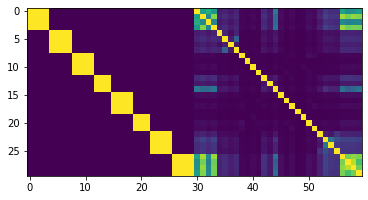

Logistic Regression Model
it:1/50---cost:-1.73e+00--- elapsed:92.61 [s]



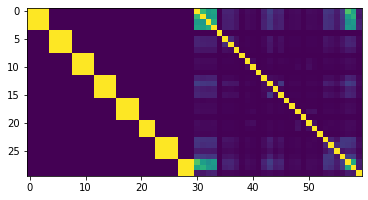

Linear SVM Model
it:1/50---cost:-1.75e+00--- elapsed:102.46 [s]



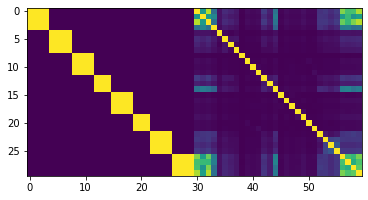

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.88      0.94        41

    accuracy                           0.88        41
   macro avg       0.33      0.29      0.31        41
weighted avg       1.00      0.88      0.94        41

              precision    recall  f1-score   support

           5       0.00      0.00      0.00         0
           6       1.00      0.95      0.97        41

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.85      0.92        41
           8       0.

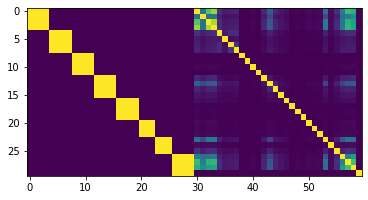

Logistic Regression Model
it:1/50---cost:-1.72e+00--- elapsed:93.77 [s]



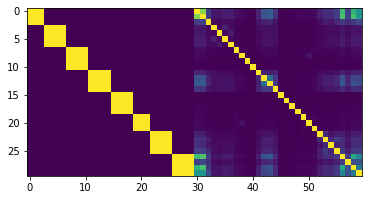

Linear SVM Model
it:1/50---cost:-1.73e+00--- elapsed:96.09 [s]



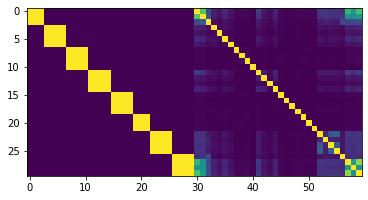

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.90      0.95        41

    accuracy                           0.90        41
   macro avg       0.33      0.30      0.32        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.90      0.95        41

    accuracy                           0.90        41
   macro avg       0.33      0.30      0.32        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.

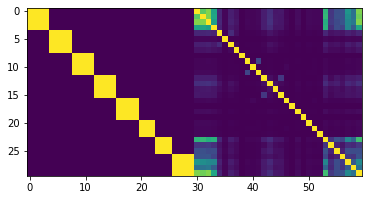

Logistic Regression Model
it:1/50---cost:-1.70e+00--- elapsed:186.68 [s]



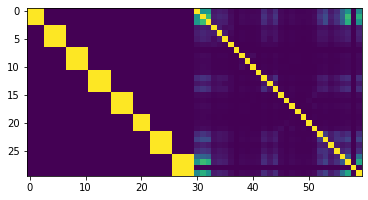

Linear SVM Model
it:1/50---cost:-1.62e+00--- elapsed:203.18 [s]



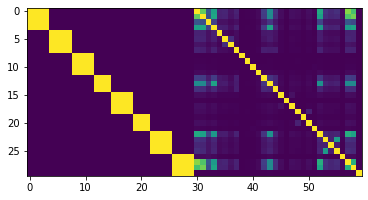

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           6       1.00      0.93      0.96        41

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.95      0.97        41

    accuracy                           0.95        41
   macro avg       0.33      0.32      0.33        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           6       1.00      0.90      0.95        41
           8       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0

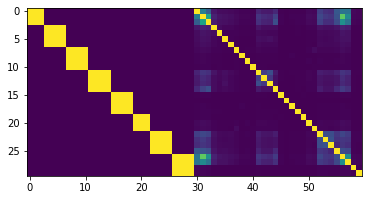

Logistic Regression Model
it:1/50---cost:-1.82e+00--- elapsed:215.15 [s]



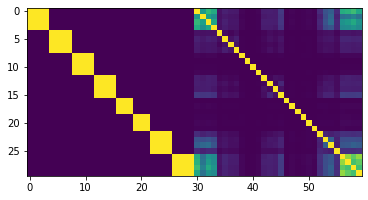

Linear SVM Model
it:1/50---cost:-1.75e+00--- elapsed:97.17 [s]



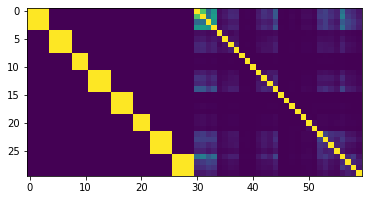

              precision    recall  f1-score   support

           6       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           6       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           6       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  57/80
Linear Model
it:1/50---cost:-1.72e+00--- elapsed:102.19 [s]



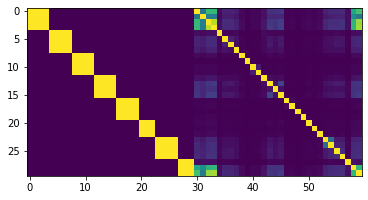

Logistic Regression Model
it:1/50---cost:-1.73e+00--- elapsed:100.28 [s]



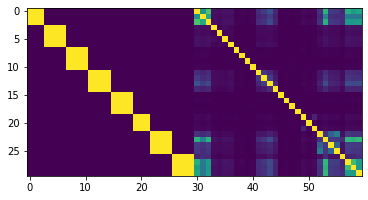

Linear SVM Model
it:1/50---cost:-1.70e+00--- elapsed:124.25 [s]



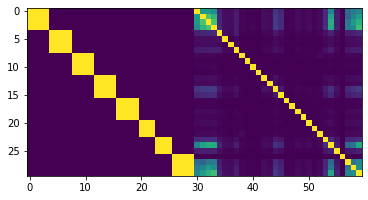

              precision    recall  f1-score   support

           5       0.00      0.00      0.00         0
           6       1.00      0.95      0.97        41

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           5       0.00      0.00      0.00         0
           6       1.00      0.95      0.97        41

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.88      0.94        41
           8       0.00      0.00      0.00         0

    accuracy                           0.88        41
   macro avg       0

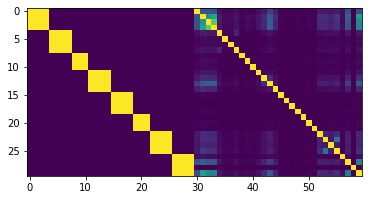

Logistic Regression Model
it:1/50---cost:-1.69e+00--- elapsed:302.86 [s]



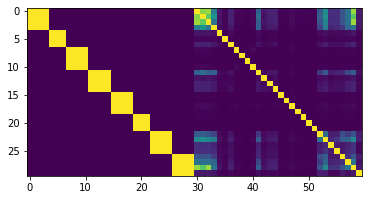

Linear SVM Model
it:1/50---cost:-1.73e+00--- elapsed:292.25 [s]



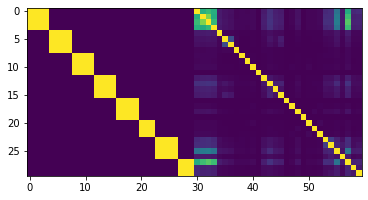

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.93      0.96        41

    accuracy                           0.93        41
   macro avg       0.33      0.31      0.32        41
weighted avg       1.00      0.93      0.96        41

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.93      0.96        41

    accuracy                           0.93        41
   macro avg       0.33      0.31      0.32        41
weighted avg       1.00      0.93      0.96        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.

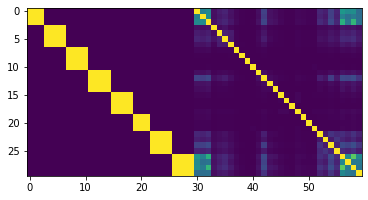

Logistic Regression Model
it:1/50---cost:-1.71e+00--- elapsed:269.50 [s]



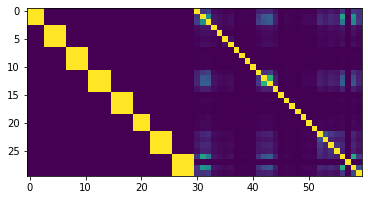

Linear SVM Model
it:1/50---cost:-1.77e+00--- elapsed:302.73 [s]



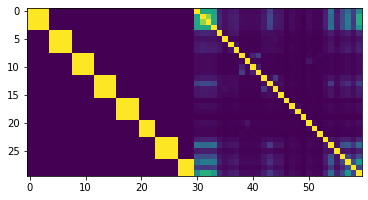

              precision    recall  f1-score   support

           6       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           6       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           6       1.00      0.93      0.96        41
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.33      0.31      0.32        41
weighted avg       1.00      0.93      0.96        41

Iteration =  60/80
Linear Model
it:1/50---cost:-1.73e+00--- elapsed:223.2

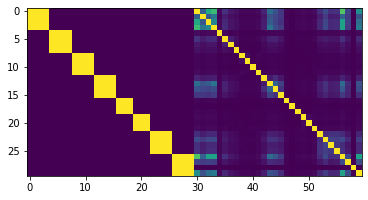

Logistic Regression Model
it:1/50---cost:-1.76e+00--- elapsed:192.25 [s]



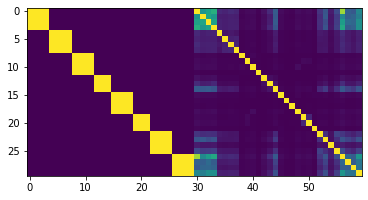

Linear SVM Model
it:1/50---cost:-1.69e+00--- elapsed:100.85 [s]



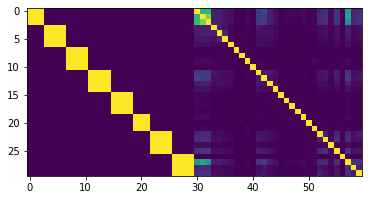

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.59      0.74        41

    accuracy                           0.59        41
   macro avg       0.33      0.20      0.25        41
weighted avg       1.00      0.59      0.74        41

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.63      0.78        41

    accuracy                           0.63        41
   macro avg       0.33      0.21      0.26        41
weighted avg       1.00      0.63      0.78        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.

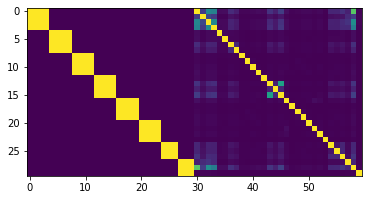

Logistic Regression Model
it:1/50---cost:-1.74e+00--- elapsed:101.91 [s]



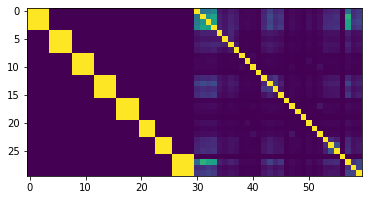

Linear SVM Model
it:1/50---cost:-1.72e+00--- elapsed:108.54 [s]



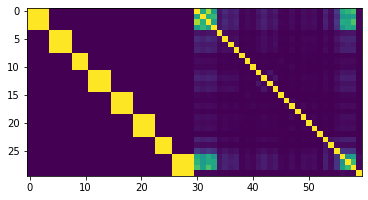

              precision    recall  f1-score   support

           7       1.00      0.95      0.97        41
           8       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           7       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           7       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  62/80


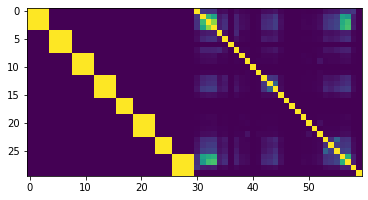

Logistic Regression Model
it:1/50---cost:-1.70e+00--- elapsed:101.15 [s]



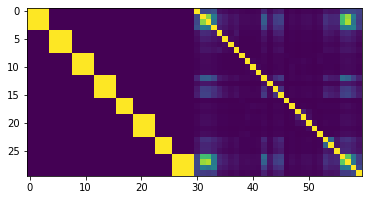

Linear SVM Model
it:1/50---cost:-1.78e+00--- elapsed:95.15 [s]



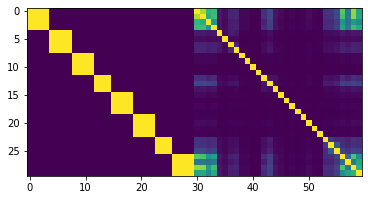

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           7       1.00      0.95      0.97        41
           8       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.33      0.32      0.33        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           7       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           7       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  63/80


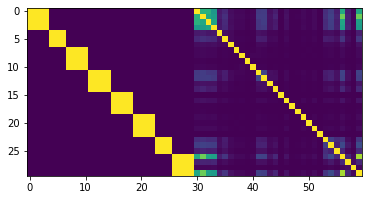

Logistic Regression Model
it:1/50---cost:-1.75e+00--- elapsed:101.64 [s]



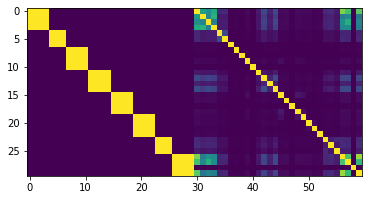

Linear SVM Model
it:1/50---cost:-1.68e+00--- elapsed:97.62 [s]



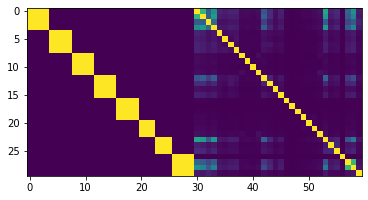

              precision    recall  f1-score   support

           7       1.00      0.95      0.97        41
           8       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           7       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           7       1.00      0.90      0.95        41
           8       0.00      0.00      0.00         0

    accuracy                           0.90        41
   macro avg       0.50      0.45      0.47        41
weighted avg       1.00      0.90      0.95        41

Iteration =  64/80


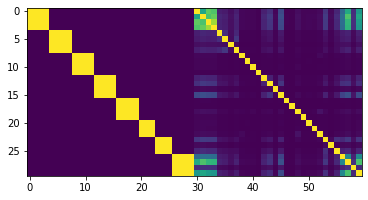

Logistic Regression Model
it:1/50---cost:-1.65e+00--- elapsed:117.64 [s]



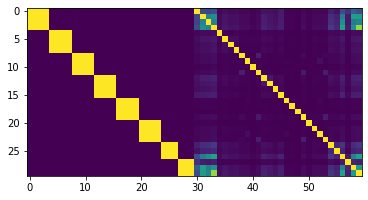

Linear SVM Model
it:1/50---cost:-1.66e+00--- elapsed:97.94 [s]



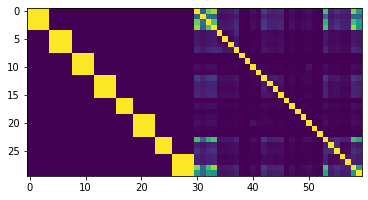

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           7       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           7       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           7       1.00      0.95      0.97        41
           8       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.33      0.32      0.33        41
weighted avg       1.00      0.95      0.98        41

Iteration =  65/80


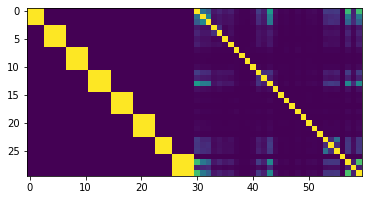

Logistic Regression Model
it:1/50---cost:-1.75e+00--- elapsed:92.28 [s]



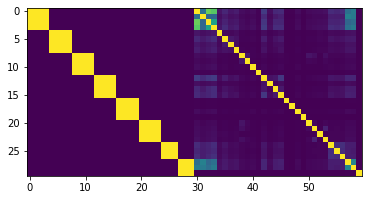

Linear SVM Model
it:1/50---cost:-1.78e+00--- elapsed:102.15 [s]



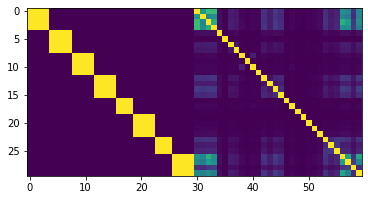

              precision    recall  f1-score   support

           7       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           7       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           7       1.00      0.93      0.96        41

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

Iteration =  66/80
Linear Model
it:1/50---cost:-1.77e+00--- elapsed:92.48 [s]



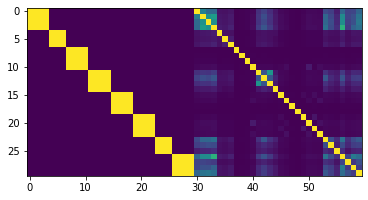

Logistic Regression Model
it:1/50---cost:-1.69e+00--- elapsed:101.72 [s]



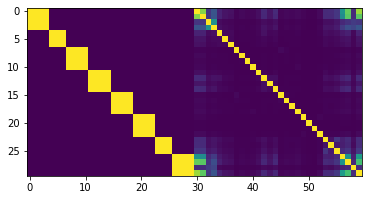

Linear SVM Model
it:1/50---cost:-1.75e+00--- elapsed:109.10 [s]



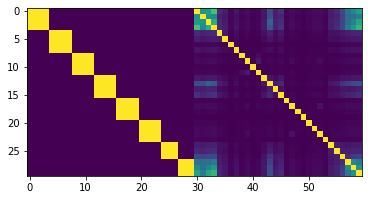

              precision    recall  f1-score   support

           7       1.00      0.93      0.96        41
           8       0.00      0.00      0.00         0

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

              precision    recall  f1-score   support

           7       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           7       1.00      0.98      0.99        41
           8       0.00      0.00      0.00         0

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  67/80


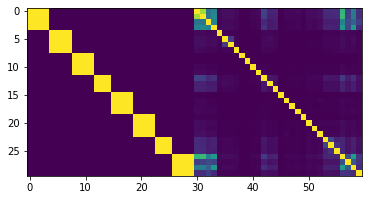

Logistic Regression Model
it:1/50---cost:-1.77e+00--- elapsed:97.08 [s]



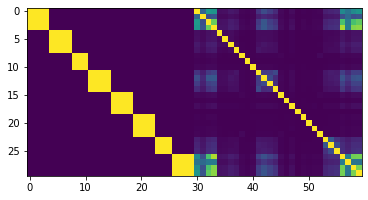

Linear SVM Model
it:1/50---cost:-1.64e+00--- elapsed:99.01 [s]



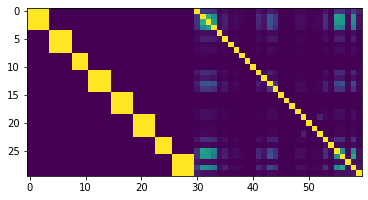

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           7       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           7       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           7       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Iteration =  68/80
Linear Model
it:1/50---cost:-1.77e+00--- elapsed:94.34 [s]



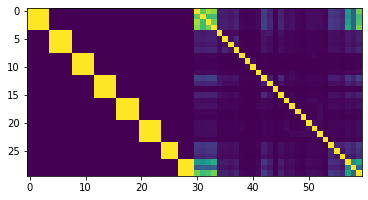

Logistic Regression Model
it:1/50---cost:-1.75e+00--- elapsed:100.75 [s]



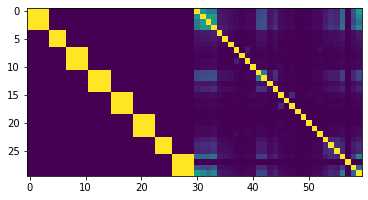

Linear SVM Model
it:1/50---cost:-1.64e+00--- elapsed:93.69 [s]



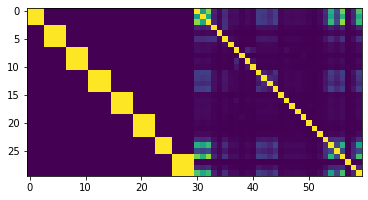

              precision    recall  f1-score   support

           7       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           7       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           7       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  69/80
Linear Model
it:1/50---cost:-1.75e+00--- elapsed:101.28 [s]



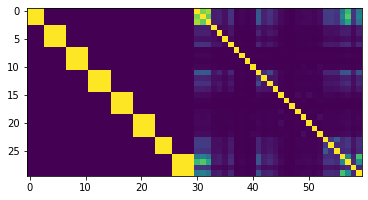

Logistic Regression Model
it:1/50---cost:-1.70e+00--- elapsed:98.07 [s]



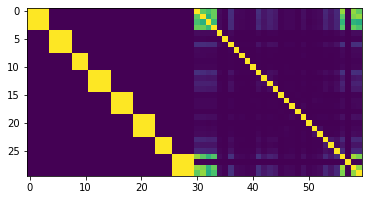

Linear SVM Model
it:1/50---cost:-1.74e+00--- elapsed:99.70 [s]



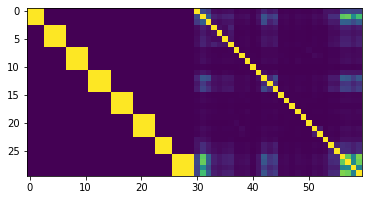

              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
           7       1.00      0.95      0.97        41
           8       0.00      0.00      0.00         0

    accuracy                           0.95        41
   macro avg       0.33      0.32      0.33        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
           7       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
           7       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1

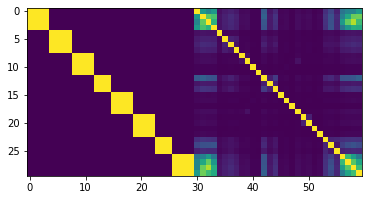

Logistic Regression Model
it:1/50---cost:-1.68e+00--- elapsed:98.18 [s]



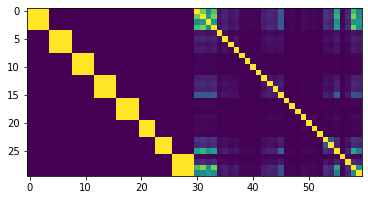

Linear SVM Model
it:1/50---cost:-1.77e+00--- elapsed:101.72 [s]



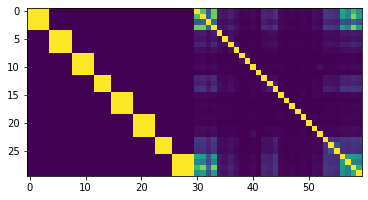

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           7       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           7       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           7       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  71/80
Linear Model
it:1/50---cost:-1.71e+00--- elapsed:102.2

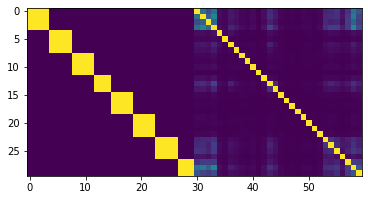

Logistic Regression Model
it:1/50---cost:-1.68e+00--- elapsed:100.79 [s]



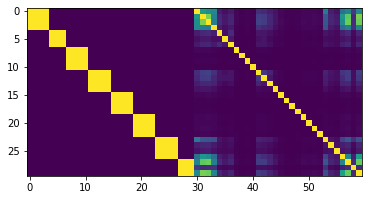

Linear SVM Model
it:1/50---cost:-1.73e+00--- elapsed:98.61 [s]



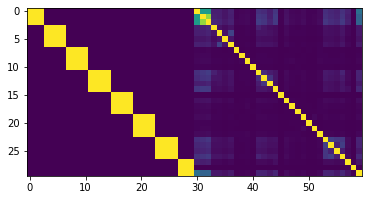

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.78      0.88        41

    accuracy                           0.78        41
   macro avg       0.50      0.39      0.44        41
weighted avg       1.00      0.78      0.88        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.80      0.89        41

    accuracy                           0.80        41
   macro avg       0.50      0.40      0.45        41
weighted avg       1.00      0.80      0.89        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.83      0.91        41

    accuracy                           0.83        41
   macro avg       0.50      0.41      0.45        41
weighted avg       1.00      0.83      0.91        41

Iteration =  72/80


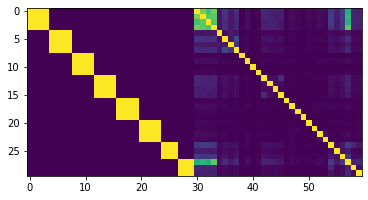

Logistic Regression Model
it:1/50---cost:-1.70e+00--- elapsed:101.20 [s]



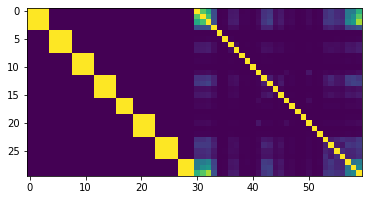

Linear SVM Model
it:1/50---cost:-1.71e+00--- elapsed:106.26 [s]



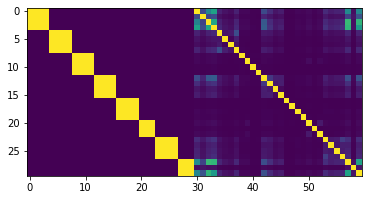

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.95      0.97        41

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

Iteration =  73/80


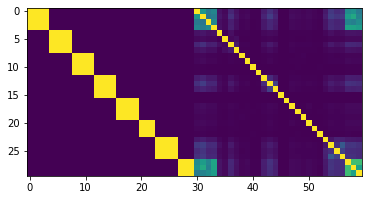

Logistic Regression Model
it:1/50---cost:-1.75e+00--- elapsed:109.09 [s]



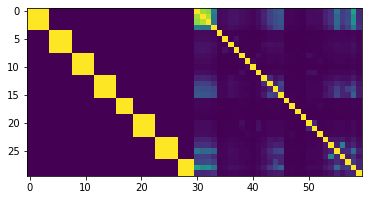

Linear SVM Model
it:1/50---cost:-1.76e+00--- elapsed:99.87 [s]



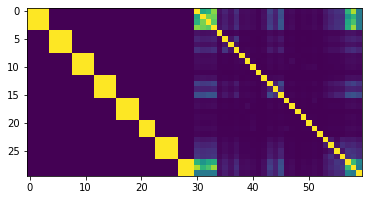

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.95      0.97        41

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.85      0.92        41

    accuracy                           0.85        41
   macro avg       0.50      0.43      0.46        41
weighted avg       1.00      0.85      0.92        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.76      0.86        41

    accuracy                           0.76        41
   macro avg       0.50      0.38      0.43        41
weighted avg       1.00      0.76      0.86        41

Iteration =  74/80


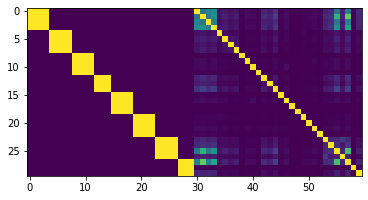

Logistic Regression Model
it:1/50---cost:-1.68e+00--- elapsed:99.39 [s]



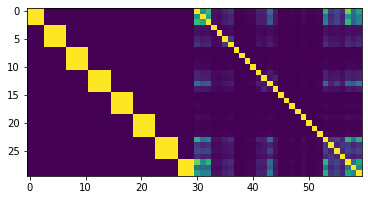

Linear SVM Model
it:1/50---cost:-1.72e+00--- elapsed:99.64 [s]



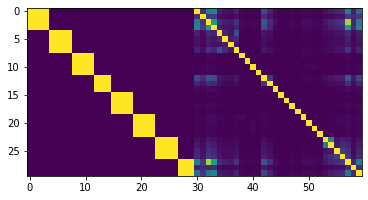

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           7       0.00      0.00      0.00         0
           8       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  75/80


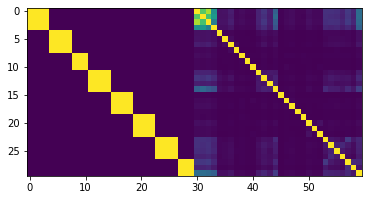

Logistic Regression Model
it:1/50---cost:-1.80e+00--- elapsed:98.37 [s]



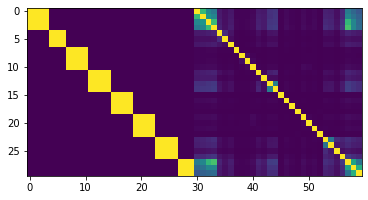

Linear SVM Model
it:1/50---cost:-1.74e+00--- elapsed:110.93 [s]



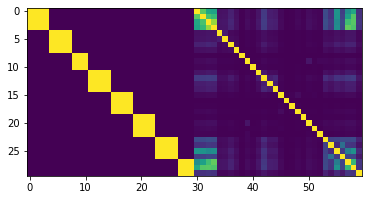

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.90      0.95        41

    accuracy                           0.90        41
   macro avg       0.50      0.45      0.47        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.78      0.88        41

    accuracy                           0.78        41
   macro avg       0.50      0.39      0.44        41
weighted avg       1.00      0.78      0.88        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           8       1.00      0.66      0.79        41

    accuracy                           0.66        41
   macro avg       0.33      0.22      0.26        41
weighted avg       1

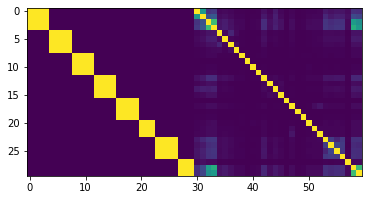

Logistic Regression Model
it:1/50---cost:-1.72e+00--- elapsed:99.29 [s]



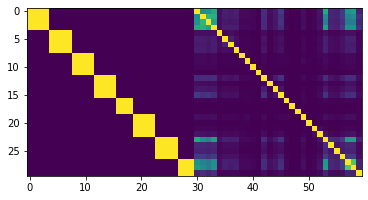

Linear SVM Model
it:1/50---cost:-1.71e+00--- elapsed:96.06 [s]



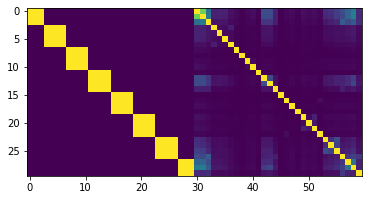

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.63      0.78        41

    accuracy                           0.63        41
   macro avg       0.50      0.32      0.39        41
weighted avg       1.00      0.63      0.78        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           8       1.00      0.46      0.63        41

    accuracy                           0.46        41
   macro avg       0.33      0.15      0.21        41
weighted avg       1.00      0.46      0.63        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       1.00      0.46      0.63        41

    accuracy        

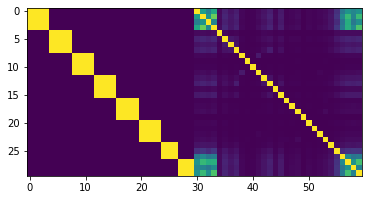

Logistic Regression Model
it:1/50---cost:-1.66e+00--- elapsed:96.70 [s]



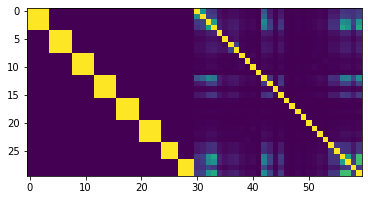

Linear SVM Model
it:1/50---cost:-1.74e+00--- elapsed:96.17 [s]



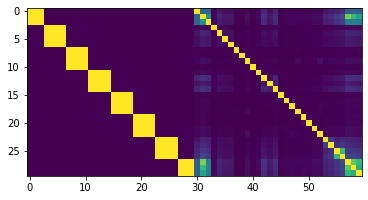

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.93      0.96        41

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.90      0.95        41

    accuracy                           0.90        41
   macro avg       0.50      0.45      0.47        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.88      0.94        41

    accuracy                           0.88        41
   macro avg       0.50      0.44      0.47        41
weighted avg       1.00      0.88      0.94        41

Iteration =  78/80


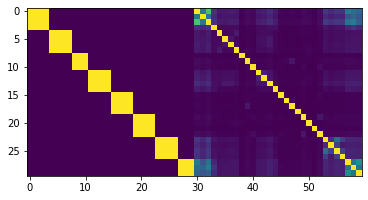

Logistic Regression Model
it:1/50---cost:-1.71e+00--- elapsed:108.61 [s]



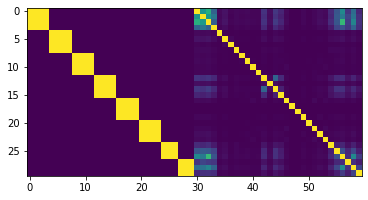

Linear SVM Model
it:1/50---cost:-1.76e+00--- elapsed:110.01 [s]



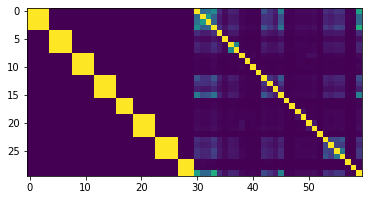

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.95      0.97        41

    accuracy                           0.95        41
   macro avg       0.50      0.48      0.49        41
weighted avg       1.00      0.95      0.98        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.98      0.99        41

    accuracy                           0.98        41
   macro avg       0.50      0.49      0.49        41
weighted avg       1.00      0.98      0.99        41

Iteration =  79/80


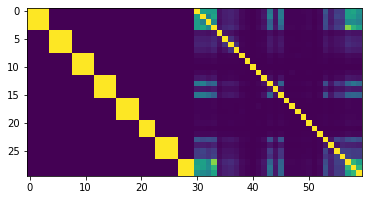

Logistic Regression Model
it:1/50---cost:-1.73e+00--- elapsed:98.54 [s]



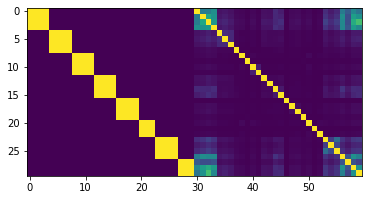

Linear SVM Model
it:1/50---cost:-1.79e+00--- elapsed:96.49 [s]



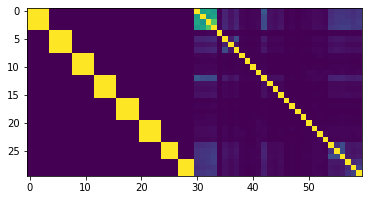

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.73      0.85        41

    accuracy                           0.73        41
   macro avg       0.50      0.37      0.42        41
weighted avg       1.00      0.73      0.85        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.71      0.83        41

    accuracy                           0.71        41
   macro avg       0.50      0.35      0.41        41
weighted avg       1.00      0.71      0.83        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.66      0.79        41

    accuracy                           0.66        41
   macro avg       0.50      0.33      0.40        41
weighted avg       1.00      0.66      0.79        41

Iteration =  80/80


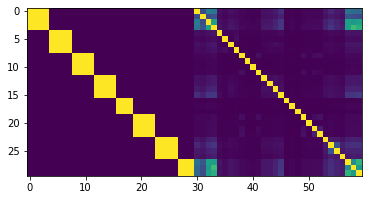

Logistic Regression Model
it:1/50---cost:-1.73e+00--- elapsed:108.41 [s]



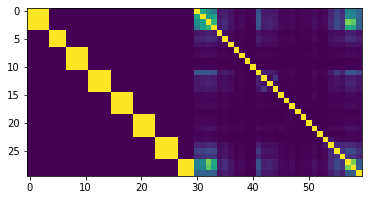

Linear SVM Model
it:1/50---cost:-1.73e+00--- elapsed:98.71 [s]



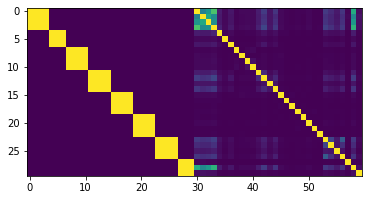

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.93      0.96        41

    accuracy                           0.93        41
   macro avg       0.50      0.46      0.48        41
weighted avg       1.00      0.93      0.96        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           8       1.00      0.90      0.95        41

    accuracy                           0.90        41
   macro avg       0.50      0.45      0.47        41
weighted avg       1.00      0.90      0.95        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       1.00      0.73      0.85        41

    accuracy                           0.73        41
   macro avg       0.33      0.24      0.28        41
weighted avg       1

In [ ]:
# Traininig/Testing loop implementing leave one objet out as Wand et. al. (2014) suggests it
fold = 0

for i in tqdm(range(len(np.unique(lobj)))):    
    # Number of partitions flag
    fold = fold + 1
    print("Iteration = ", str(fold) +'/'+ str(n_partitions))
    
    # Iteration file name 
    filename = img_path + "/Fold" + str(fold)

    # Train/Test partition and matrix storing to apply CKA over them for 
    # visualization
    X_train, X_test = X[lobj!=i+1], X[lobj==i+1]
    y_train, y_test = y[lobj!=i+1], y[lobj==i+1]
    X_train_cka     = X_train
    X_test_cka      = X_test
    y_train_cka     = y_train
    y_test_cka      = y_test

    # ---------------------------------------------------------------------------------------------------------------------------
    # Training
    
    # Linear
    print('Linear Model')
    # Using GridSearchCV 
    # hs_Lineal = GridSearchCV(Pipeline(steps[0]), parameters[0], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_Lineal = RandomizedSearchCV(Pipeline(steps[0]), param_distributions=parameters[0],n_iter=10, cv=5, iid=False, n_jobs=20)
    hs_Lineal.fit(X_train,y_train)
    # Projection matrix from CKA
    W_cka_L = hs_Lineal.best_estimator_.named_steps['Projection'].Wcka


    # Logistic Regression
    print('Logistic Regression Model')
    # Usaing GridSearchCV 
    # hs_LogR = GridSearchCV(Pipeline(steps[1]), parameters[1], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_LogR = RandomizedSearchCV(Pipeline(steps[1]), param_distributions=parameters[1],n_iter=10, cv=5, iid=False,n_jobs=20)
    hs_LogR.fit(X_train,y_train)
    # Projection matrix from CKA
    W_cka_LogR = hs_LogR.best_estimator_.named_steps['Projection'].Wcka
  

    # Linear SVM
    print('Linear SVM Model')
    # Using GridSearchCV 
    #hs_lSVM = GridSearchCV(Pipeline(steps[2]), parameters[2], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_lSVM = RandomizedSearchCV(Pipeline(steps[2]), param_distributions=parameters[2],n_iter=10, cv=5, iid=False, n_jobs=20)  
    hs_lSVM.fit(X_train,y_train)
    # Projection matrix from CKA
    W_cka_lSVM = hs_lSVM.best_estimator_.named_steps['Projection'].Wcka

    # ---------------------------------------------------------------------------------------------------------------------------
    # Validation
    
    # Linear
    y_pred_L           = hs_Lineal.best_estimator_.predict(X_test)
    accuracy_L[fold-1] = accuracy_score(y_test,y_pred_L)
#     cm_temp            = confusion_matrix(y_test,y_pred_L)
#     cm_L[fold-1,:,:]   = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
#     plot_confusion_matrix(y_test, y_pred_L, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_L[fold-1],fold) + '_'+ label_models[0])
#     plt.autoscale()
#     save_fig(img_path,label_models[0]+'_Fold'+str(fold))                      
#     plt.show()
    cr_L += [classification_report(y_test,y_pred_L)]
    print(cr_L[-1])
    # Best model storage
    # best_mod_L += [hs_Lineal.best_estimator_, accuracy_L,cm_L,cr_L, sel_fts_L]
    # best_mod_L += [hs_Lineal.best_estimator_]
    best_pms_L += [hs_Lineal.best_params_]
    joblib.dump(best_pms_L, filename + "LinealCKA" + ".pkl")


    # Logistic Regression
    y_pred_LogR          = hs_LogR.best_estimator_.predict(X_test)
    accuracy_LogR[fold-1]= accuracy_score(y_test,y_pred_LogR)
#     cm_temp              = confusion_matrix(y_test,y_pred_LogR)
#     cm_LogR[fold-1,:,:]  = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
#     plot_confusion_matrix(y_test, y_pred_LogR, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_LogR[fold-1],fold) + '_'+ label_models[1])
#     plt.autoscale()
#     save_fig(img_path,label_models[1]+'_Fold'+str(fold))                      
#     plt.show()
    cr_LogR += [classification_report(y_test,y_pred_LogR)]
    print(cr_LogR[-1])
    # Best model storage
    # best_mod_LogR += [hs_LogR.best_estimator_, accuracy_LogR,cm_LogR,cr_LogR, sel_fts_LogR]
    # best_mod_LogR += [hs_LogR.best_estimator_]
    best_pms_LogR += [hs_LogR.best_params_]
    joblib.dump(best_pms_LogR, filename + "LogRCKA" + ".pkl")


    # Linear SVM
    y_pred_lSVM          = hs_lSVM.best_estimator_.predict(X_test)
    accuracy_lSVM[fold-1]= accuracy_score(y_test,y_pred_lSVM)
#     cm_temp              = confusion_matrix(y_test,y_pred_lSVM)
#     cm_LogR[fold-1,:,:]  = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
#     plot_confusion_matrix(y_test, y_pred_lSVM, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_lSVM[fold-1],fold) + '_'+ label_models[2])
#     plt.autoscale()
#     save_fig(img_path,label_models[2]+'_Fold'+str(fold))                      
#     plt.show()
    cr_lSVM += [classification_report(y_test,y_pred_lSVM)]
    print(cr_lSVM[-1])
    # Best model storage
    # best_mod_lSVM += [hs_lSVM.best_estimator_, accuracy_lSVM,cm_lSVM,cr_lSVM, sel_fts_lSVM]
    # best_mod_lSVM += [hs_lSVM.best_estimator_]
    best_pms_lSVM += [hs_lSVM.best_params_]
    joblib.dump(best_pms_lSVM, filename + "lSVMCKA" + ".pkl")
    
    # Results dictionary creation
    L_dict = {'accuracy_L': accuracy_L,
#               'cm_L': cm_L,
              'cr_L': cr_L,
              'W_cka_L': W_cka_L,
              'X_train_cka': X_train_cka,
              'X_test_cka': X_test_cka,
              'y_train_cka':y_train_cka,
              'y_test_cka':y_test_cka}

    LogR_dict = {'accuracy_LogR': accuracy_LogR,
#                 'cm_LogR': cm_LogR,
                'cr_LogR': cr_LogR,
                'W_cka_LogR': W_cka_LogR,
                'X_train_cka': X_train_cka,
                'X_test_cka': X_test_cka,
                'y_train_cka':y_train_cka,
                'y_test_cka':y_test_cka}

    lSVM_dict = {'accuracy_lSVM': accuracy_lSVM,
#                 'cm_lSVM': cm_lSVM,
                'cr_lSVM': cr_lSVM,
                'W_cka_lSVM': W_cka_lSVM,
                'X_train_cka': X_train_cka,
                'X_test_cka': X_test_cka,
                'y_train_cka':y_train_cka,
                'y_test_cka':y_test_cka}

    Results = [L_dict, LogR_dict, lSVM_dict]

    joblib.dump(Results, rslt_dir + ".pkl")

Average result printing

In [ ]:
print('Linear Classifier')
print(str(np.mean(np.array(Results[0]['accuracy_L']))*100) + '+/-' + str(np.std(np.array(Results[0]['accuracy_L']))*100))

print('Logistic Regression Classifier')
print(str(np.mean(np.array(Results[1]['accuracy_LogR']))*100) + '+/-' + str(np.std(np.array(Results[1]['accuracy_LogR']))*100))

print('Linear SVM Classifier')
print(str(np.mean(np.array(Results[2]['accuracy_lSVM']))*100) + '+/-' + str(np.std(np.array(Results[2]['accuracy_lSVM']))*100))

Linear Classifier
91.82926829268293+/-12.425267380722675
Logistic Regression Classifier
92.83536585365853+/-12.342666901216457
Linear SVM Classifier
88.56707317073169+/-14.061952613445827


Projection matrix plotting

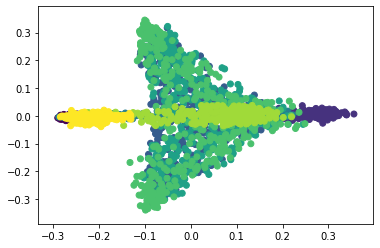

In [ ]:
W    = Results[1]['W_cka_LogR']
Xp   = X_train_cka.dot(W)
# Plotting the projection matrix
plt.scatter(Xp[:,1],Xp[:,2],c = y_train_cka)